# Chapter 1: The Baseline (LOS Calibration)
- Goal: Prove the hardware is stable.
- Visuals: Overlay all 20 samples from Channel 1 (LOS) on top of each other. They should look like a single thick line.
- Metric: Show that the FP_Index (First Path) always hits the same spot (e.g., ~746).

DEBUG: Calibration data: dataset\calibrations
DEBUG: Channel data:     dataset\channels

✅ SUCCESS: Found the data folder! Starting analysis...
---------------------------------------------------------------------------
CHANNEL    | SAMPLES    | AVG START INDEX      | STABILITY      
---------------------------------------------------------------------------
CH 1       | 20         | 746                  | +/- 2.40
CH 2       | 20         | 746                  | +/- 2.37
CH 3       | 20         | 746                  | +/- 2.51
CH 4       | 20         | 746                  | +/- 2.38
CH 5       | 20         | 746                  | +/- 2.63
CH 7       | 20         | 746                  | +/- 2.65


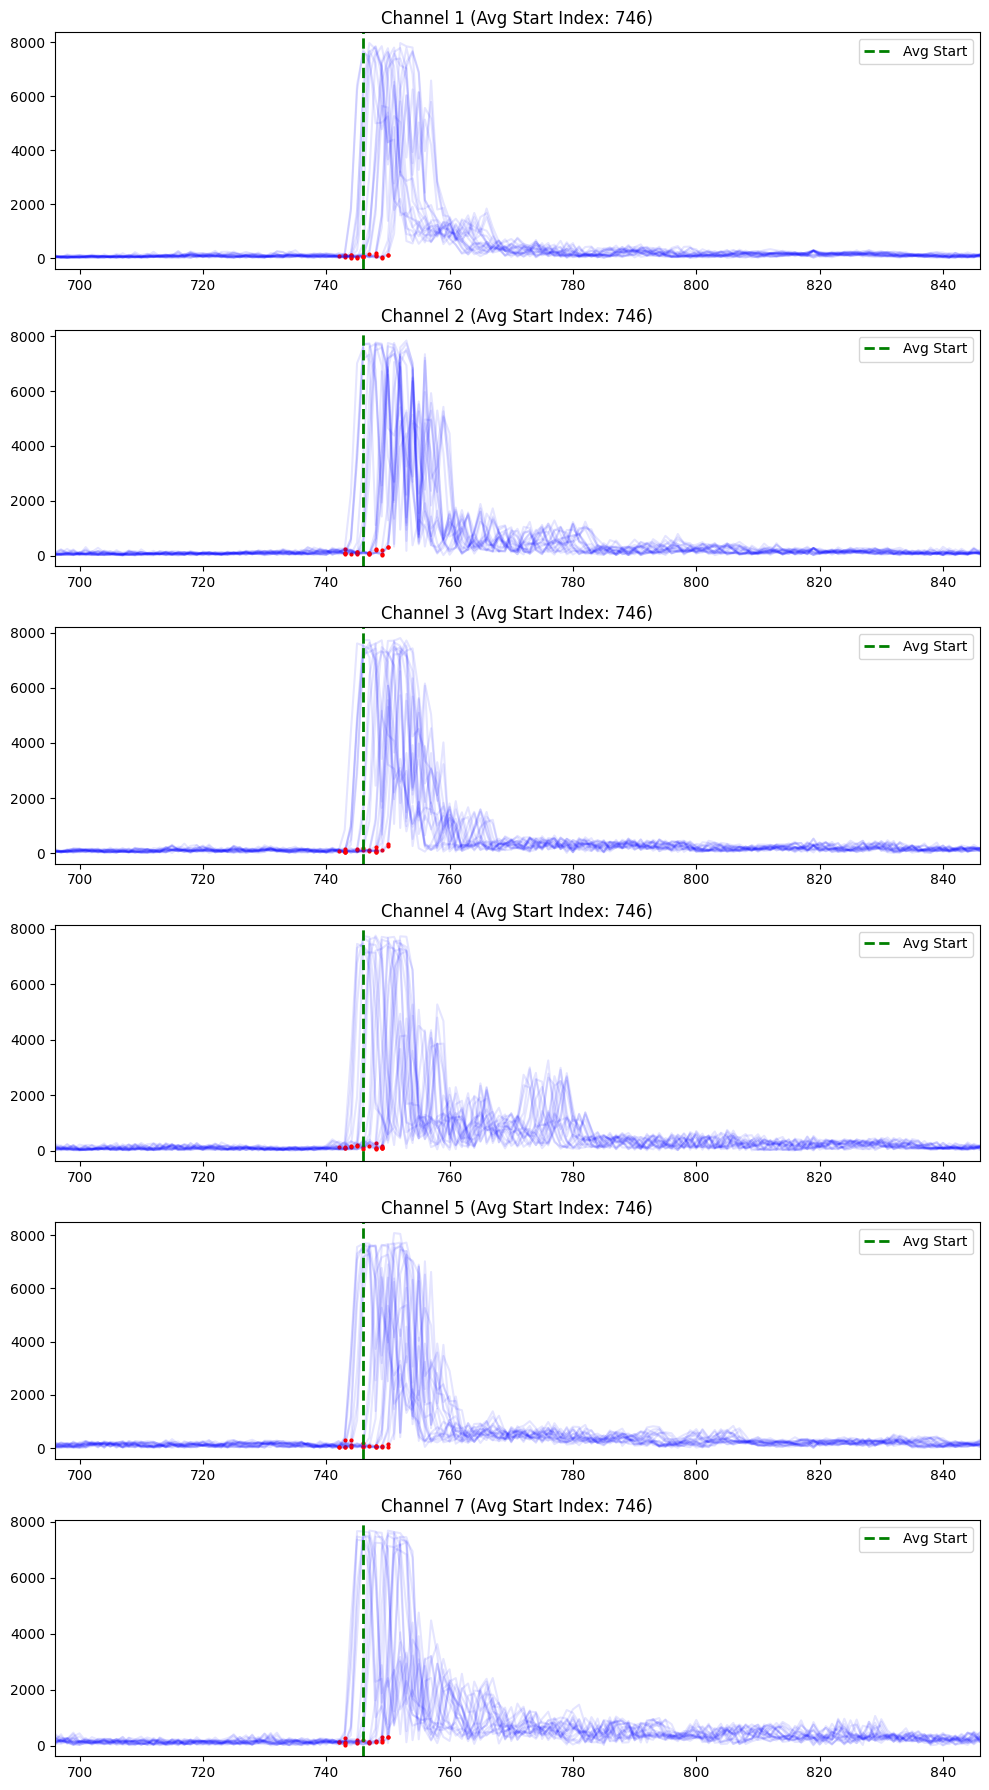

In [7]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. PATH CONFIGURATION
# ==========================================
# Base data directories (relative to notebook location in capstone/)
CALIBRATION_DIR = os.path.join('dataset', 'calibrations')
CHANNEL_DIR = os.path.join('dataset', 'channels')

DATA_DIR = CALIBRATION_DIR

print(f"DEBUG: Calibration data: {DATA_DIR}")
print(f"DEBUG: Channel data:     {CHANNEL_DIR}")

if not os.path.exists(DATA_DIR):
    print(f"\n❌ CRITICAL ERROR: Folder not found at {DATA_DIR}")
    if os.path.exists('dataset'):
        print(f"Contents of dataset/: {os.listdir('dataset')}")
else:
    print("\n✅ SUCCESS: Found the data folder! Starting analysis...")

# ==========================================
# 2. ANALYSIS LOGIC
# ==========================================
CHANNELS = [1, 2, 3, 4, 5, 7]
NOISE_THRESHOLD_SIGMA = 3.0 

def parse_cir_file(filepath):
    cir_samples = []
    if not os.path.exists(filepath):
        print(f"   -> Missing file: {os.path.basename(filepath)}")
        return []

    with open(filepath, 'r') as f:
        header = f.readline() 
        for line in f:
            line = line.strip()
            if not line or len(line) < 10: continue 
            
            parts = line.split(',')
            try:
                # CIR data starts from column 9 onwards
                cir_data = [int(x) for x in parts[9:] if x.lstrip('-').isdigit()]
                if len(cir_data) > 100:
                    cir_samples.append(cir_data)
            except ValueError:
                continue 
    return cir_samples

def detect_first_path(cir_data):
    """ Finds the First Path index (corresponds to TOA) """
    cir = np.array(cir_data)
    if len(cir) == 0: return 0
    
    max_peak_idx = np.argmax(cir)
    
    noise_section = cir[:min(50, max_peak_idx)]
    if len(noise_section) == 0: return 0
    
    noise_mean = np.mean(noise_section)
    noise_std = np.std(noise_section)
    threshold = noise_mean + (NOISE_THRESHOLD_SIGMA * noise_std)
    
    first_path = max_peak_idx
    for i in range(max_peak_idx, 0, -1):
        if cir[i] < threshold:
            first_path = i
            break
    return first_path

# ==========================================
# 3. RUN AND PLOT
# ==========================================
print("-" * 75)
print(f"{'CHANNEL':<10} | {'SAMPLES':<10} | {'AVG START INDEX':<20} | {'STABILITY':<15}")
print("-" * 75)

fig, axes = plt.subplots(len(CHANNELS), 1, figsize=(10, 18))
if len(CHANNELS) == 1: axes = [axes]

for i, ch in enumerate(CHANNELS):
    filename = f"2m_loscalibration_c{ch}.csv"
    filepath = os.path.join(DATA_DIR, filename)
    
    samples = parse_cir_file(filepath)
    ax = axes[i]
    start_indices = []
    
    if len(samples) > 0:
        for cir_wave in samples:
            fp_idx = detect_first_path(cir_wave)
            start_indices.append(fp_idx)
            
            ax.plot(cir_wave, color='blue', alpha=0.1)
            ax.plot(fp_idx, cir_wave[fp_idx], 'r.', markersize=4)
        
        avg_start = int(np.mean(start_indices))
        std_dev = np.std(start_indices)
        
        print(f"CH {ch:<7} | {len(samples):<10} | {avg_start:<20} | +/- {std_dev:.2f}")
        
        ax.set_title(f"Channel {ch} (Avg Start Index: {avg_start})")
        ax.axvline(avg_start, color='green', linestyle='--', linewidth=2, label='Avg Start')
        ax.set_xlim(max(0, avg_start - 50), avg_start + 100)
        ax.legend(loc='upper right')
    else:
        print(f"CH {ch:<7} | 0          | N/A                  | N/A")
        ax.text(0.5, 0.5, f"File {filename} not found", ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

Analysis of Calibration Results & Methodology1. Verification of Signal Alignment (The "Green Line")Observation:Across all 20 calibration samples for every channel (1, 2, 3, 4, 5, 7), the First Path Index consistently appeared at Index ~746 (with a stability of $\pm$ 2.4 indices).Derivation Method:The "Start Index" was derived programmatically using a leading-edge detection algorithm:Peak Detection: Identified the maximum amplitude index in the raw Channel Impulse Response (CIR).Noise Floor Estimation: Calculated the mean ($\mu$) and standard deviation ($\sigma$) of the noise from the first 50 empty samples.Back-Search: Traversed backwards from the peak index until the signal amplitude dropped below the noise threshold ($\mu + 3\sigma$).Result: The index where the signal first rises above the noise floor is marked as the "First Path."Hardware Explanation:The consistency of Index 746 is intrinsic to the Decawave DW1000 chip. The chip utilizes a hardware Leading Edge Detection (LDE) algorithm which automatically time-shifts the received waveform within its accumulator memory. It aligns the leading edge of the pulse to a fixed internal reference (typically around index 740–750). This behavior confirms that the hardware is successfully and consistently locking onto the Line-of-Sight signal.Implication for Preprocessing:Since the signal start is deterministic and stable, we can implement Fixed Windowing for our Neural Network. We will standardly slice the input data from Index 740 to 890 (150 samples). This ensures the model always receives the complete pulse shape without the computational overhead of dynamic alignment.2. The Role of Antenna Delay CalibrationThe Paradox:If the CIR waveform shape (the Neural Network's input) remains identical regardless of software calibration, why is calibration necessary?The Solution:Calibration is required to correct the Label (Ground Truth), not the Input.The Input (CIR): The physical shape of the waveform is determined by physics (walls, obstacles, reflections). Changing the ANT_DLY register in software does not alter the physical wave flying through the air.The Label (Distance Error): The Neural Network is trained to predict the ranging error caused by NLOS conditions. The ground truth error is calculated as:$$\text{Error} = \text{Measured Distance} - \text{True Distance}$$Conclusion:Without calibration, the hardware introduces a static offset (e.g., reading 2.60m for a 2.00m path). This would force the AI to learn that a "perfect" Line-of-Sight signal corresponds to a large error (e.g., +0.60m), which is false.By calibrating the antenna delay, we ensure that Clean LOS Signal $\approx$ 0.00m Error. This effectively "zeroes the scale," ensuring that any error the Neural Network learns to predict is purely generated by environmental factors (NLOS) and not hardware bias.

# Chapter 2: The Multi-Channel Fingerprint

- Goal: Show how different channels "see" the same room.
- Visuals: Plot the same LOS scenario across all 6 channels.
- Discovery: Higher channels (like 5 and 7) usually have sharper peaks but higher attenuation. This justifies why you are using multi-channel data for your Liquid Neural Network (LNN).
- In UWB systems, lower channels typically offer better penetration through obstacles, while higher channels provide better temporal resolution due to wider bandwidth. This "fingerprint" is what your model uses to distinguish between environmental effects and hardware characteristics.
- The Multi-Channel Fingerprint Storyline
Objective: Analyze the consistency of the pulse shape across different center frequencies under identical Line-of-Sight (LOS) conditions.

- Hypothesis: Higher channels (Channel 5/7) will exhibit sharper rising edges and higher Kurtosis, while lower channels (Channel 1/2) may show more "ringing" but better signal stability.

- LNN Relevance: The Tau Controller in your LNN needs to learn that a "fast" time constant on Channel 7 might look different than a "fast" time constant on Channel 1 due to these physical differences.

## 2.1 Multi-Channel Analysis

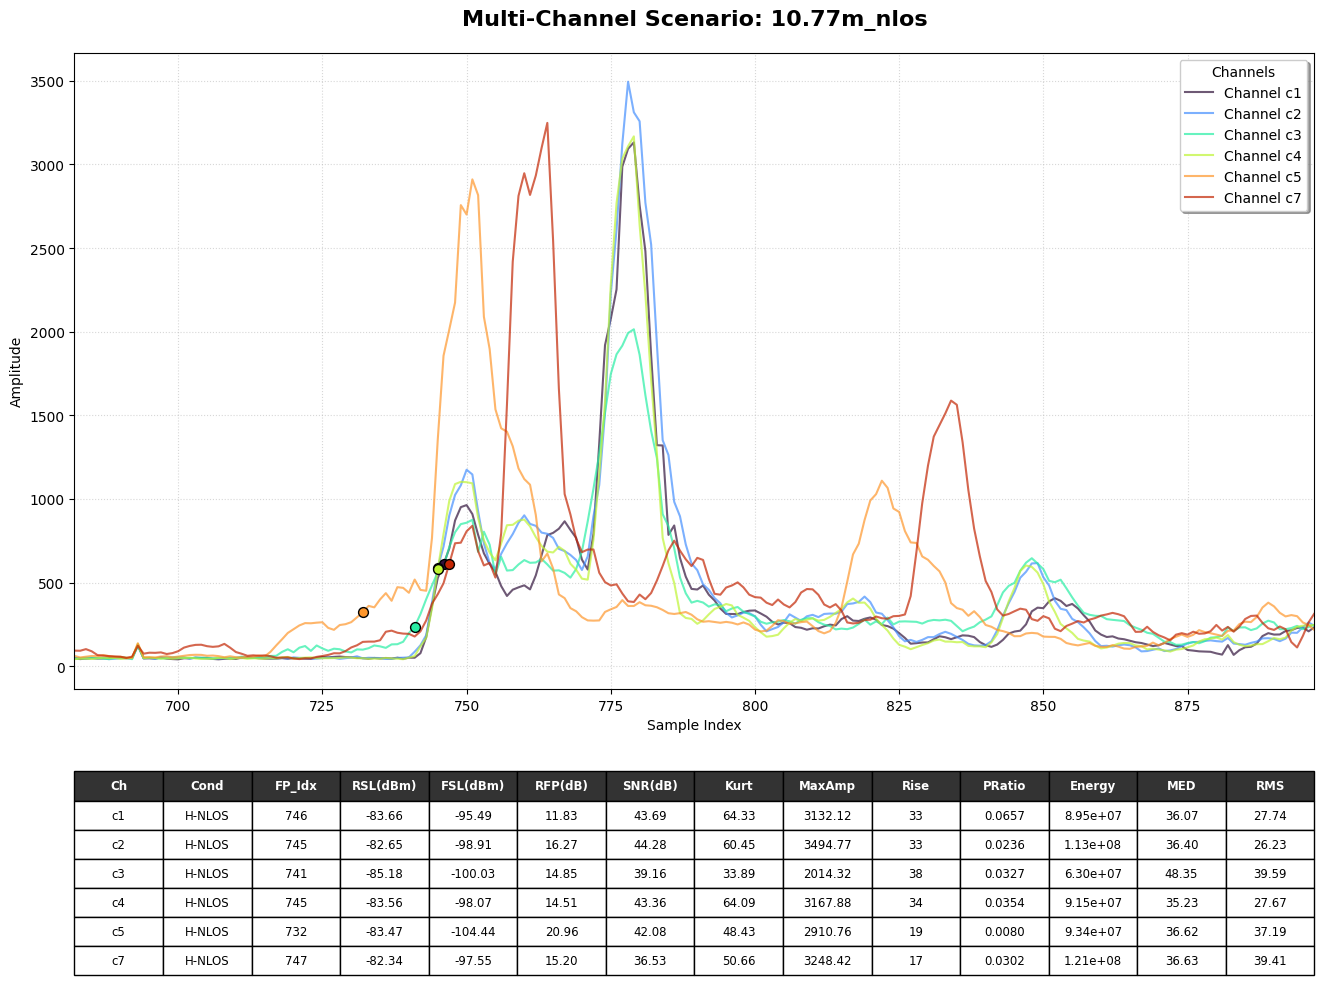

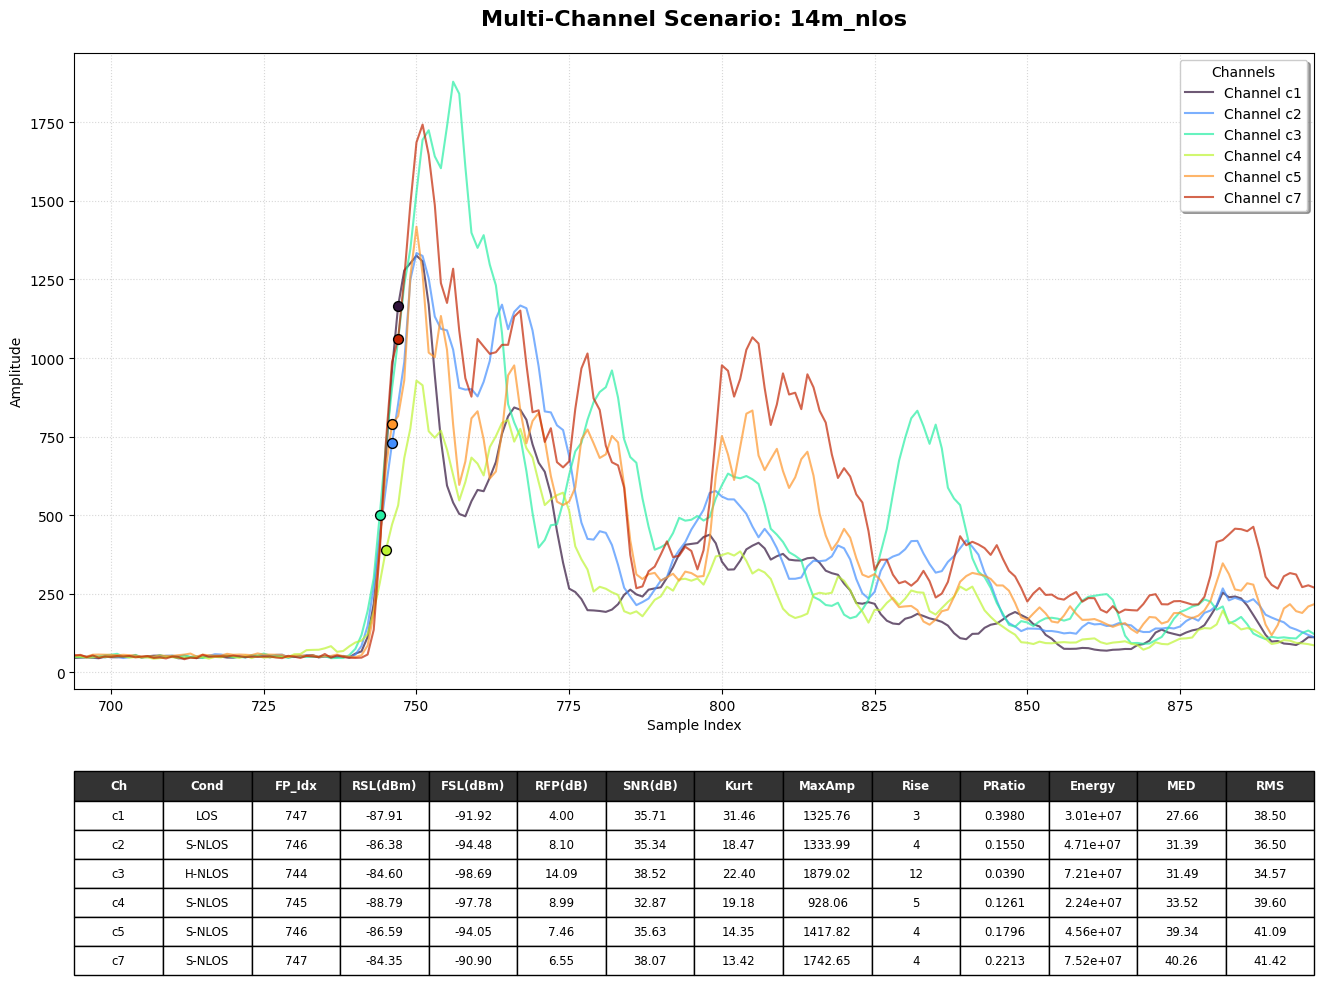

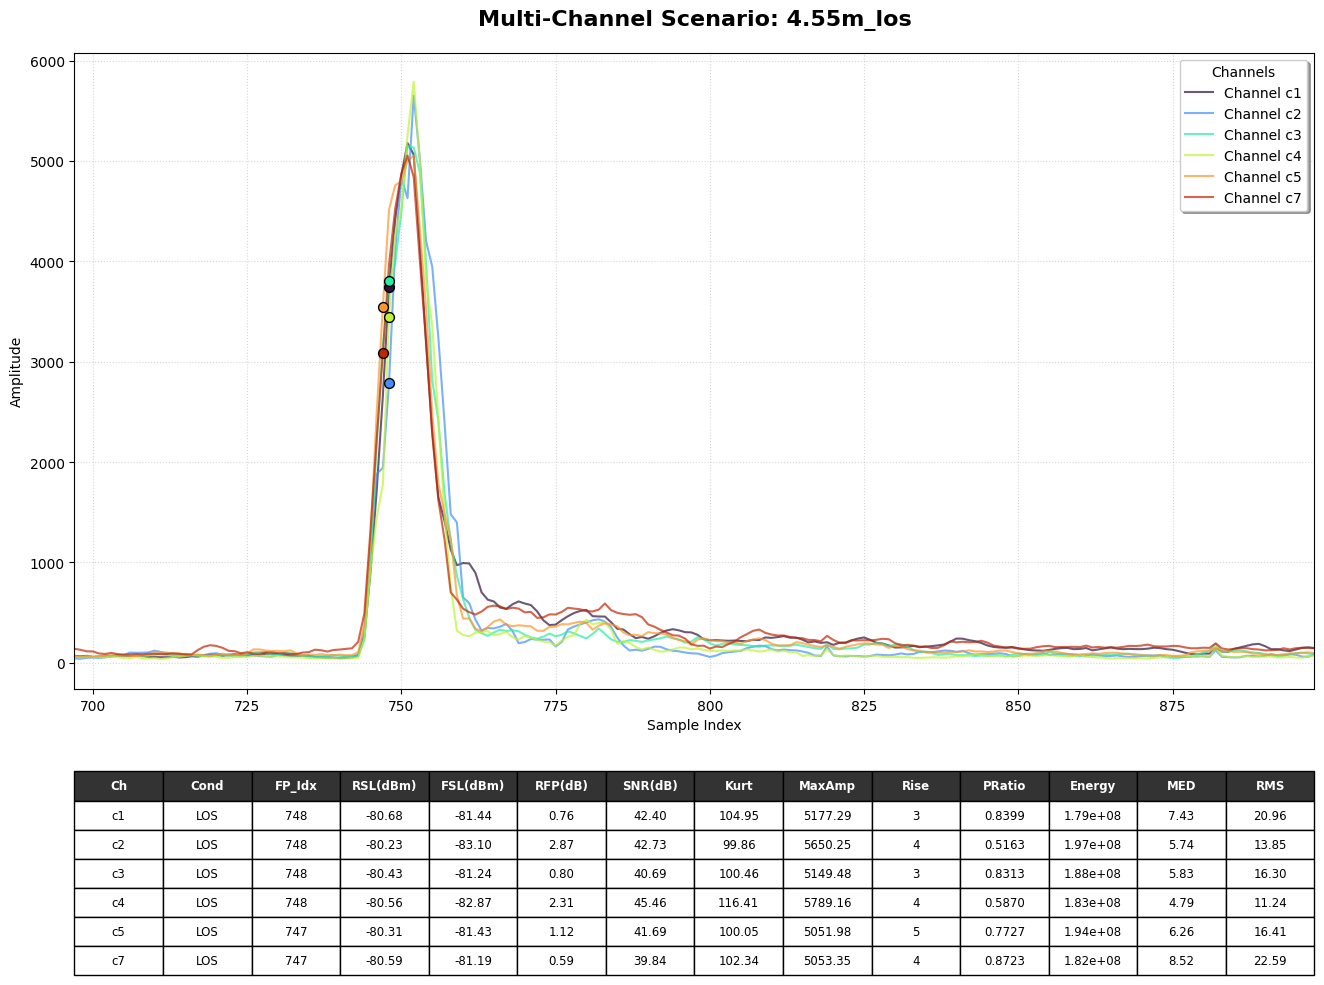

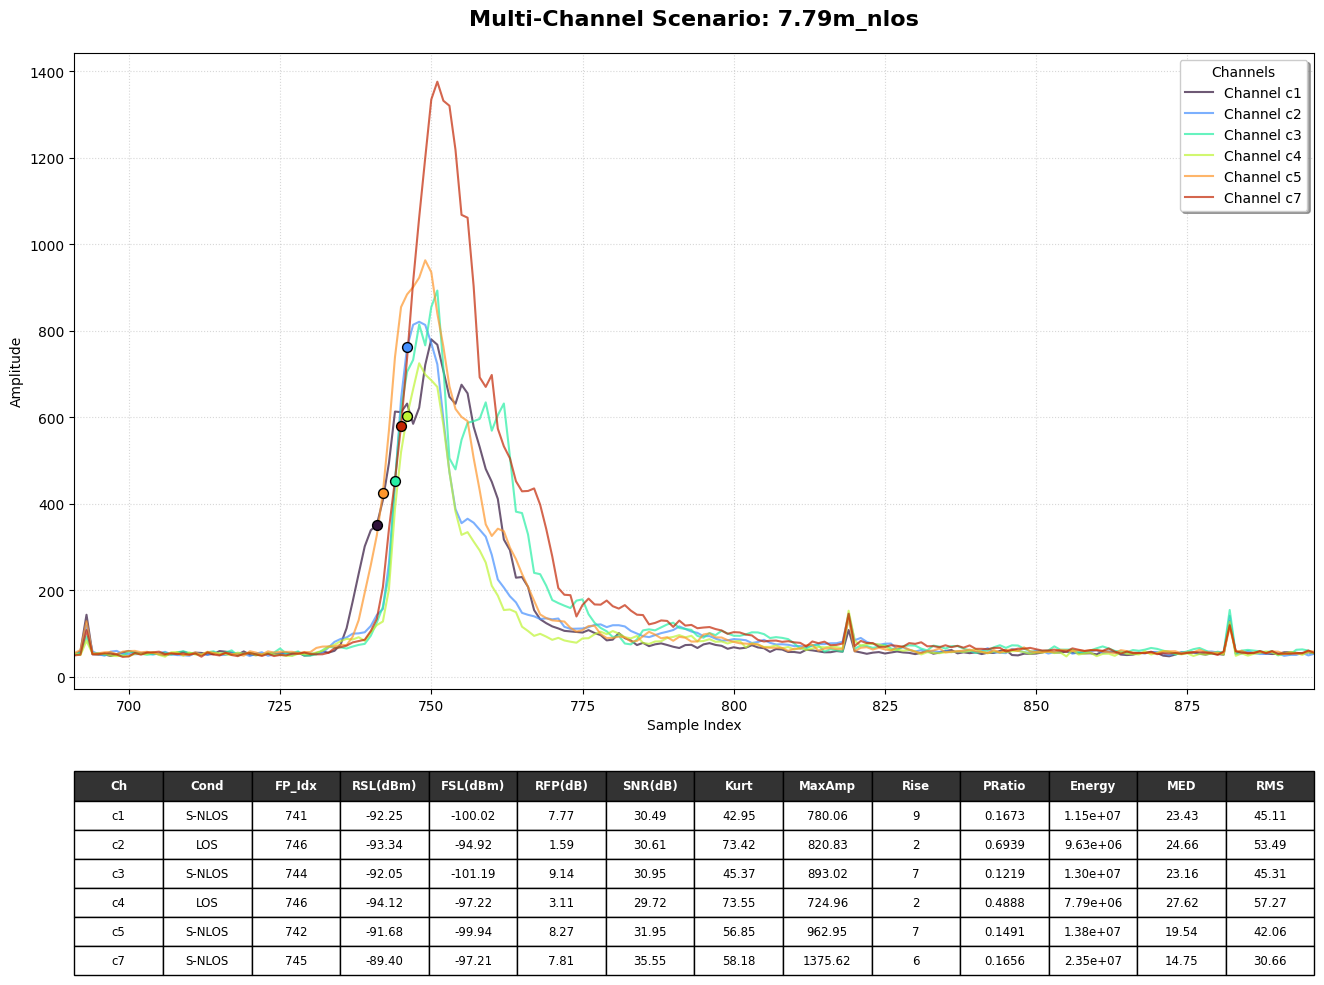

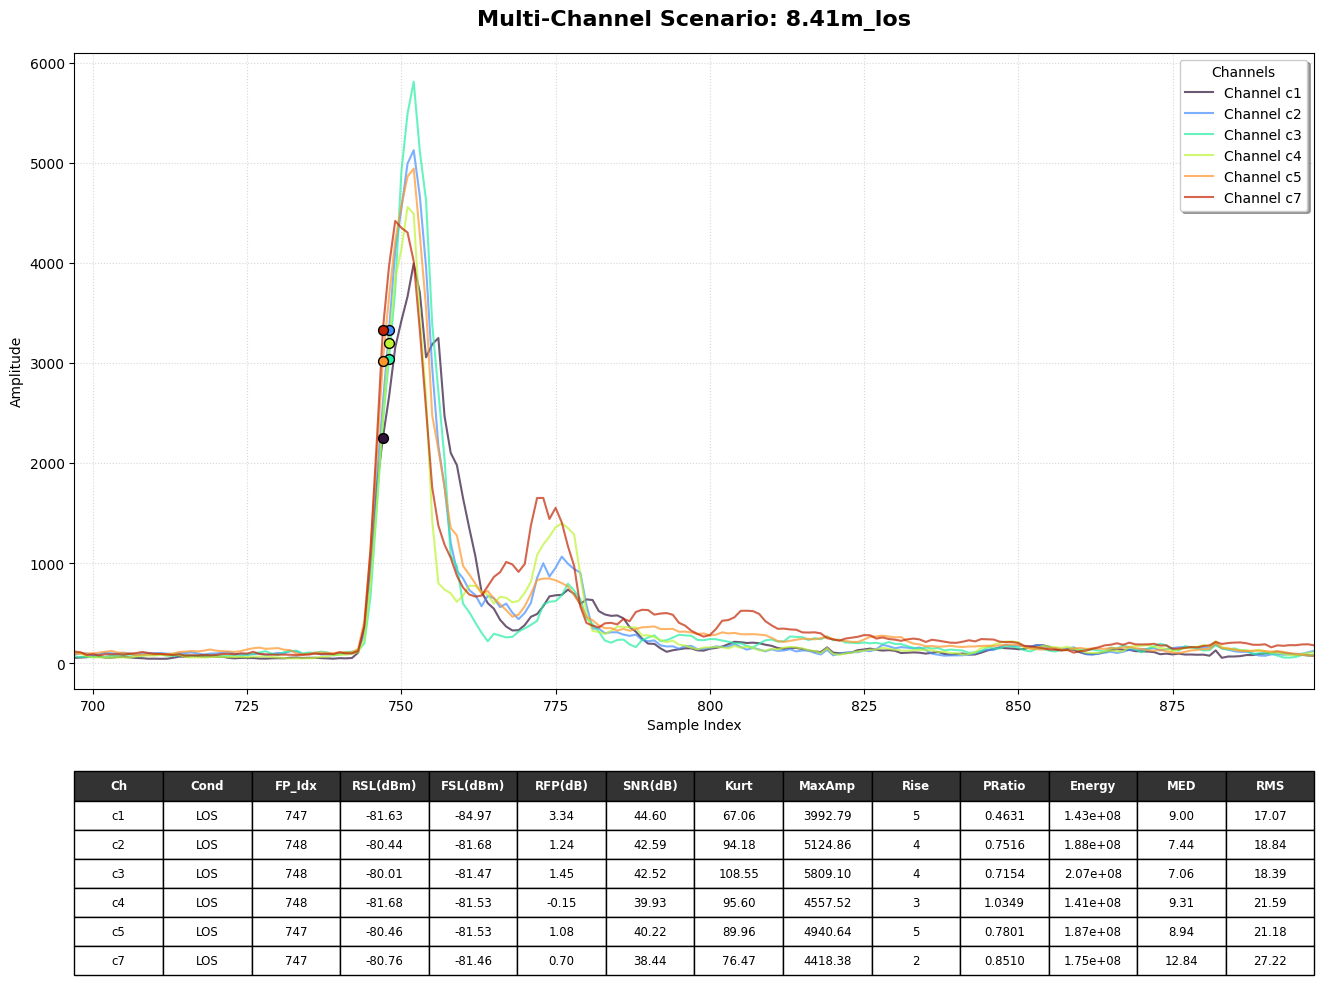

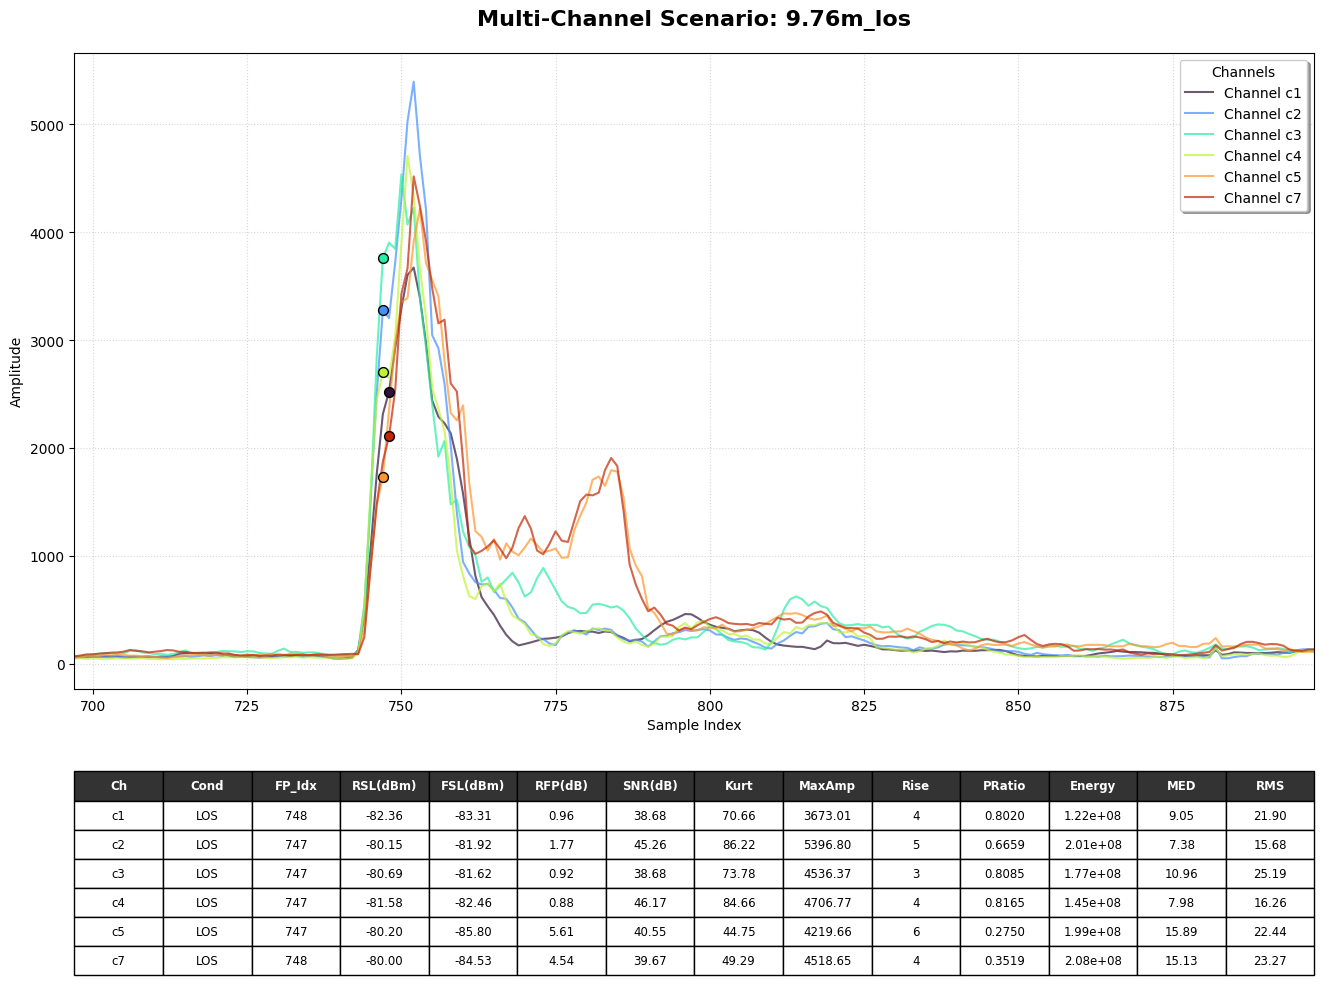

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import glob
import re
import os

# ==========================================
# 1. METRIC CALCULATION
# ==========================================
def get_original_metrics(filepath):
    try:
        df = pd.read_csv(filepath)
        cir_cols = sorted([c for c in df.columns if c.startswith('CIR')], key=lambda x: int(x.replace('CIR', '')))
        if not cir_cols: return None 
        
        # --- WAVEFORM: MEAN OF ALL ROWS ---
        avg_wave = np.mean(df[cir_cols].values, axis=0)
        
        # --- Constants & Signal Strength ---
        A = 121.74 
        N = df['RXPACC'].mean() if 'RXPACC' in df.columns else (df['RXP_ACC'].mean() if 'RXP_ACC' in df.columns else 128.0)
        
        # RSL Logic & Total Energy
        total_energy = np.sum(avg_wave**2)
        C = df['CIR_PWR'].mean() if 'CIR_PWR' in df.columns else total_energy / (2**17) 
        RSL = 10 * np.log10( (max(C, 1e-9) * (2**17)) / (N**2) ) - A

        # FSL Logic (First Path)
        hw_fp_idx = int(df['FP_INDEX'].mean() / 64)
        if 'FP_AMPL1' in df.columns:
            f1, f2, f3 = df['FP_AMPL1'].mean(), df['FP_AMPL2'].mean(), df['FP_AMPL3'].mean()
        else:
            f1, f2, f3 = avg_wave[max(0, hw_fp_idx-1)], avg_wave[hw_fp_idx], avg_wave[min(len(avg_wave)-1, hw_fp_idx+1)]
        
        fp_energy = (f1**2 + f2**2 + f3**2)
        FSL = 10 * np.log10( max(fp_energy, 1e-9) / (N**2) ) - A
        RFP = RSL - FSL

        # --- Adjusted Thresholds for LOS Accuracy ---
        if RFP < 6.0: condition = "LOS"
        elif RFP <= 10.0: condition = "S-NLOS"
        else: condition = "H-NLOS"

        # --- Quality, Rise Time & Power Ratio ---
        max_amp = np.max(avg_wave)
        peak_idx = np.argmax(avg_wave)
        rise_time = peak_idx - hw_fp_idx
        power_ratio = fp_energy / max(total_energy, 1e-9)
        
        std_noise = df['STD_NOISE'].mean() if 'STD_NOISE' in df.columns else np.std(avg_wave[0:30])
        SNR = 20 * np.log10(max_amp / (std_noise + 1e-9))
        
        # --- Delay Analysis (Mean Excess Delay & RMS) ---
        pdp = avg_wave[hw_fp_idx:]**2
        pwr_sum = np.sum(pdp) + 1e-9
        mean_delay = np.sum(pdp * np.arange(len(pdp))) / pwr_sum
        rms_delay = np.sqrt(max(0, (np.sum(pdp * (np.arange(len(pdp))**2)) / pwr_sum) - (mean_delay**2)))

        return {
            "Ch": re.search(r'_(c\d+)\.csv', filepath).group(1),
            "Wave": avg_wave, "FP": hw_fp_idx, "Cond": condition,
            "RSL": f"{RSL:.2f}", "FSL": f"{FSL:.2f}", "RFP": f"{RFP:.2f}",
            "SNR": f"{SNR:.2f}", "Kurt": f"{kurtosis(avg_wave):.2f}",
            "MaxAmp": f"{max_amp:.2f}", "Rise": f"{rise_time}",
            "PRatio": f"{power_ratio:.4f}", "Energy": f"{total_energy:.2e}",
            "MED": f"{mean_delay:.2f}", "RMS": f"{rms_delay:.2f}"
        }
    except Exception: return None

def plot_overlay_with_table(scenario_prefix):
    files = sorted(glob.glob(f"{scenario_prefix}_c*.csv"), 
                   key=lambda x: int(re.search(r'_c(\d+)', x).group(1)))
    if not files: return

    results = [get_original_metrics(f) for f in files if get_original_metrics(f) is not None]
    
    fig, ax = plt.subplots(figsize=(16, 12))
    colors = plt.cm.turbo(np.linspace(0, 0.9, len(results)))
    
    for i, res in enumerate(results):
        ax.plot(res['Wave'], color=colors[i], label=f"Channel {res['Ch']}", lw=1.5, alpha=0.7)
        ax.scatter(res['FP'], res['Wave'][res['FP']], color=colors[i], s=50, edgecolors='black', zorder=5)

    ax.set_title(f"Multi-Channel Scenario: {os.path.basename(scenario_prefix)}", fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Sample Index")
    
    all_fps = [res['FP'] for res in results]
    ax.set_xlim(min(all_fps) - 50, max(all_fps) + 150)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(loc='upper right', title="Channels", shadow=True)

    # --- TABLE HEADERS & ROWS (Including FP_Index) ---
    headers = ["Ch", "Cond", "FP_Idx", "RSL(dBm)", "FSL(dBm)", "RFP(dB)", "SNR(dB)", "Kurt", "MaxAmp", "Rise", "PRatio", "Energy", "MED", "RMS"]
    rows = [[r['Ch'], r['Cond'], r['FP'], r['RSL'], r['FSL'], r['RFP'], r['SNR'], r['Kurt'], 
             r['MaxAmp'], r['Rise'], r['PRatio'], r['Energy'], r['MED'], r['RMS']] for r in results]
    
    table = plt.table(cellText=rows, colLabels=headers, loc='bottom', cellLoc='center', bbox=[0, -0.45, 1, 0.32])
    table.auto_set_font_size(False)
    table.set_fontsize(8.5)
    
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#333333')

    plt.subplots_adjust(bottom=0.35)
    plt.show()

# Execution — search in dataset/channel/
all_csvs = glob.glob(os.path.join(CHANNEL_DIR, "*.csv"))
unique_scenarios = sorted(list(set([re.sub(r'_c\d+\.csv$', '', f) for f in all_csvs if "_c" in f])))
for s in unique_scenarios:
    plot_overlay_with_table(s)

## 2.2 Individual Analysis

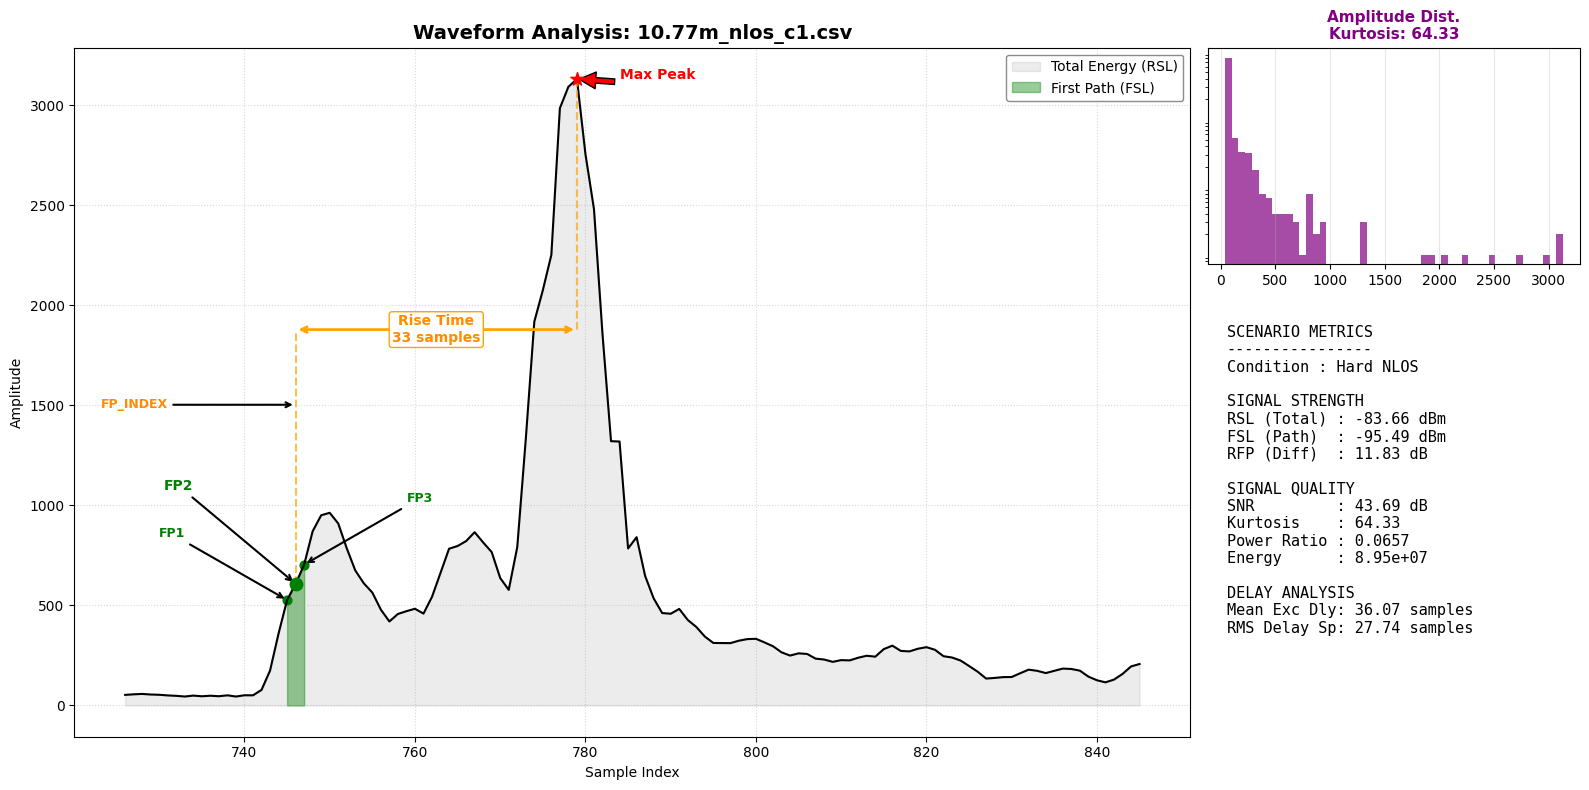

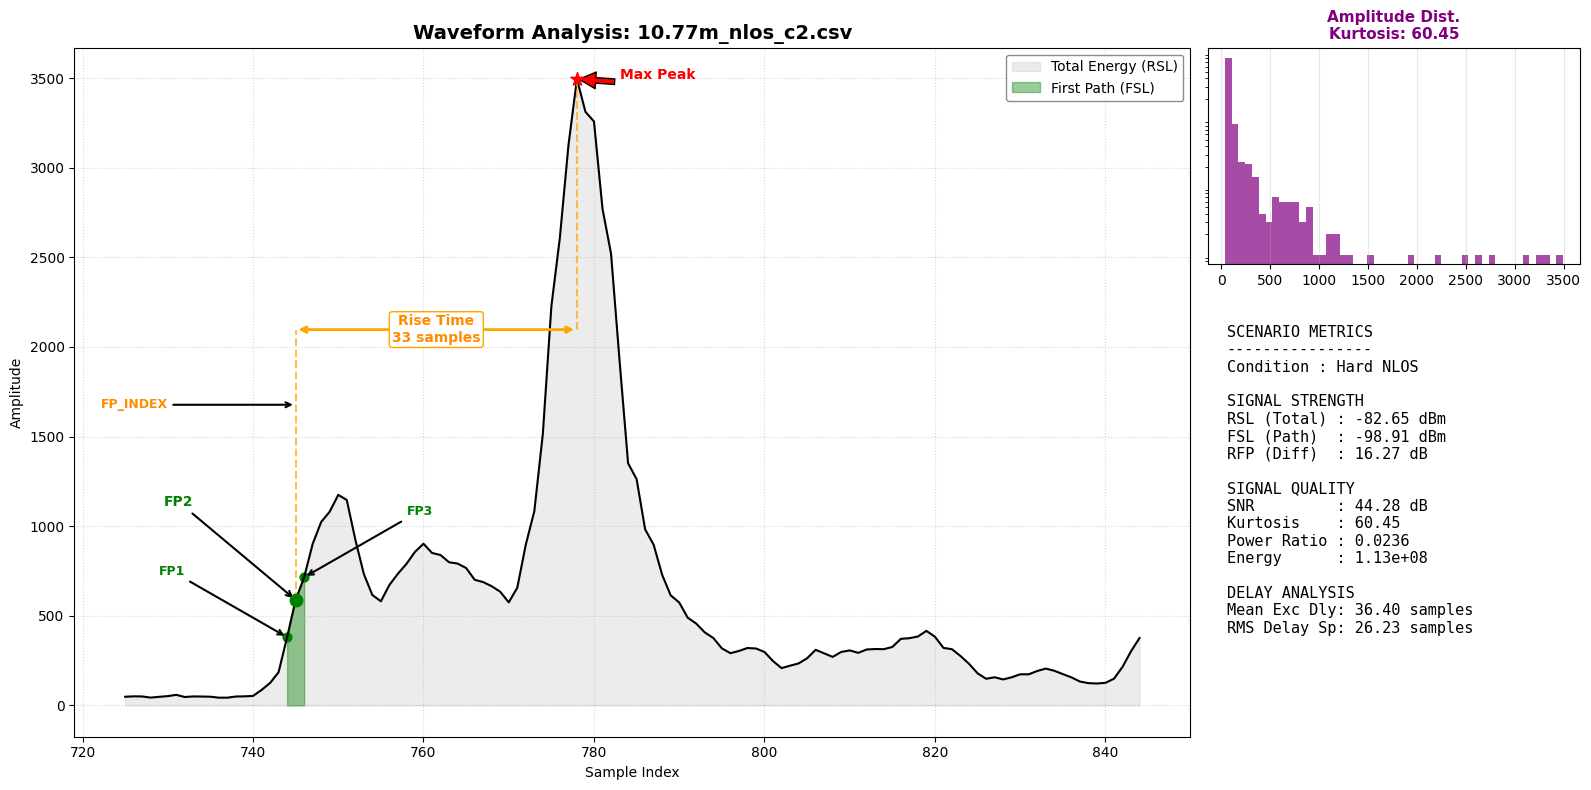

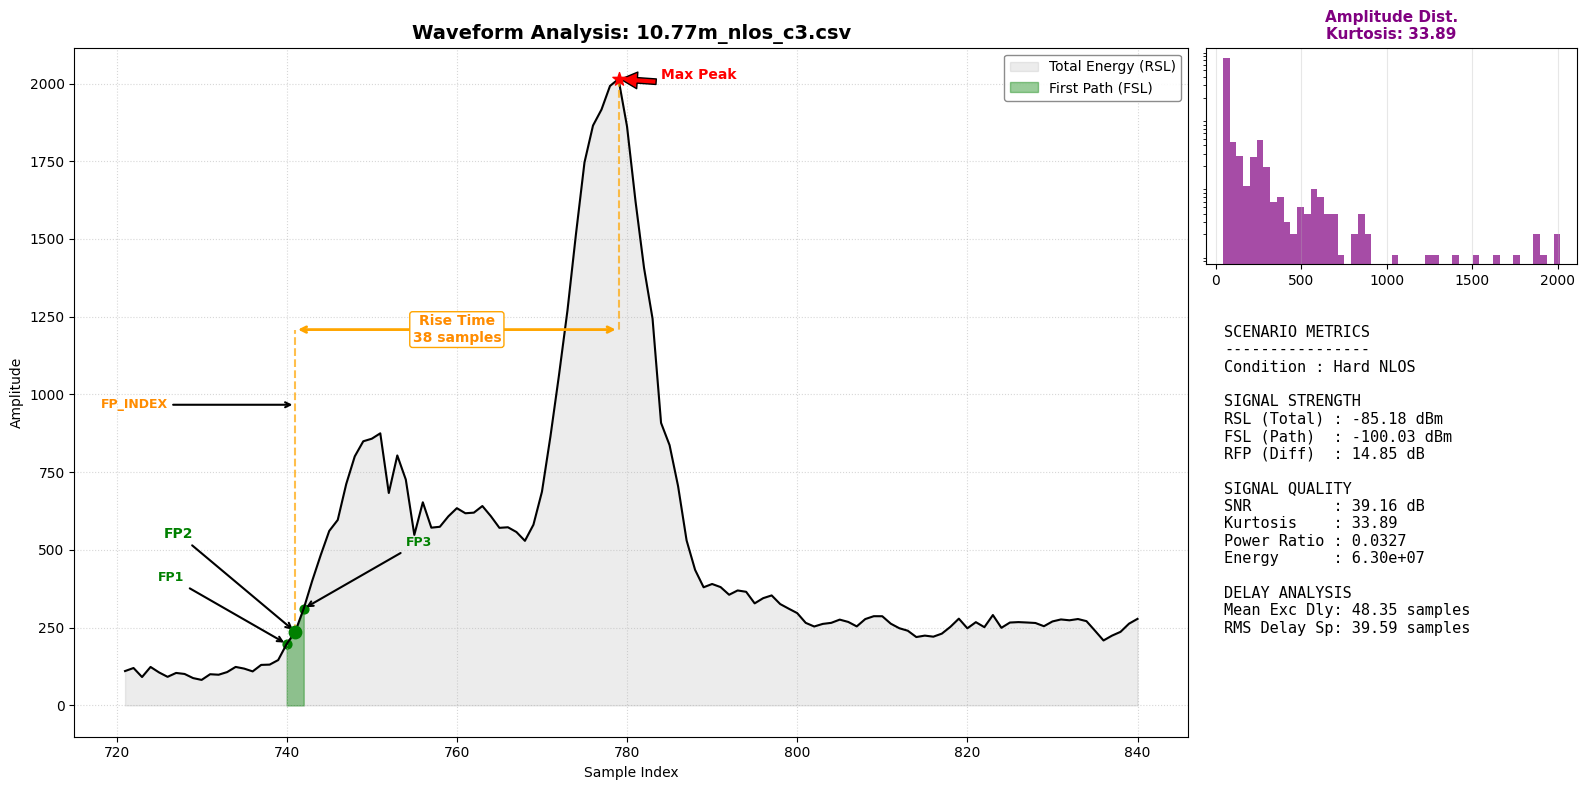

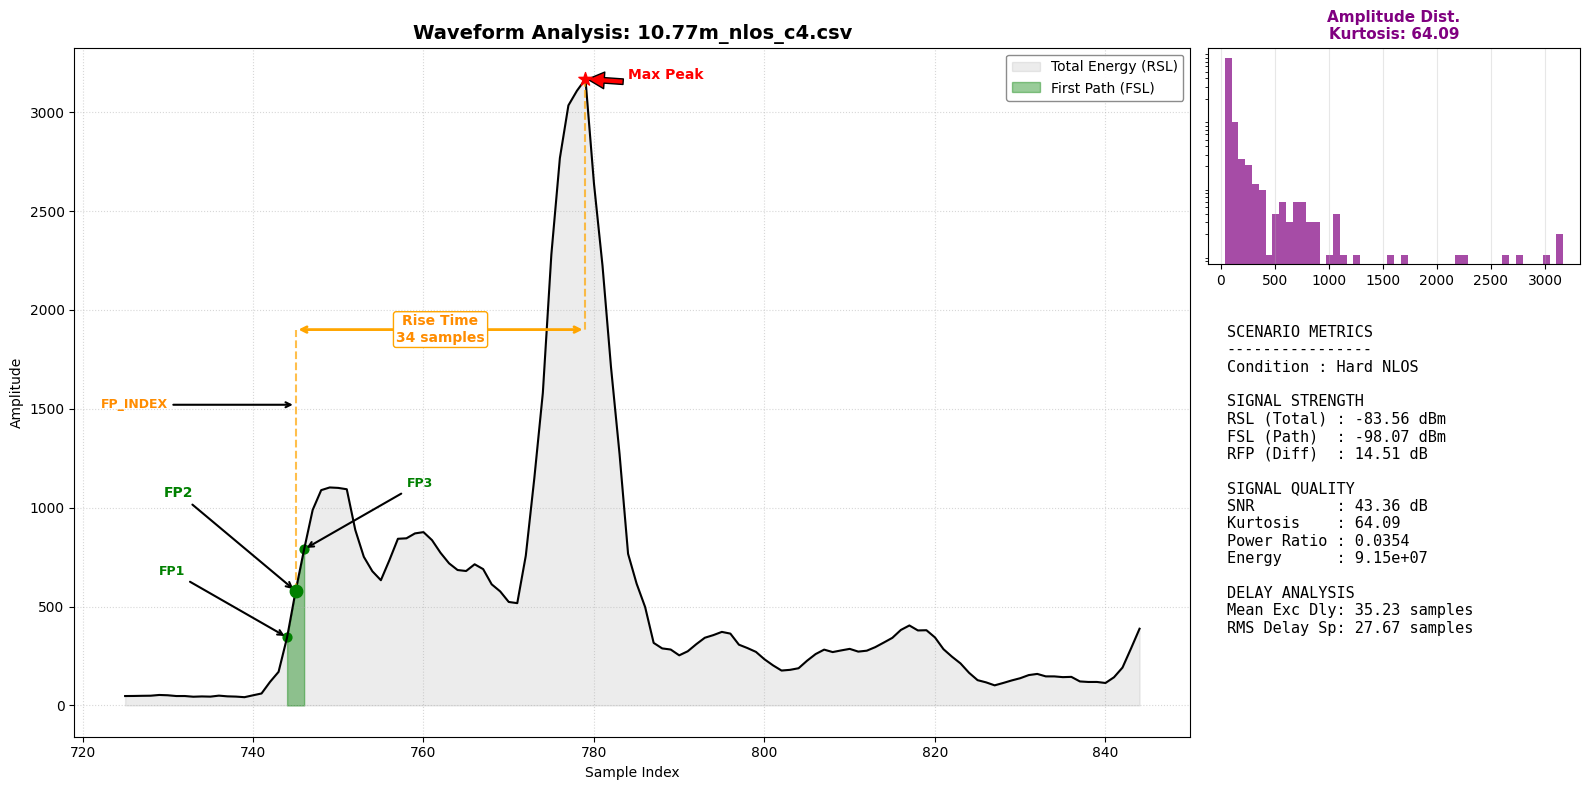

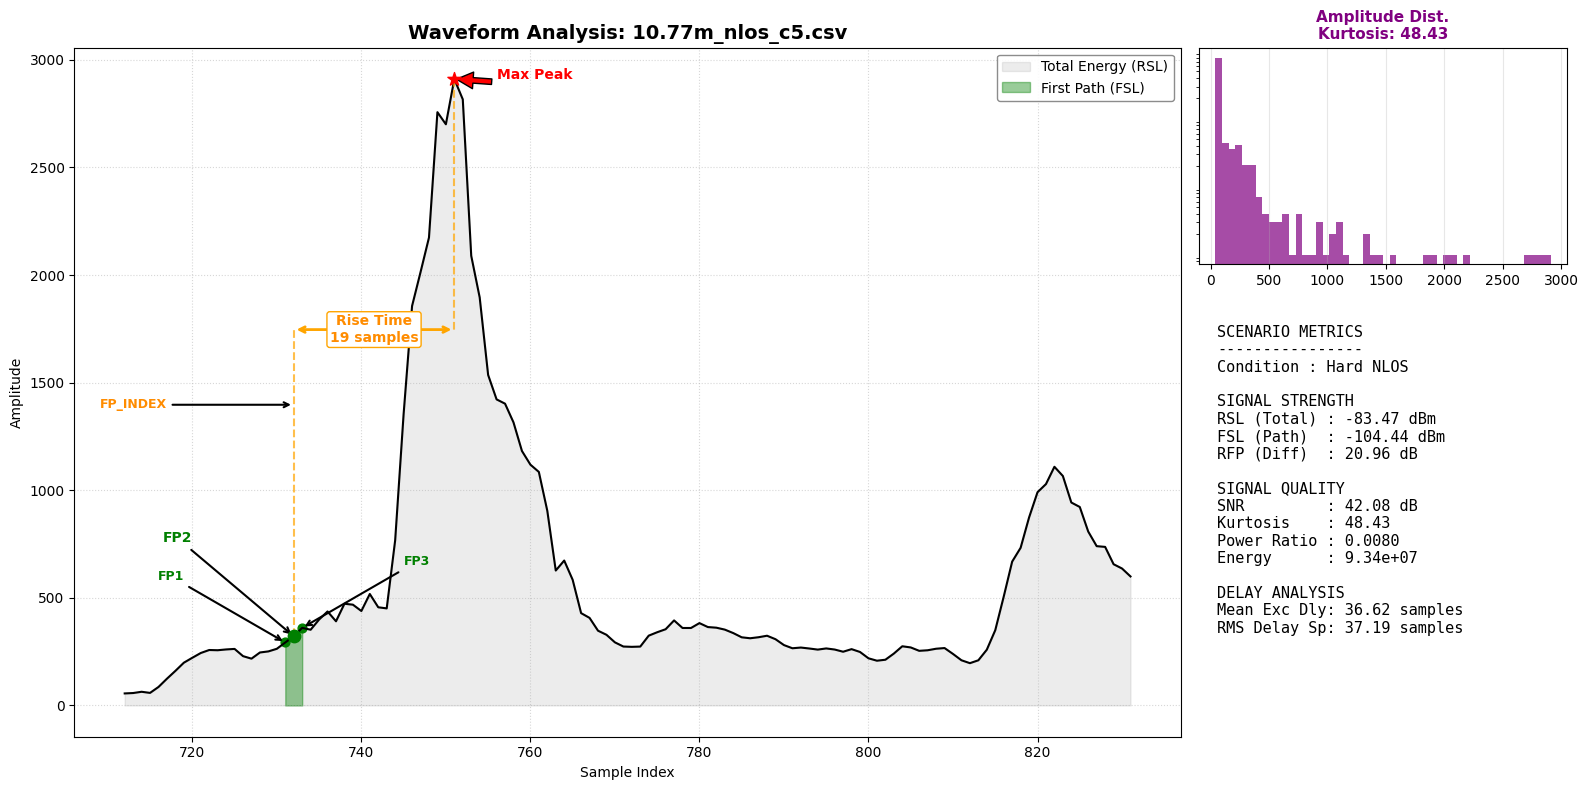

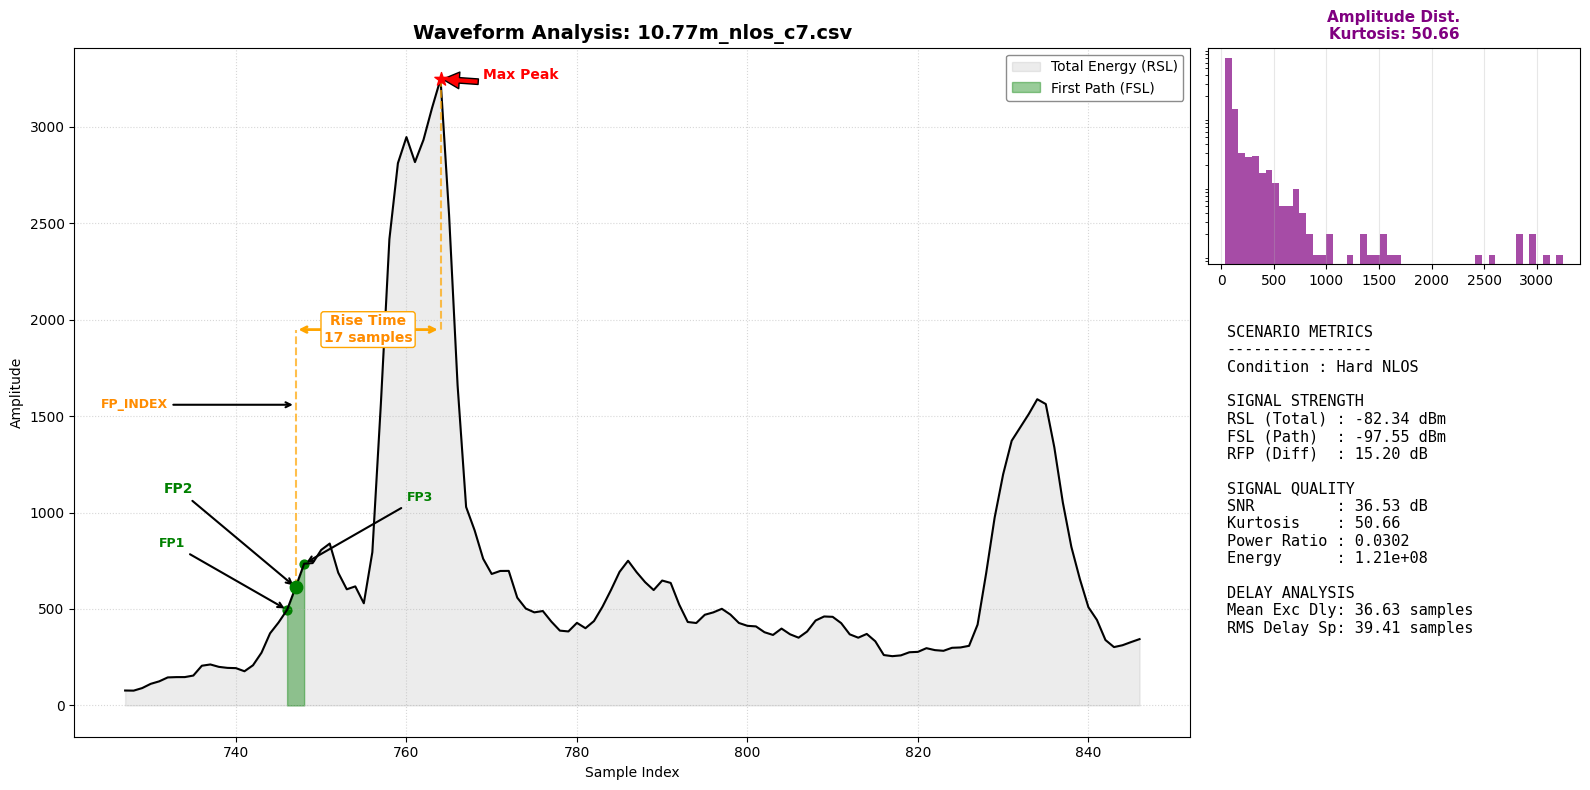

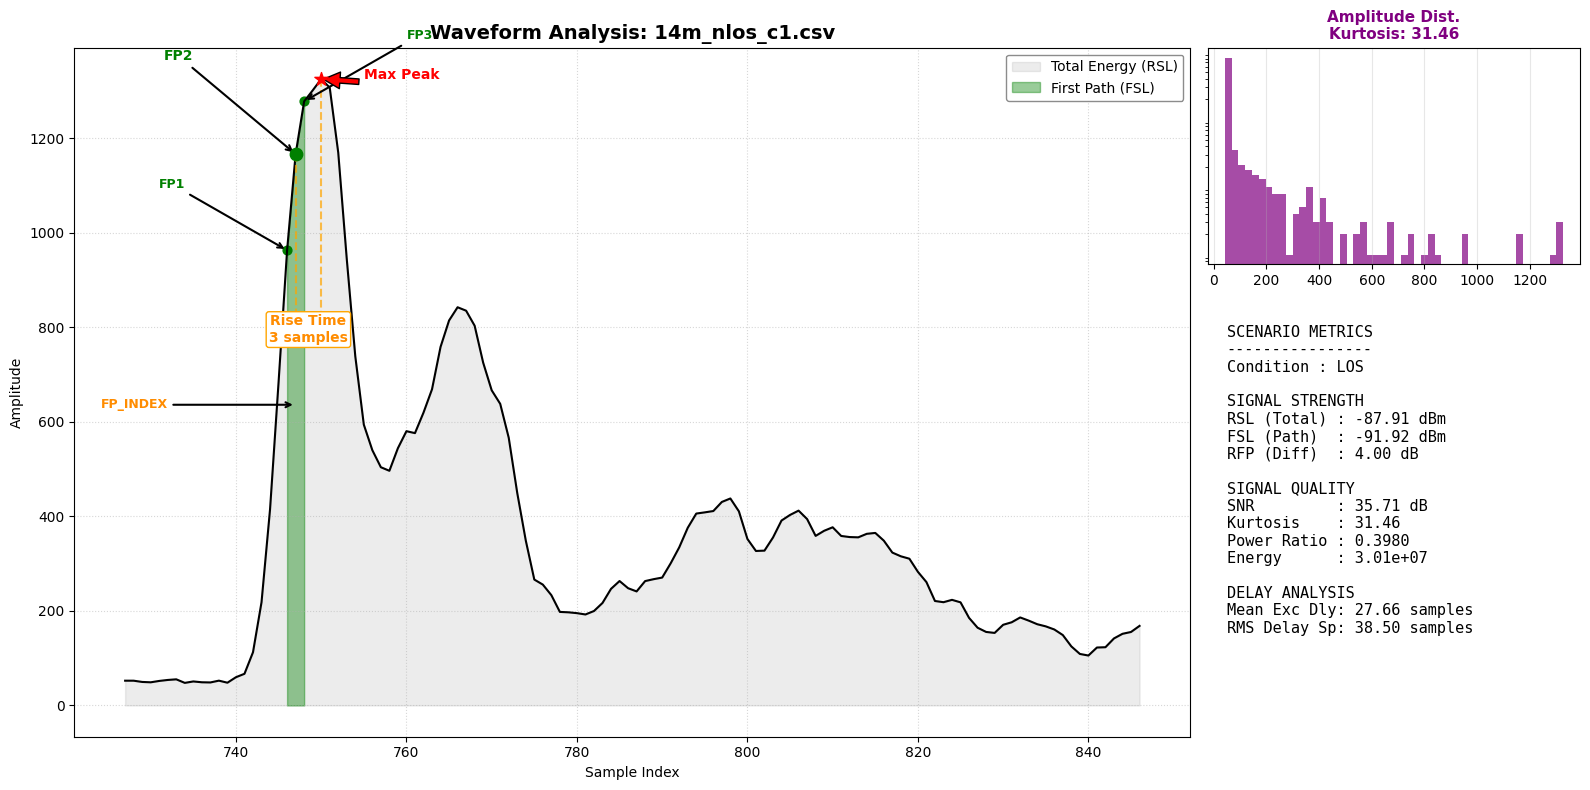

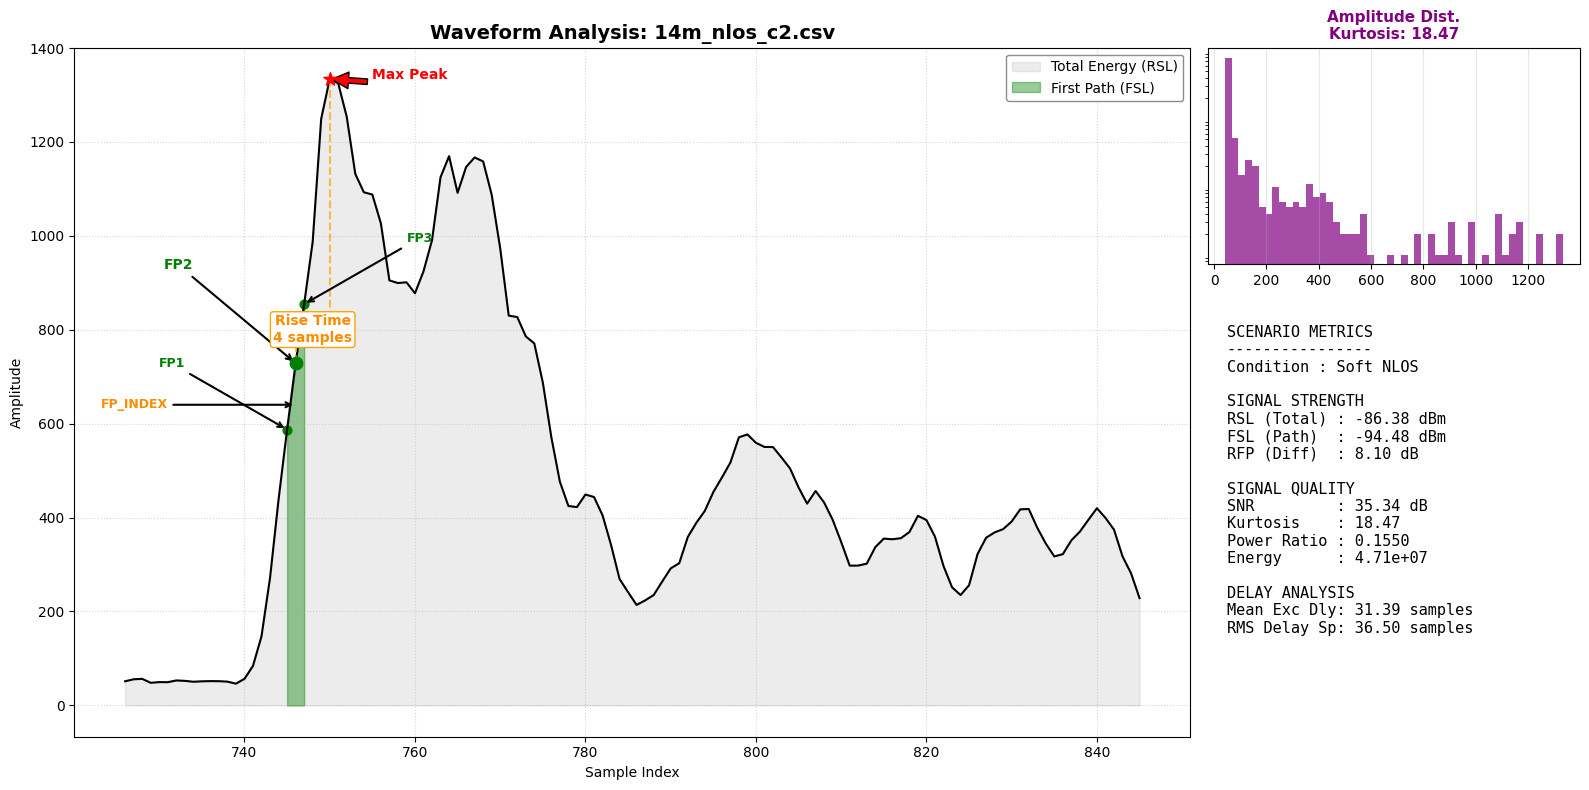

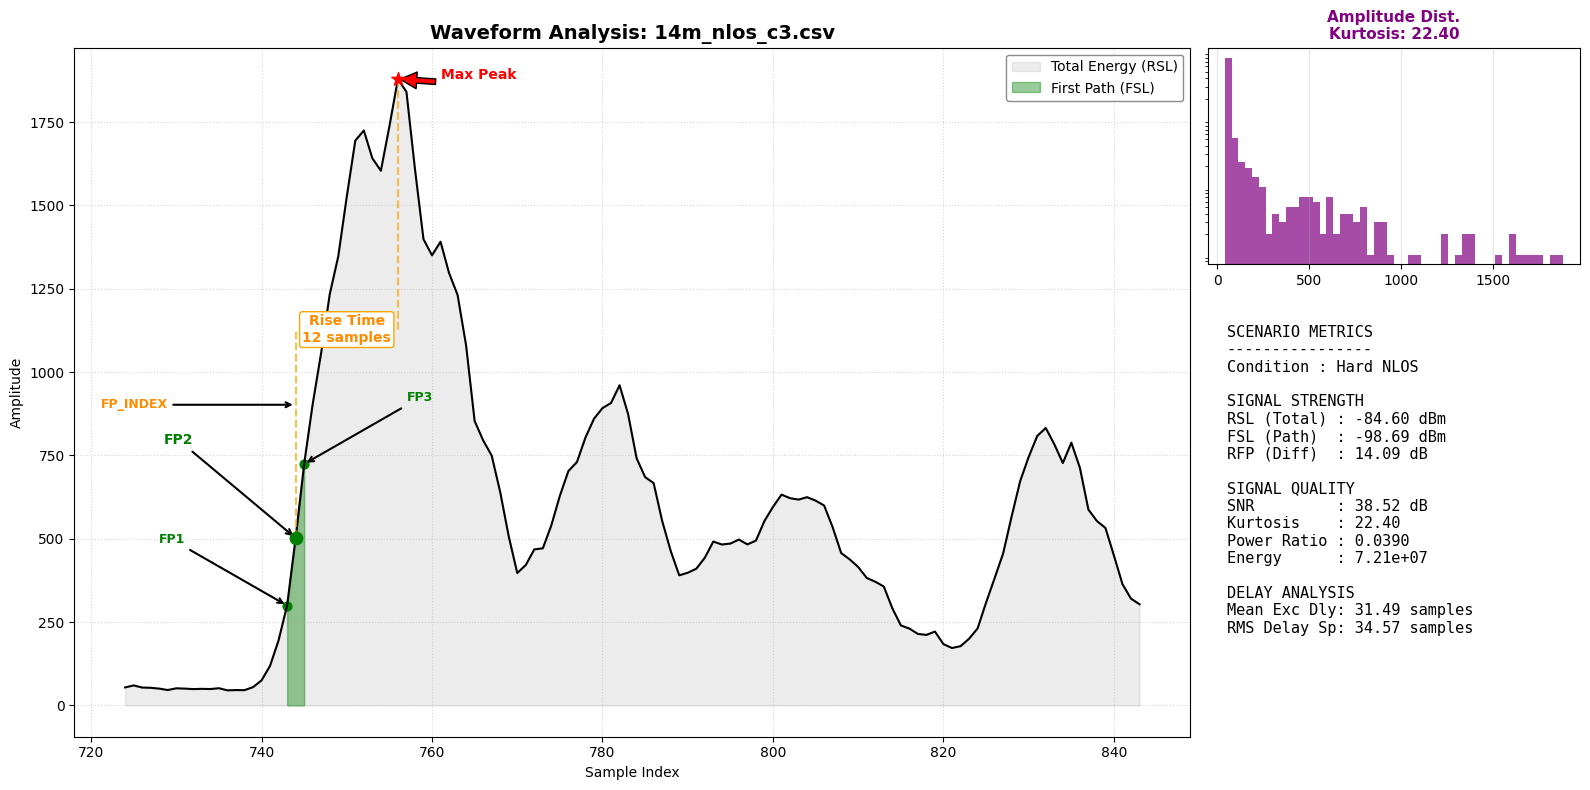

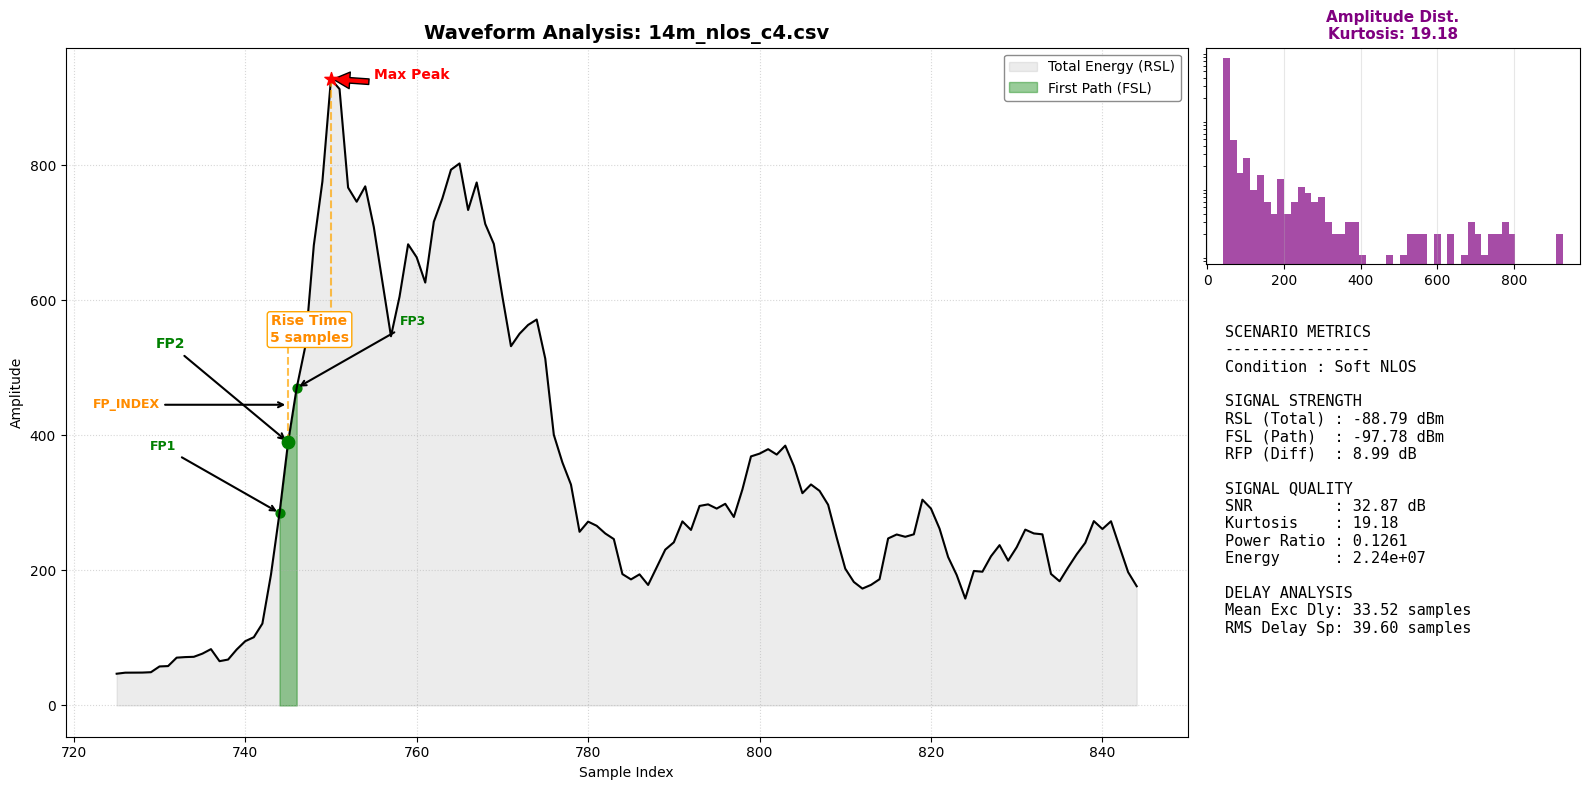

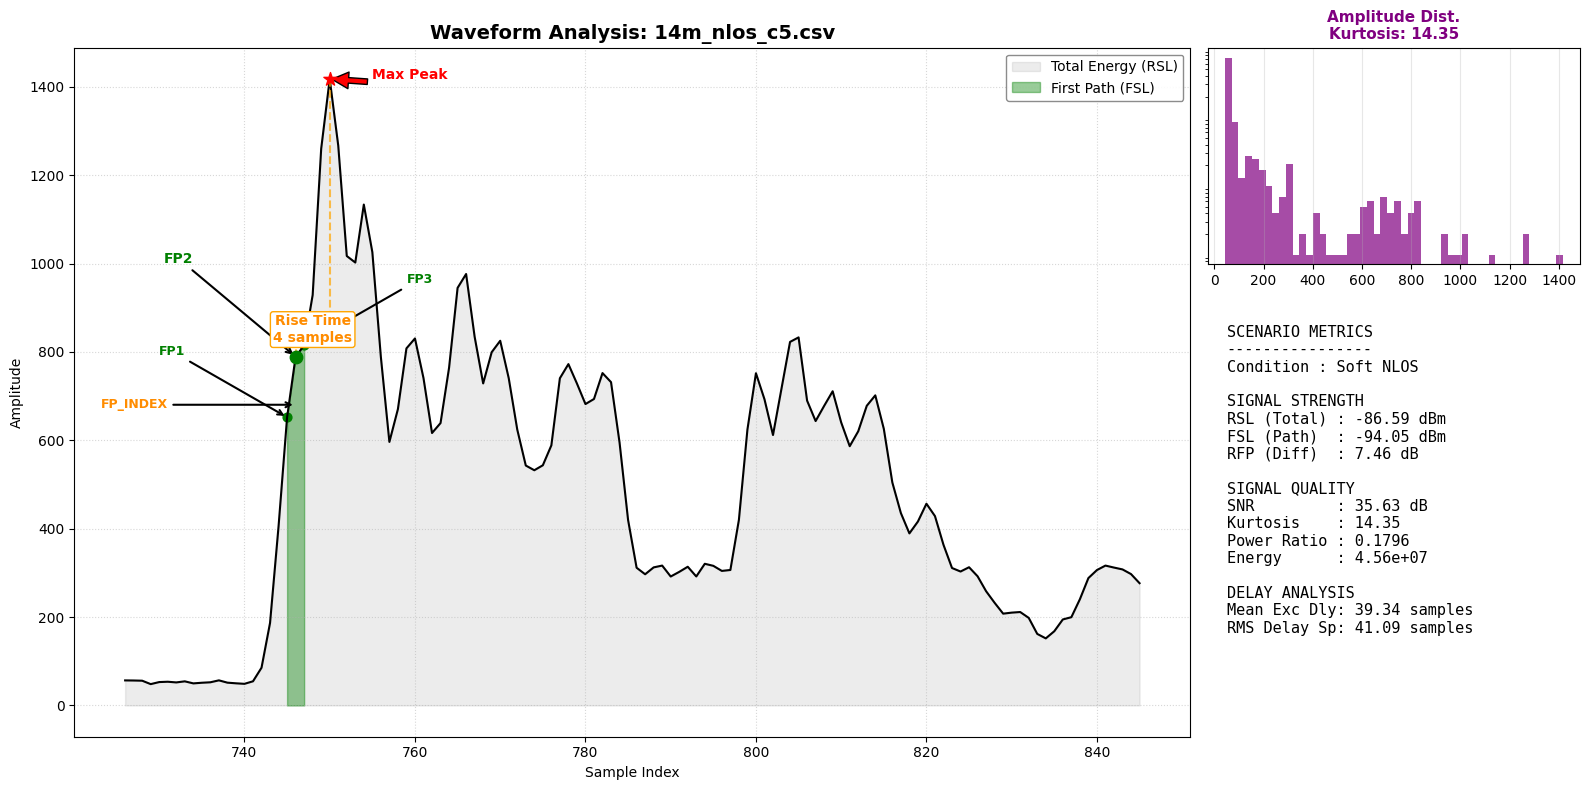

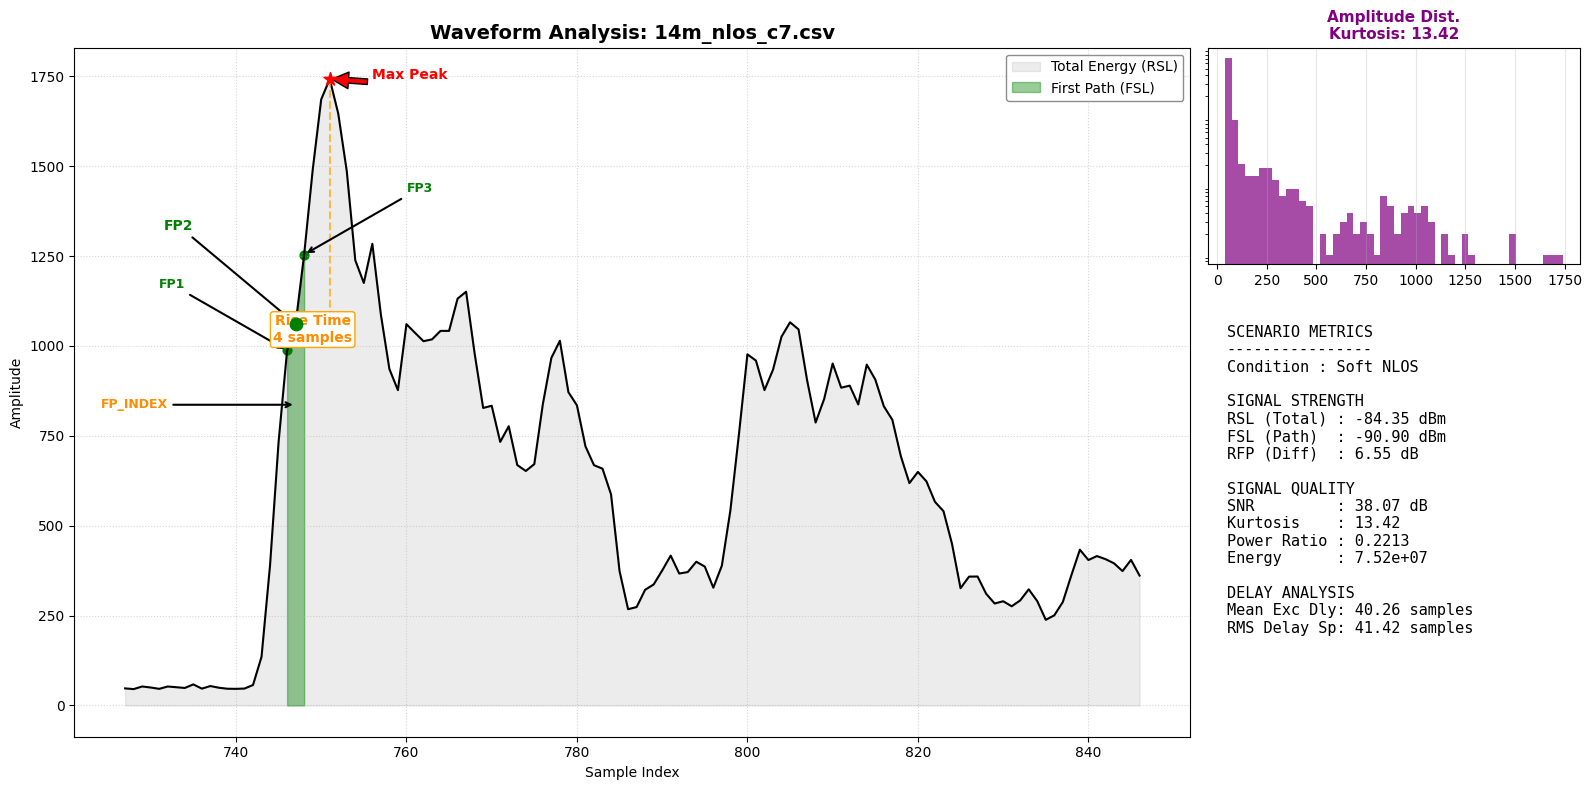

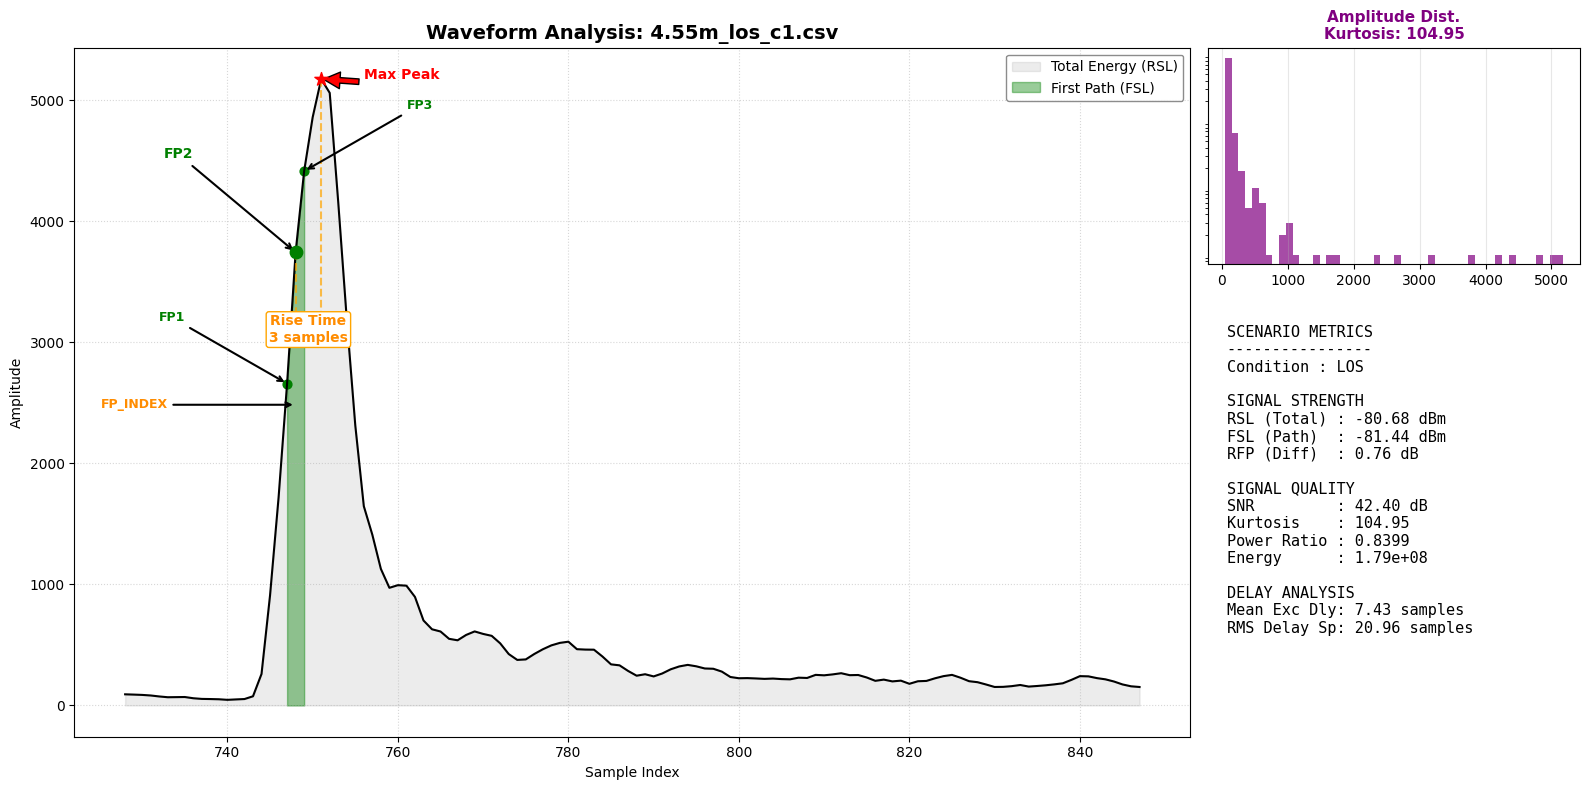

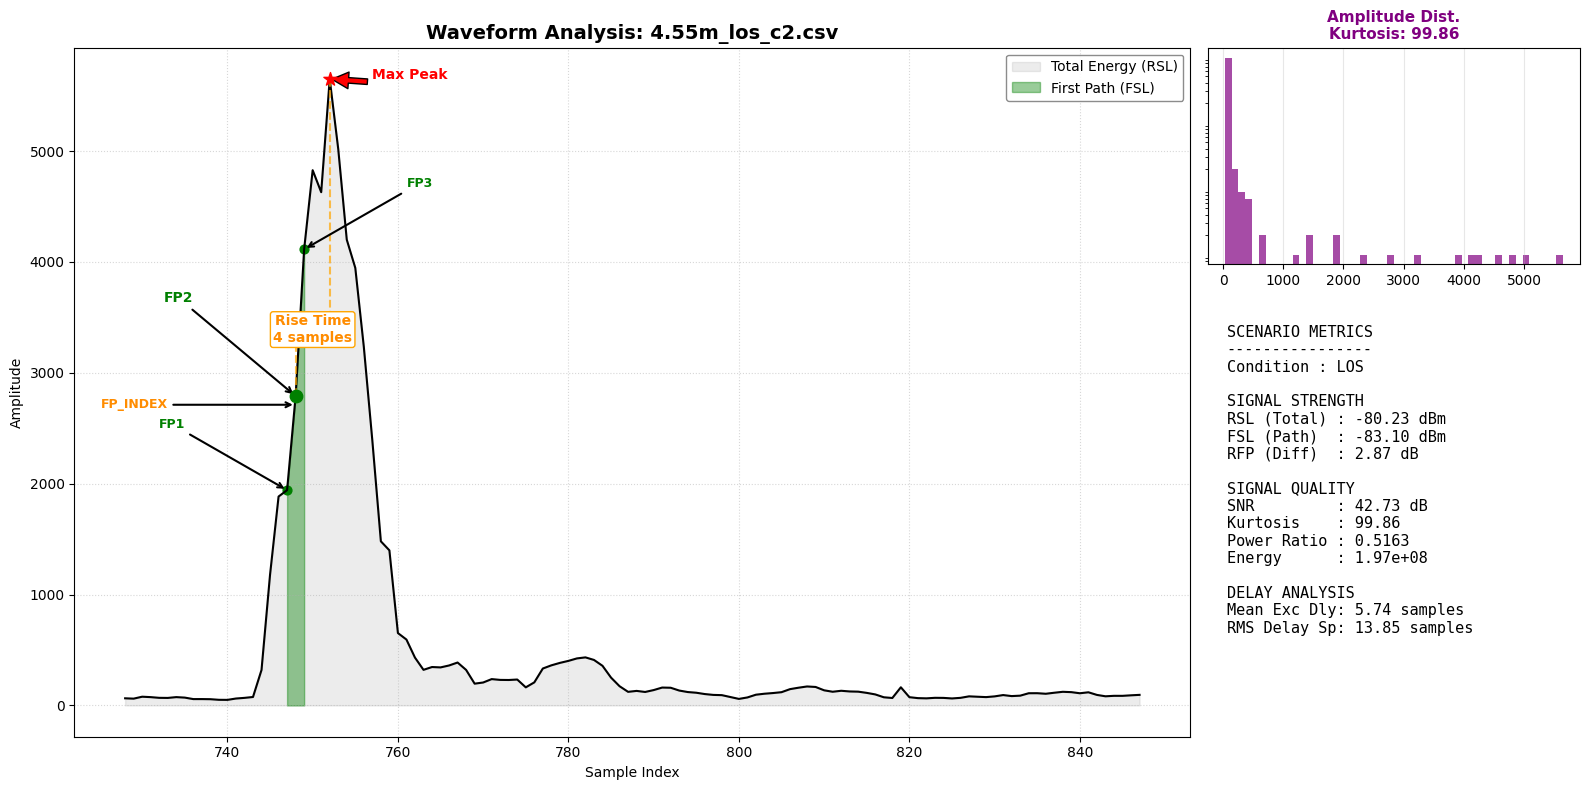

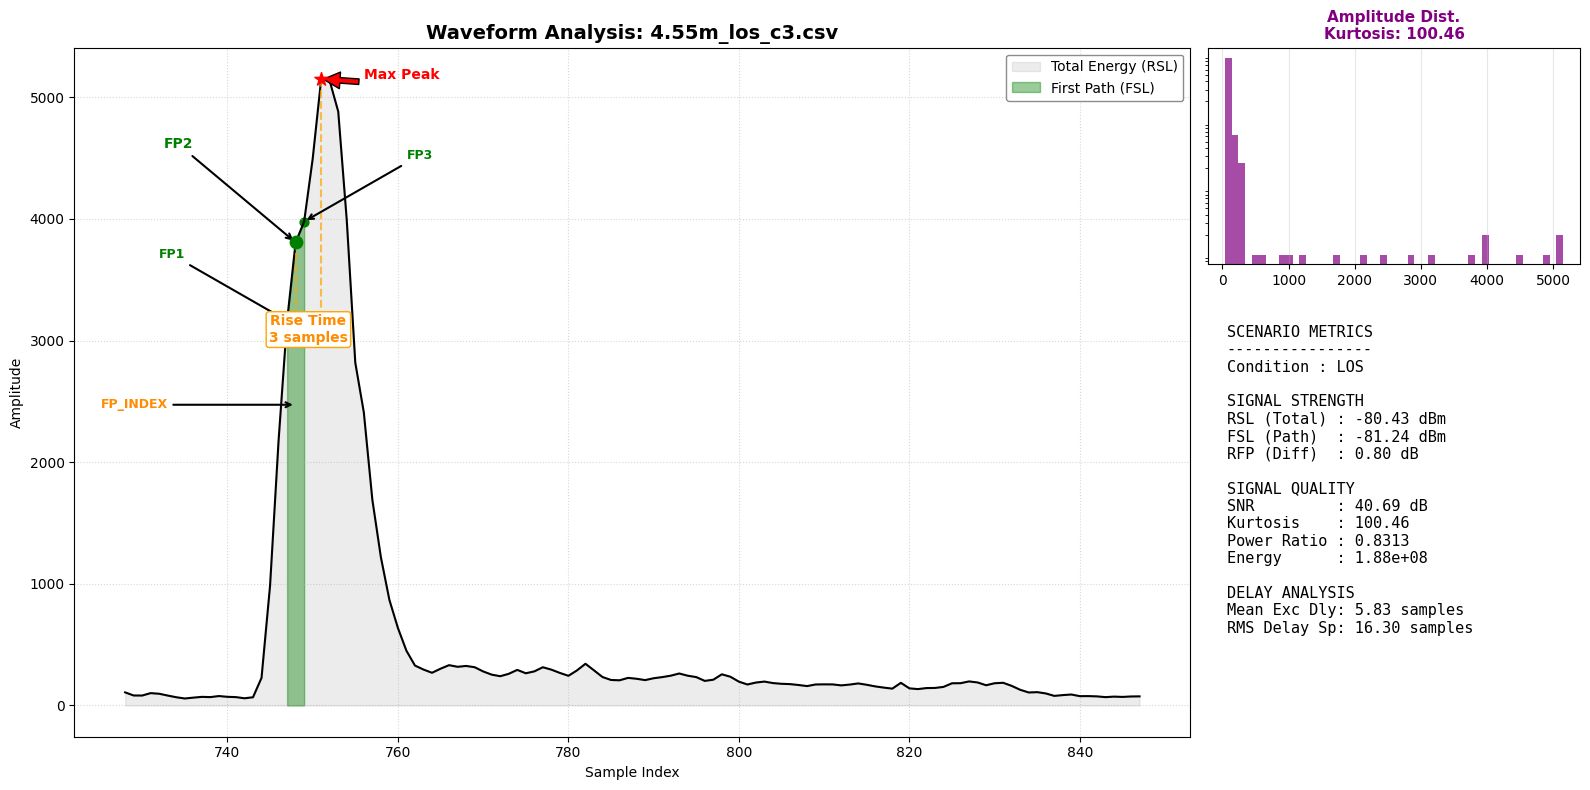

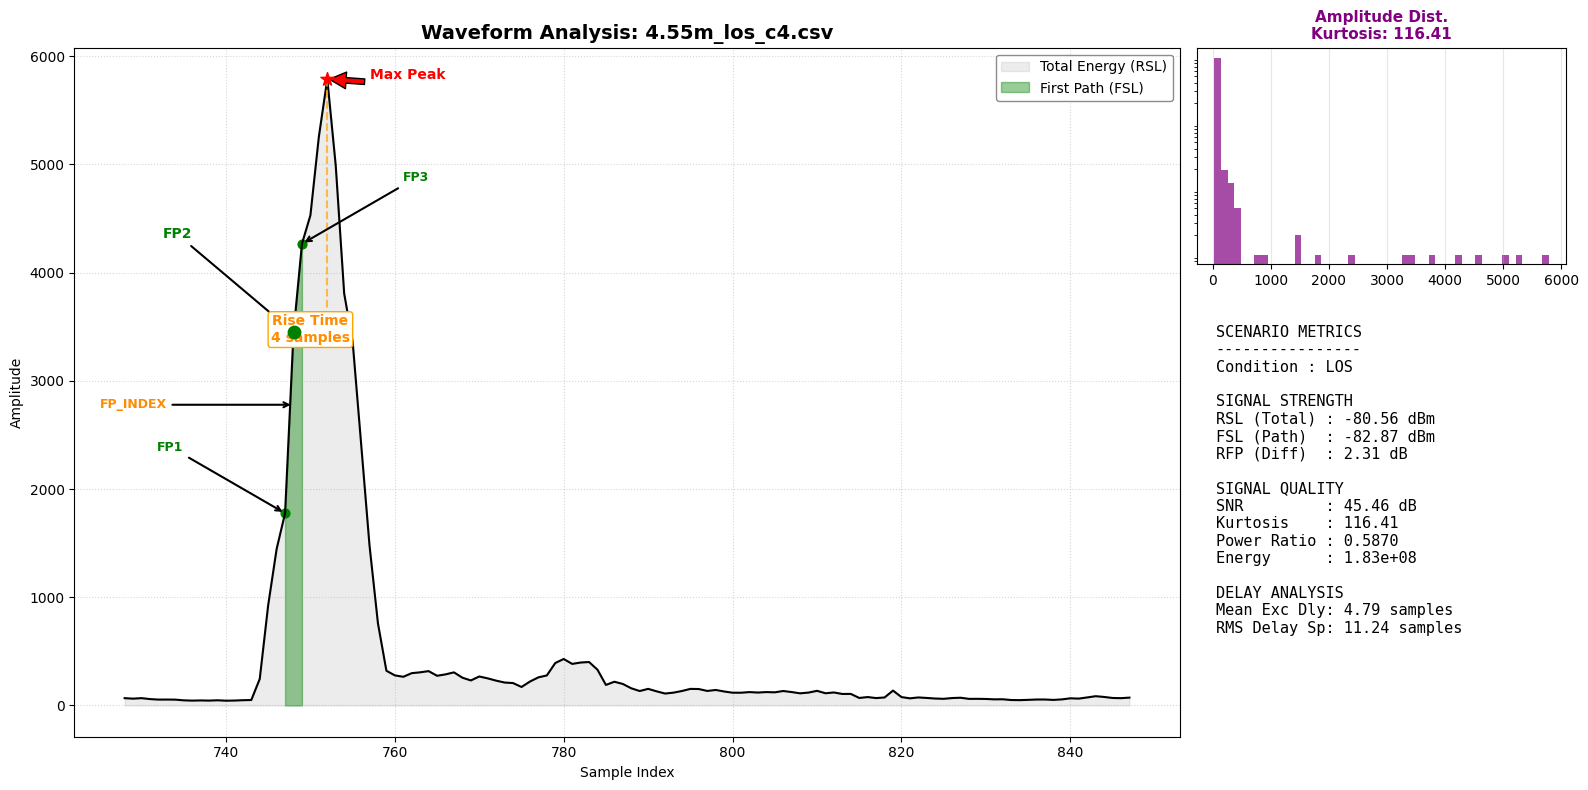

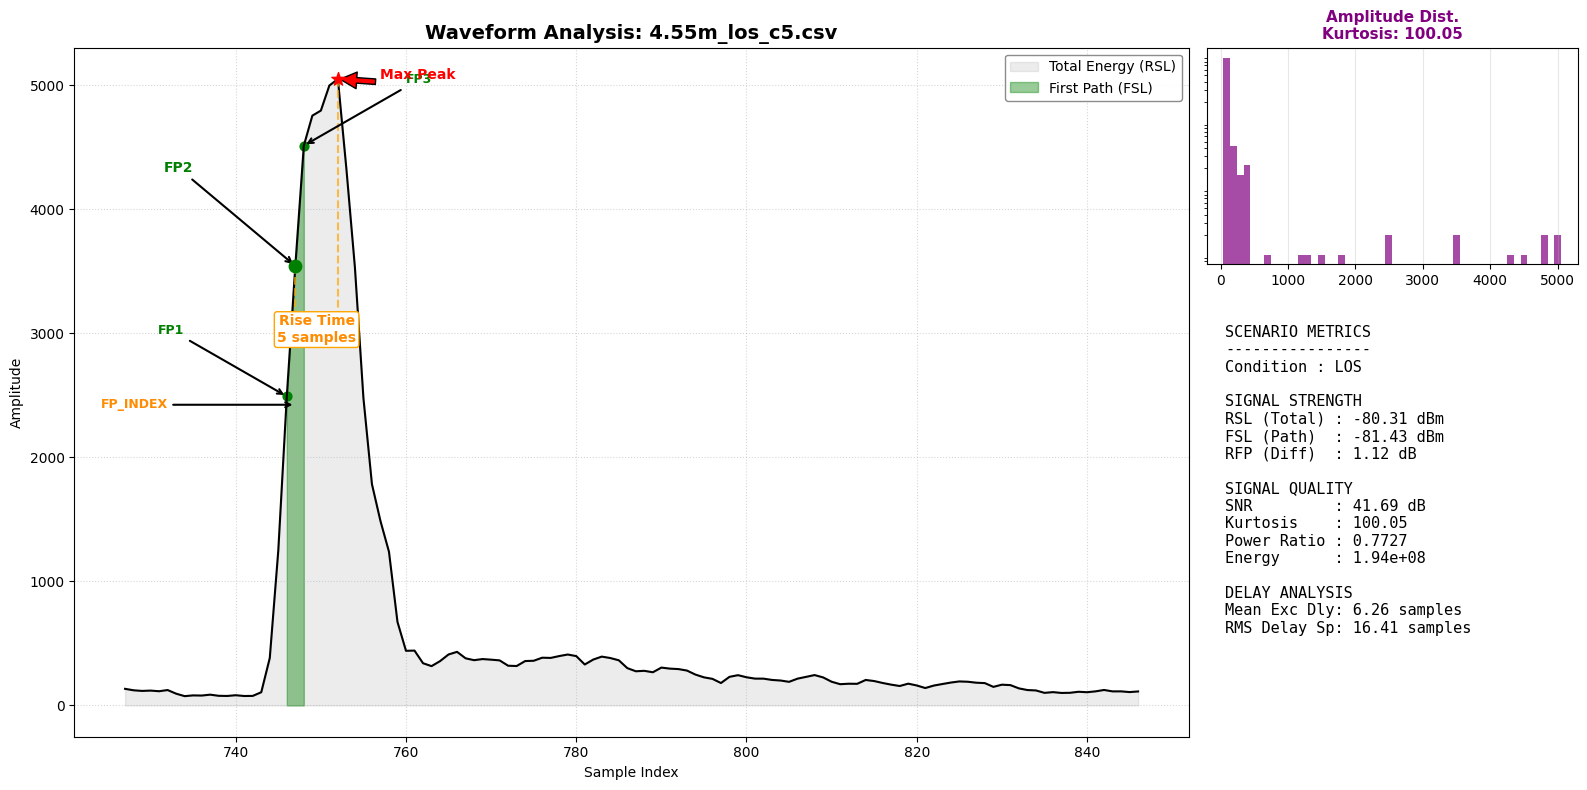

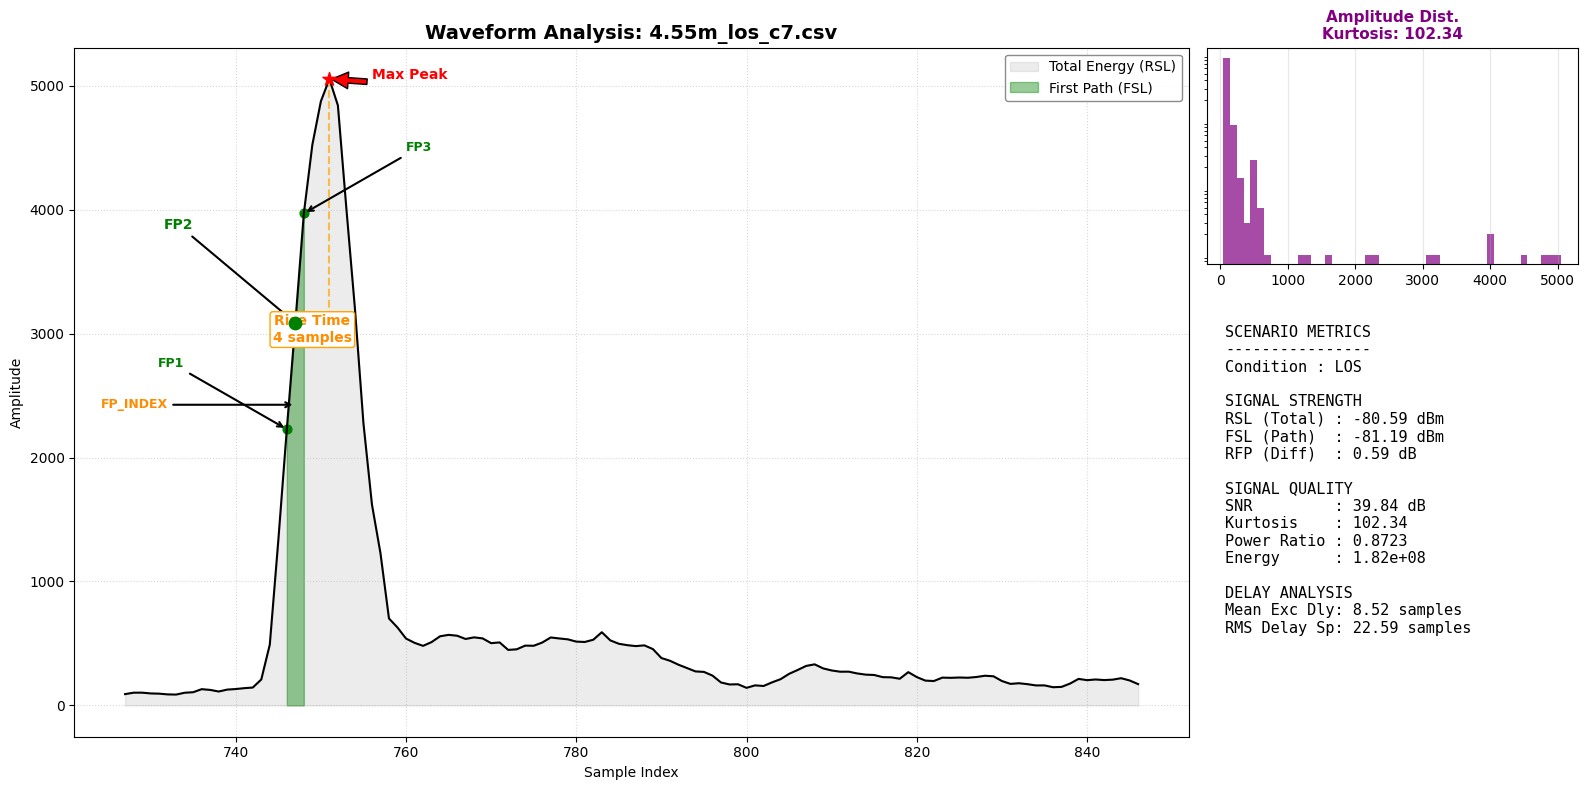

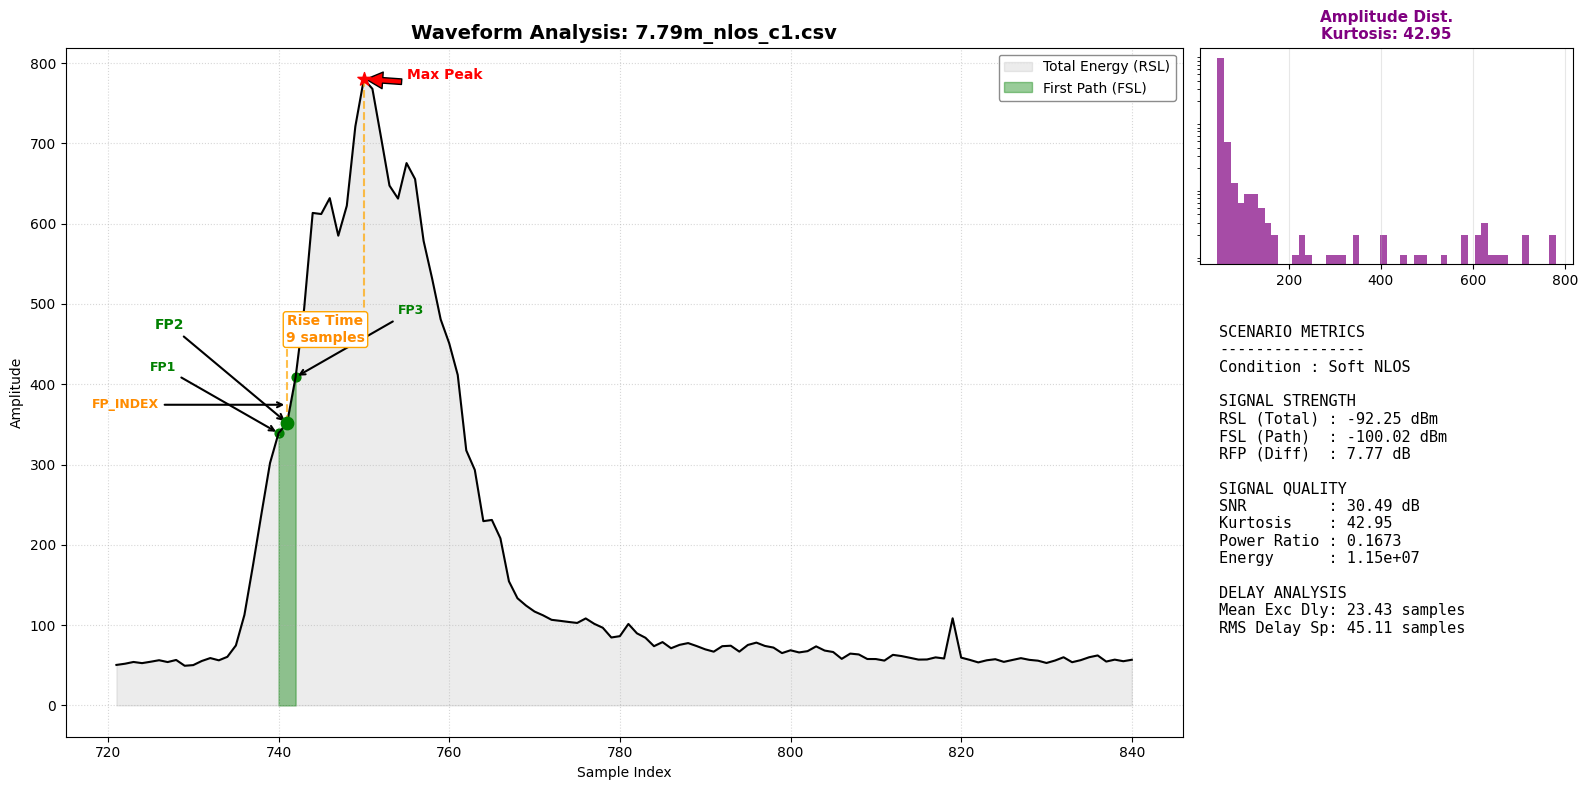

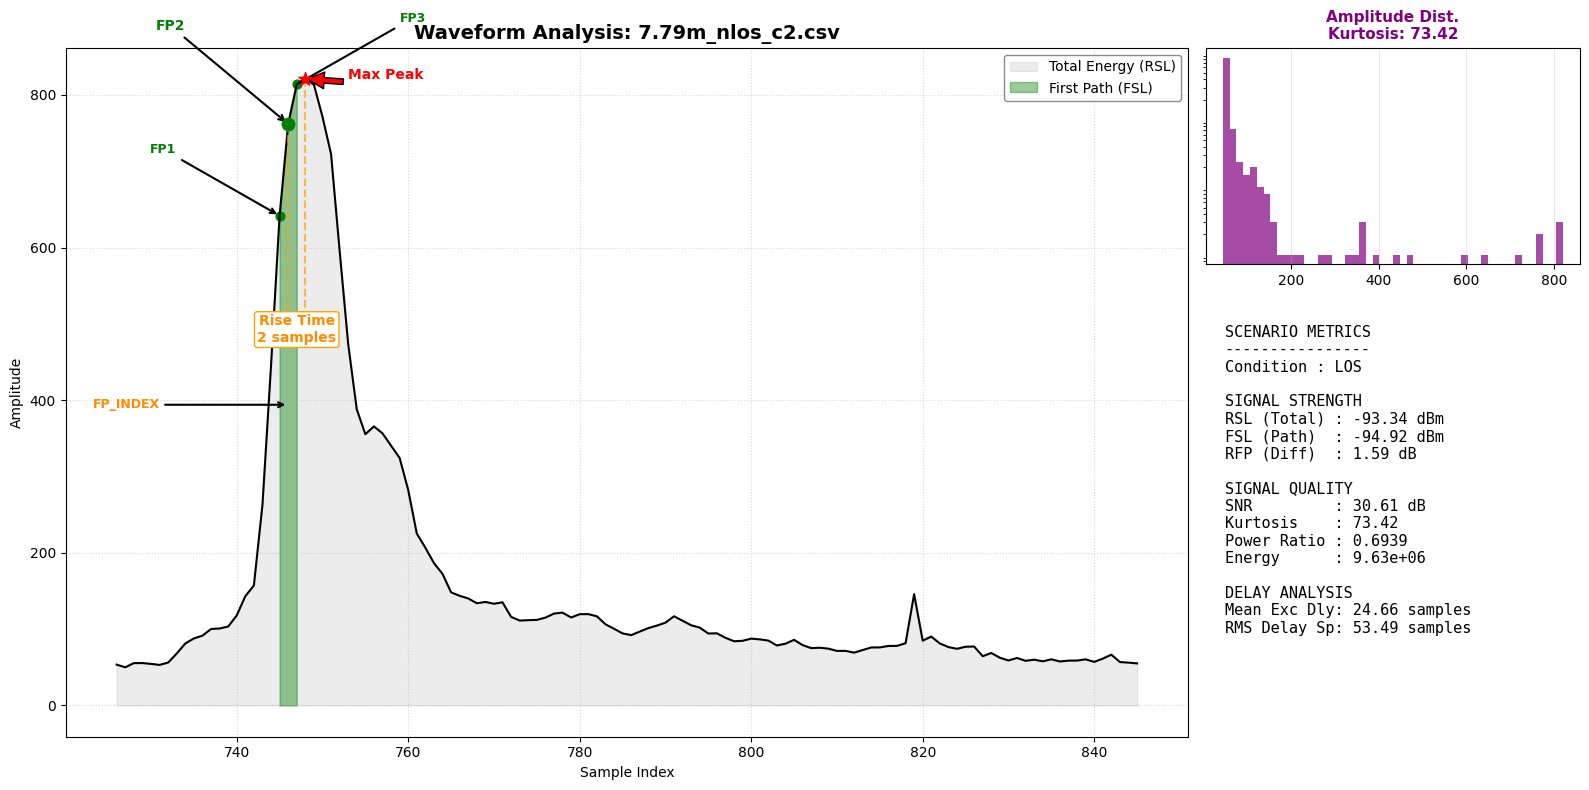

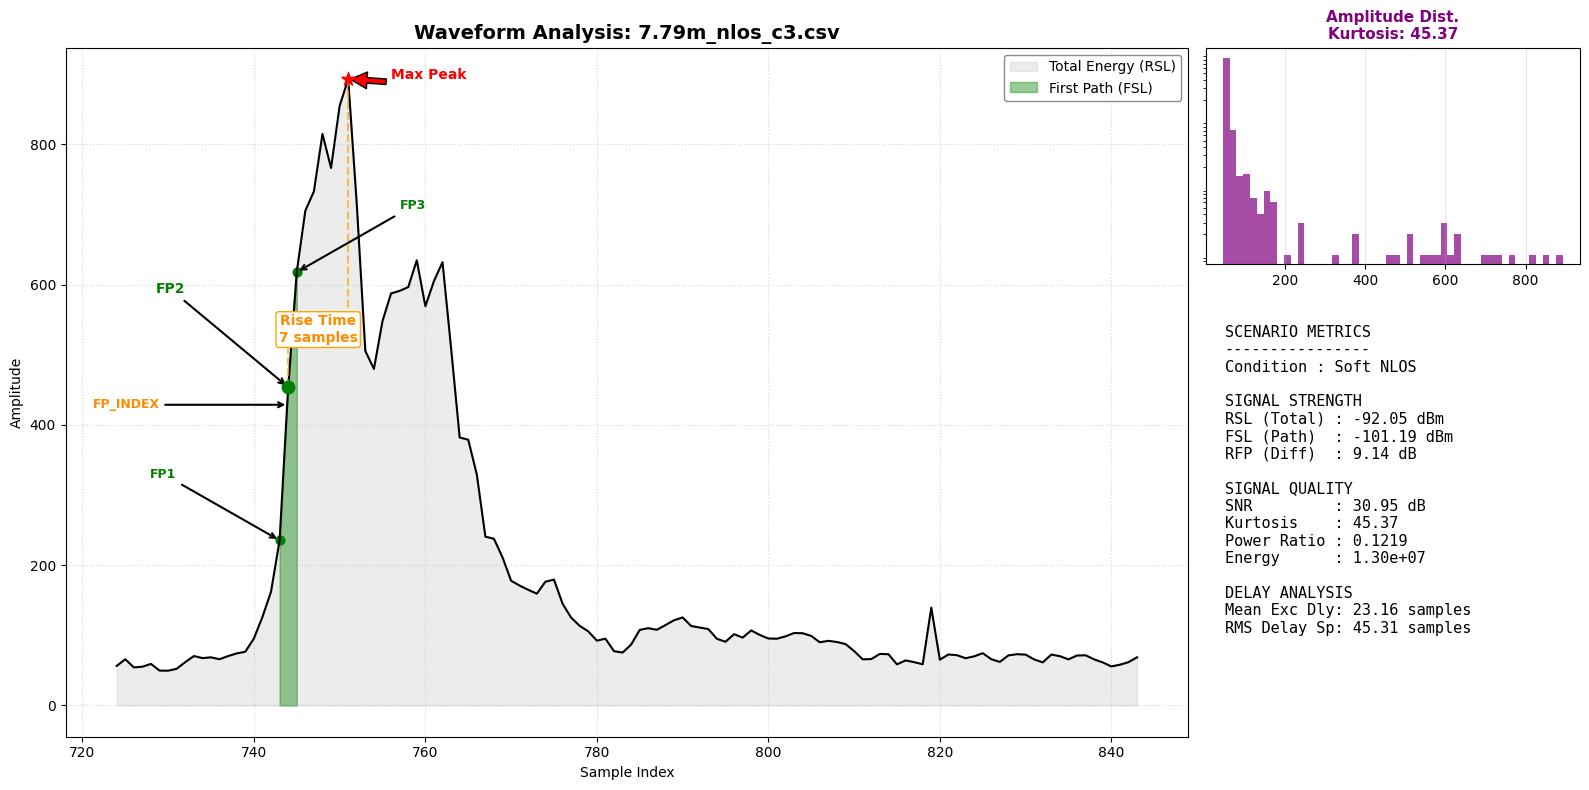

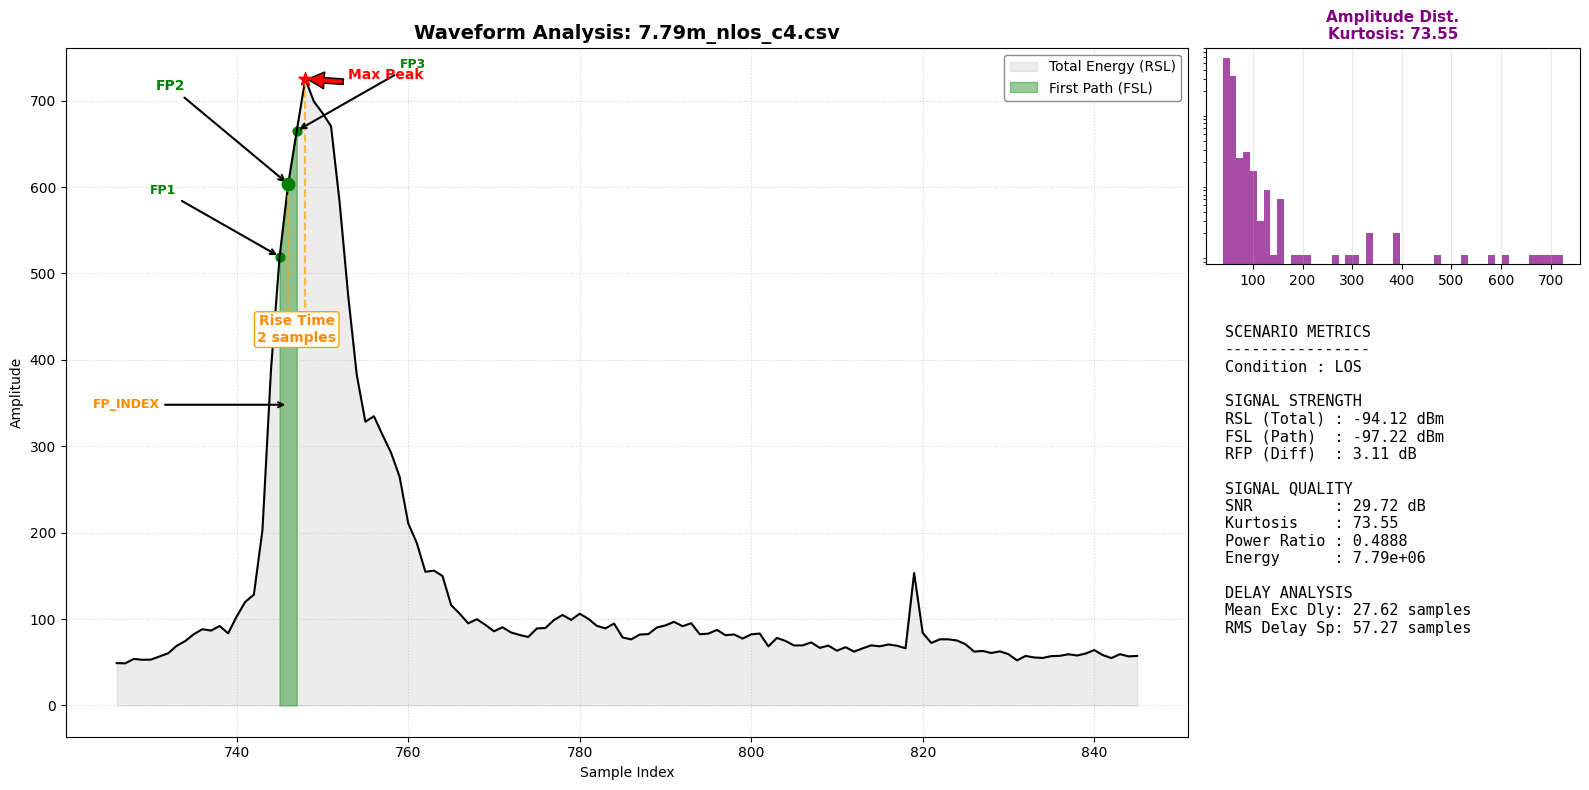

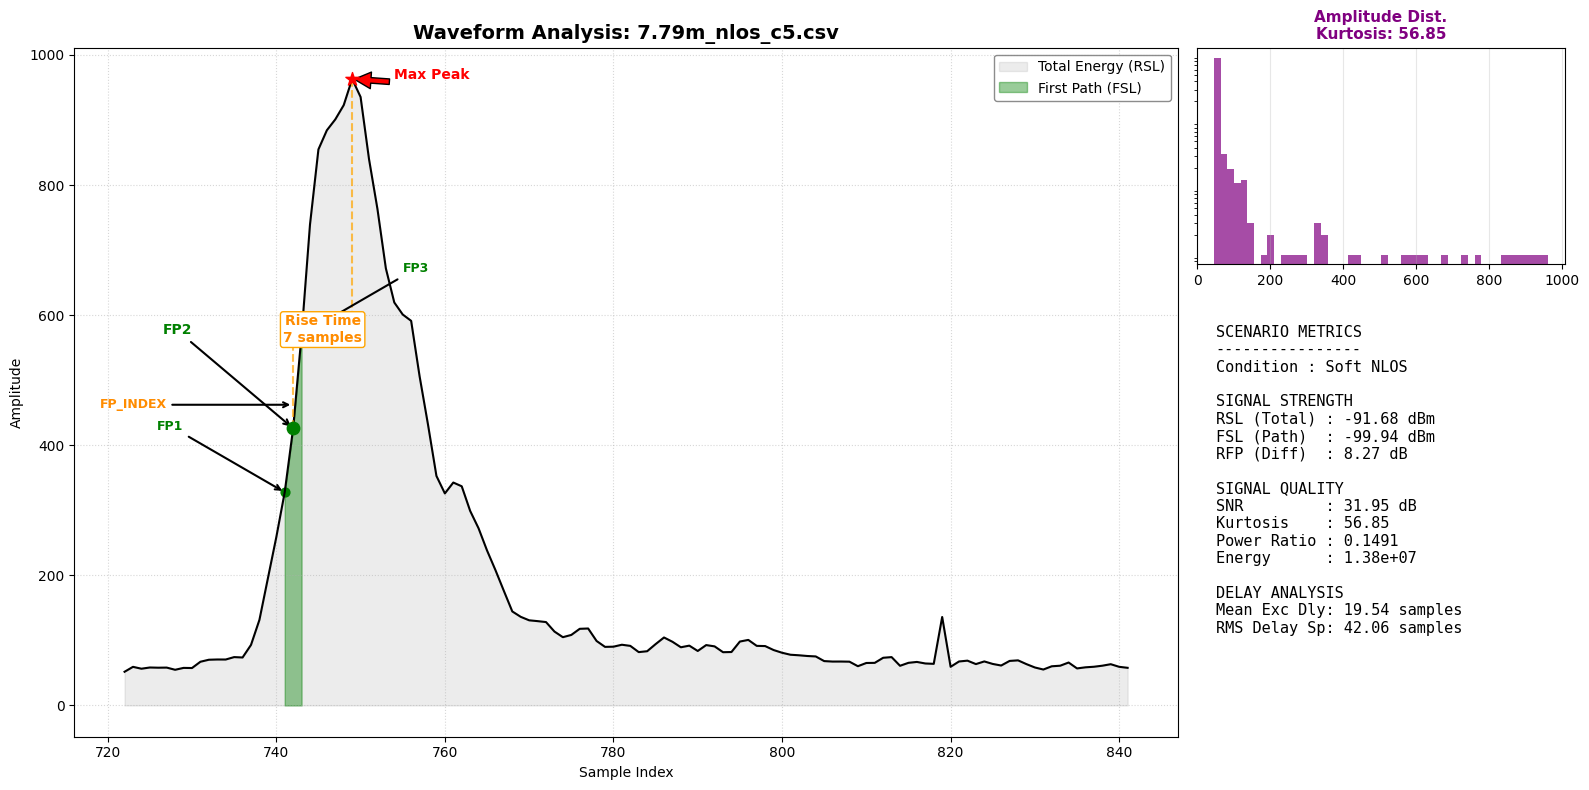

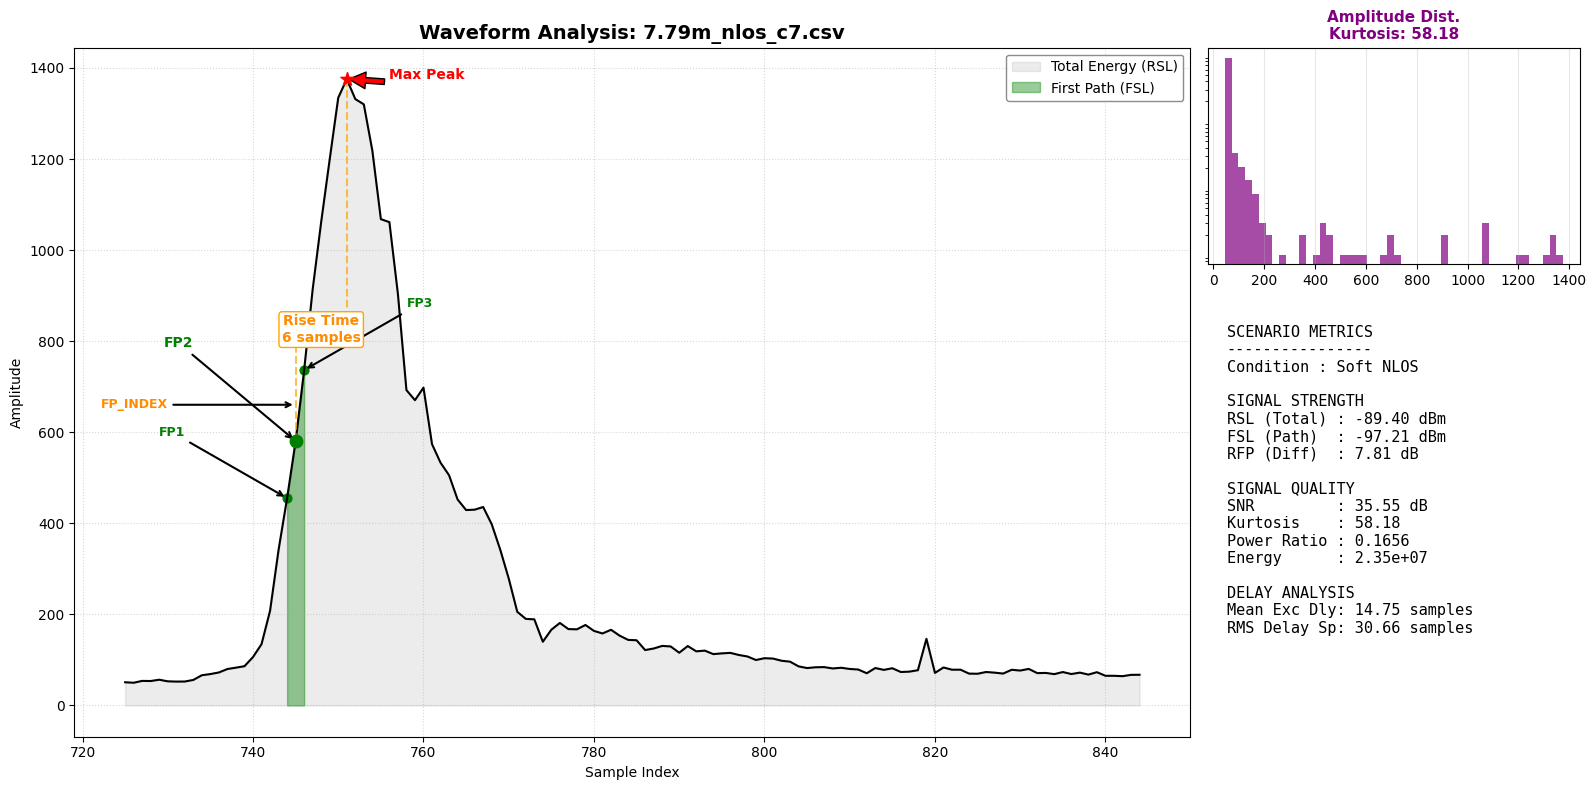

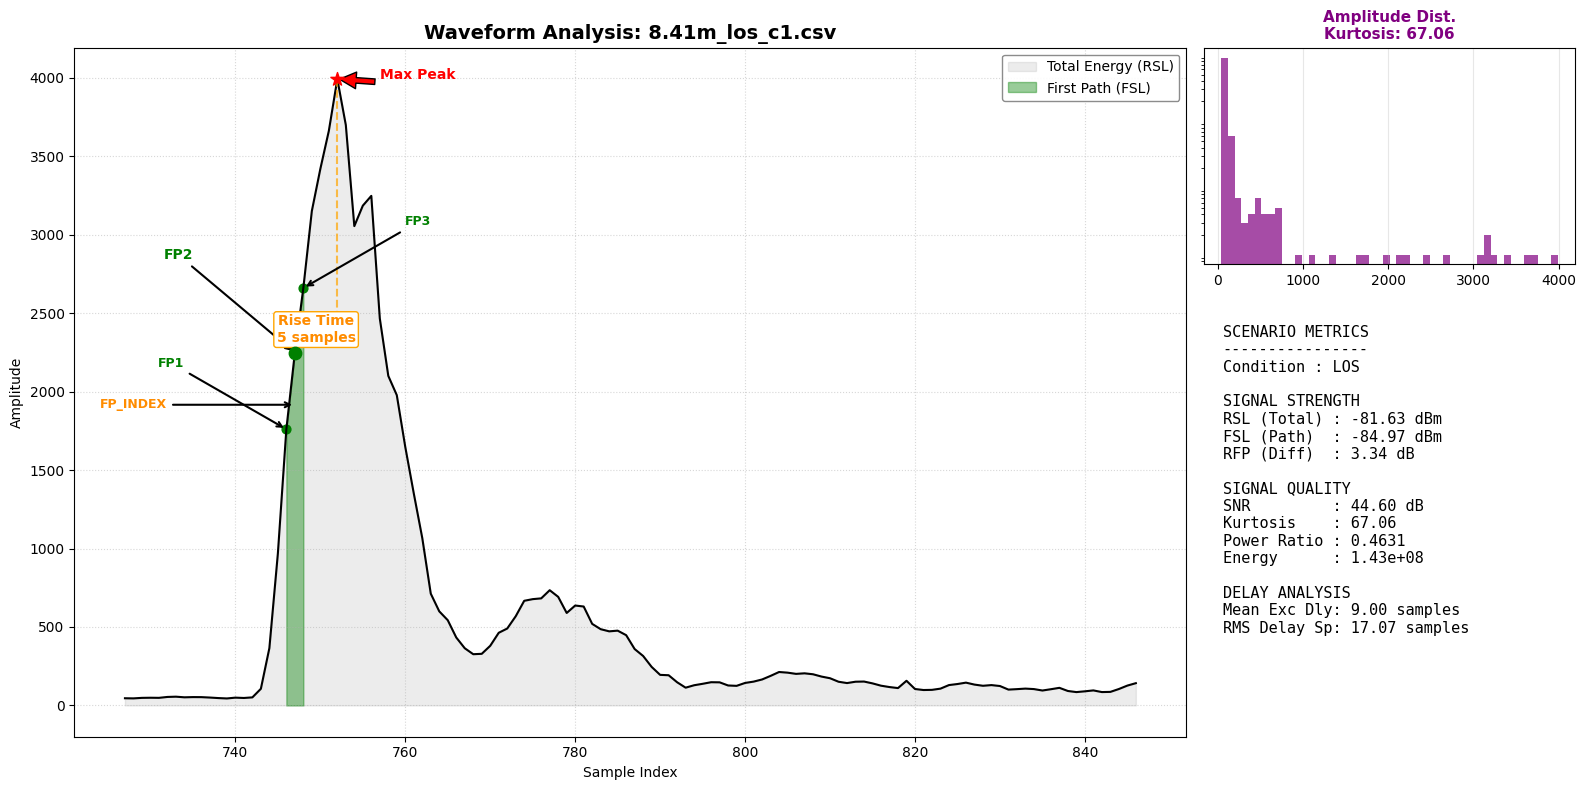

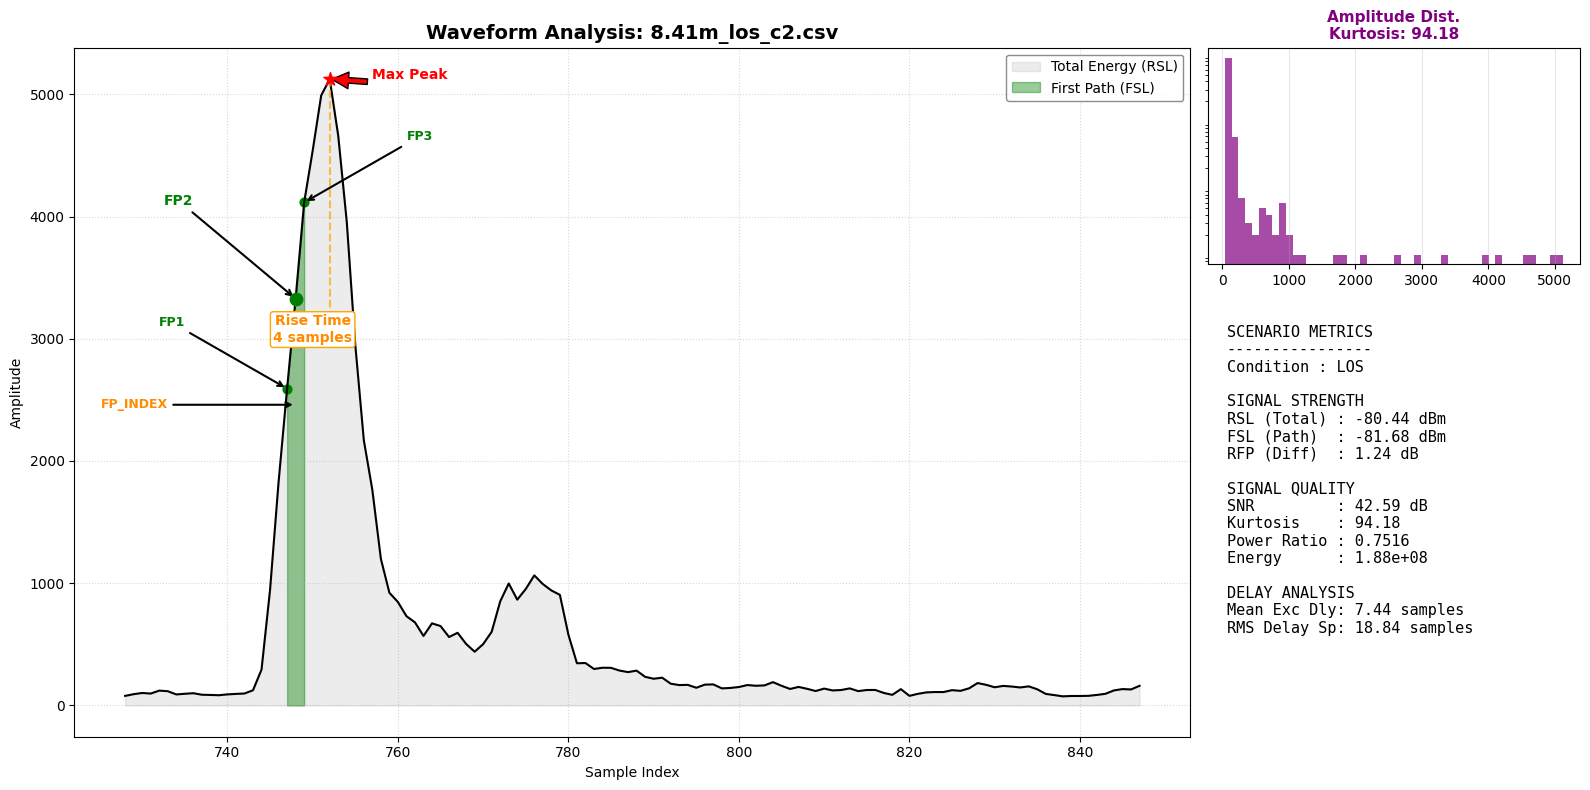

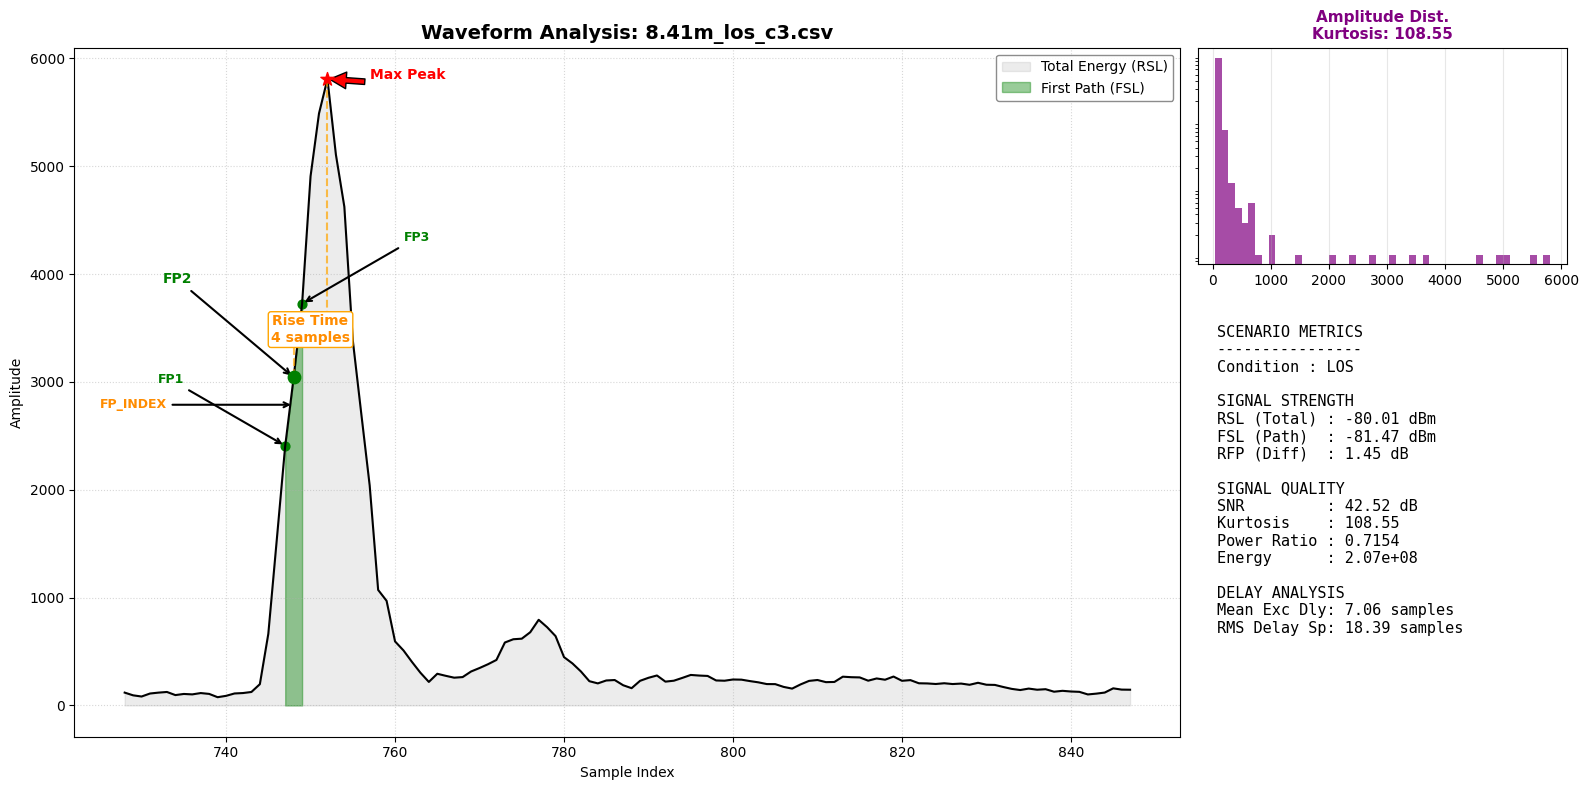

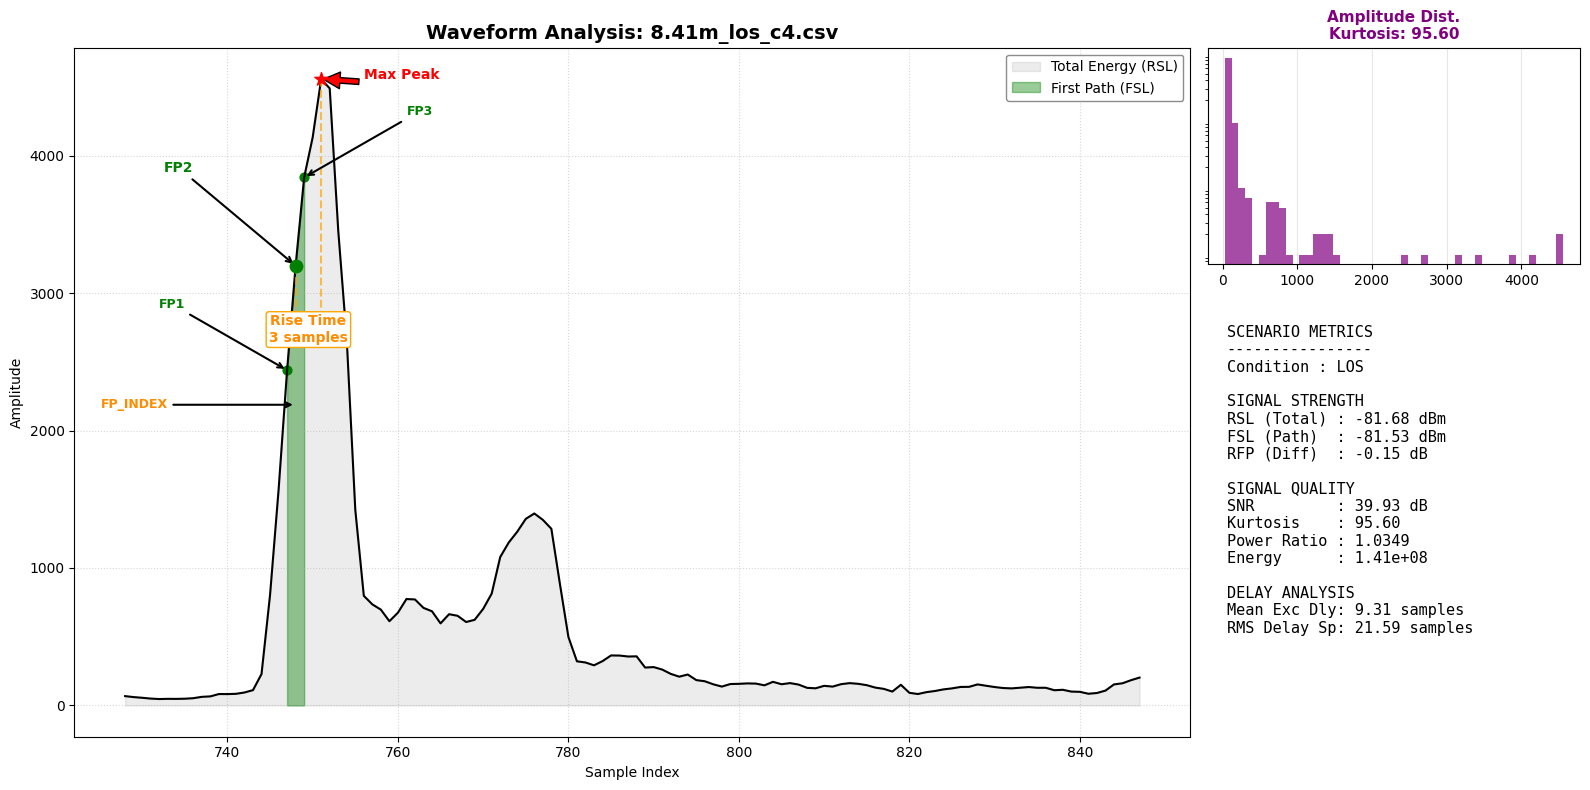

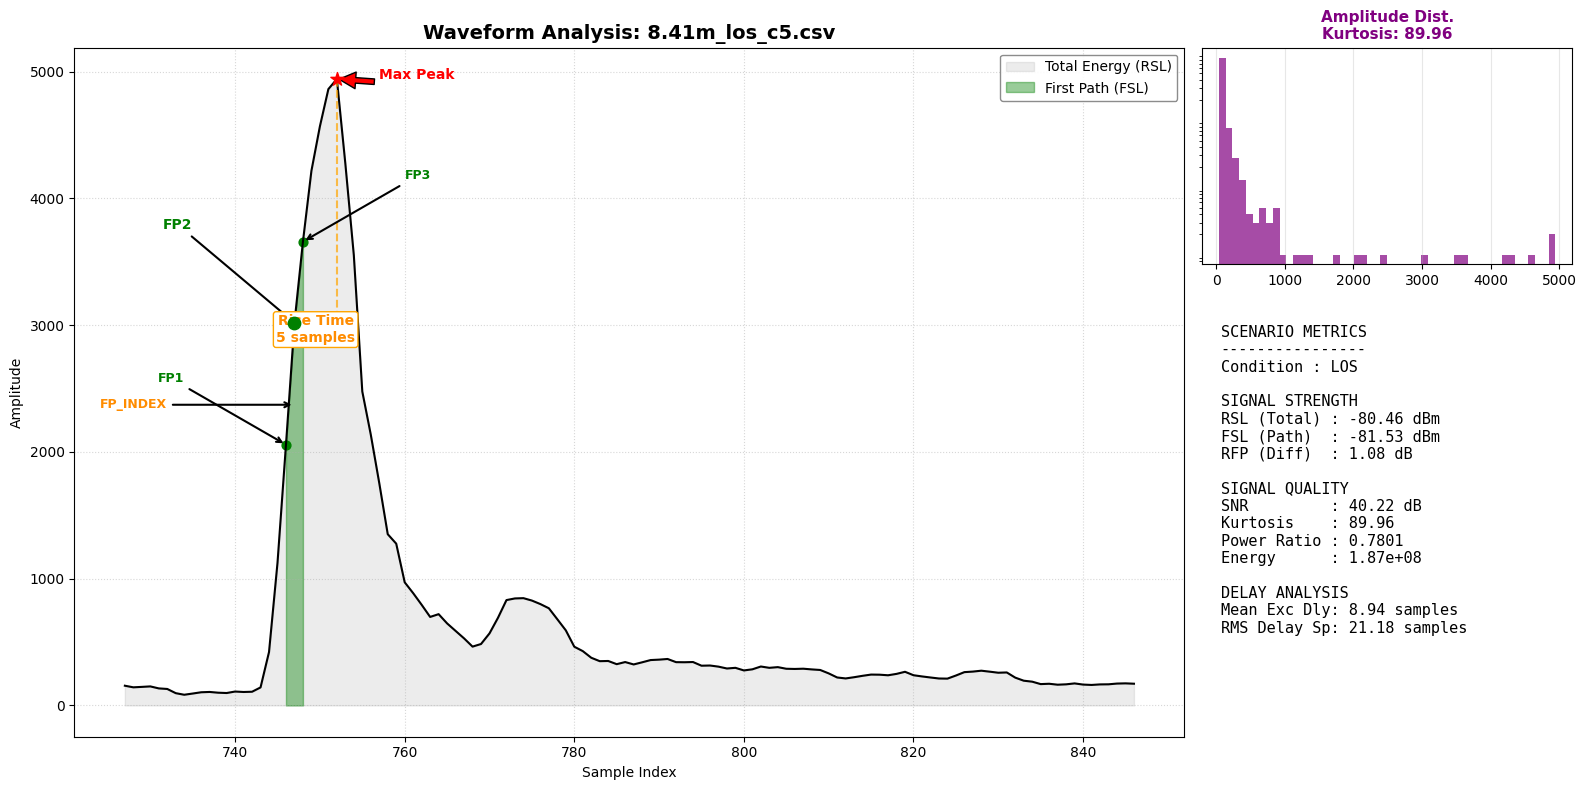

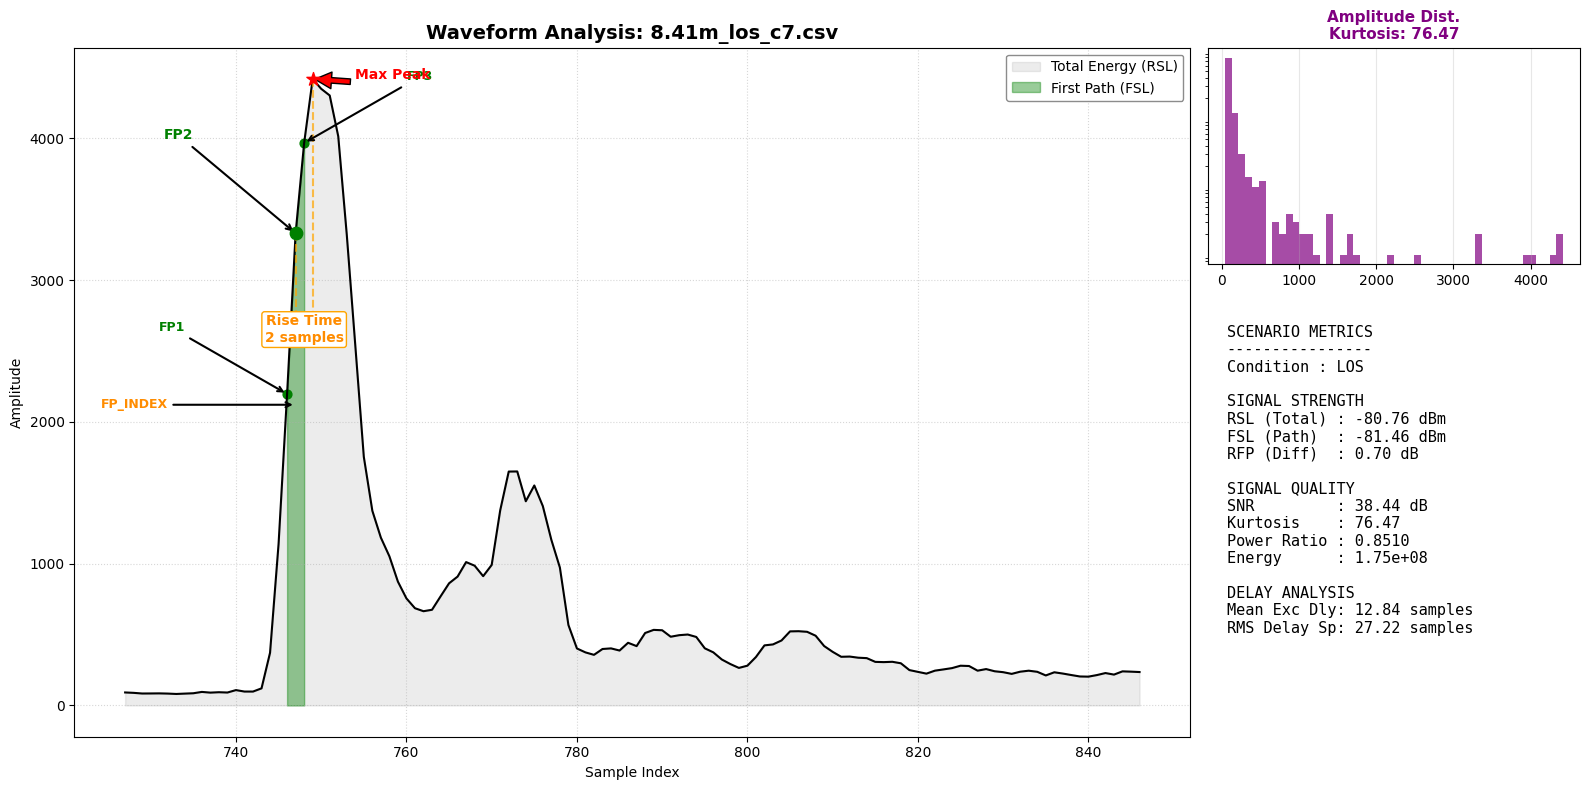

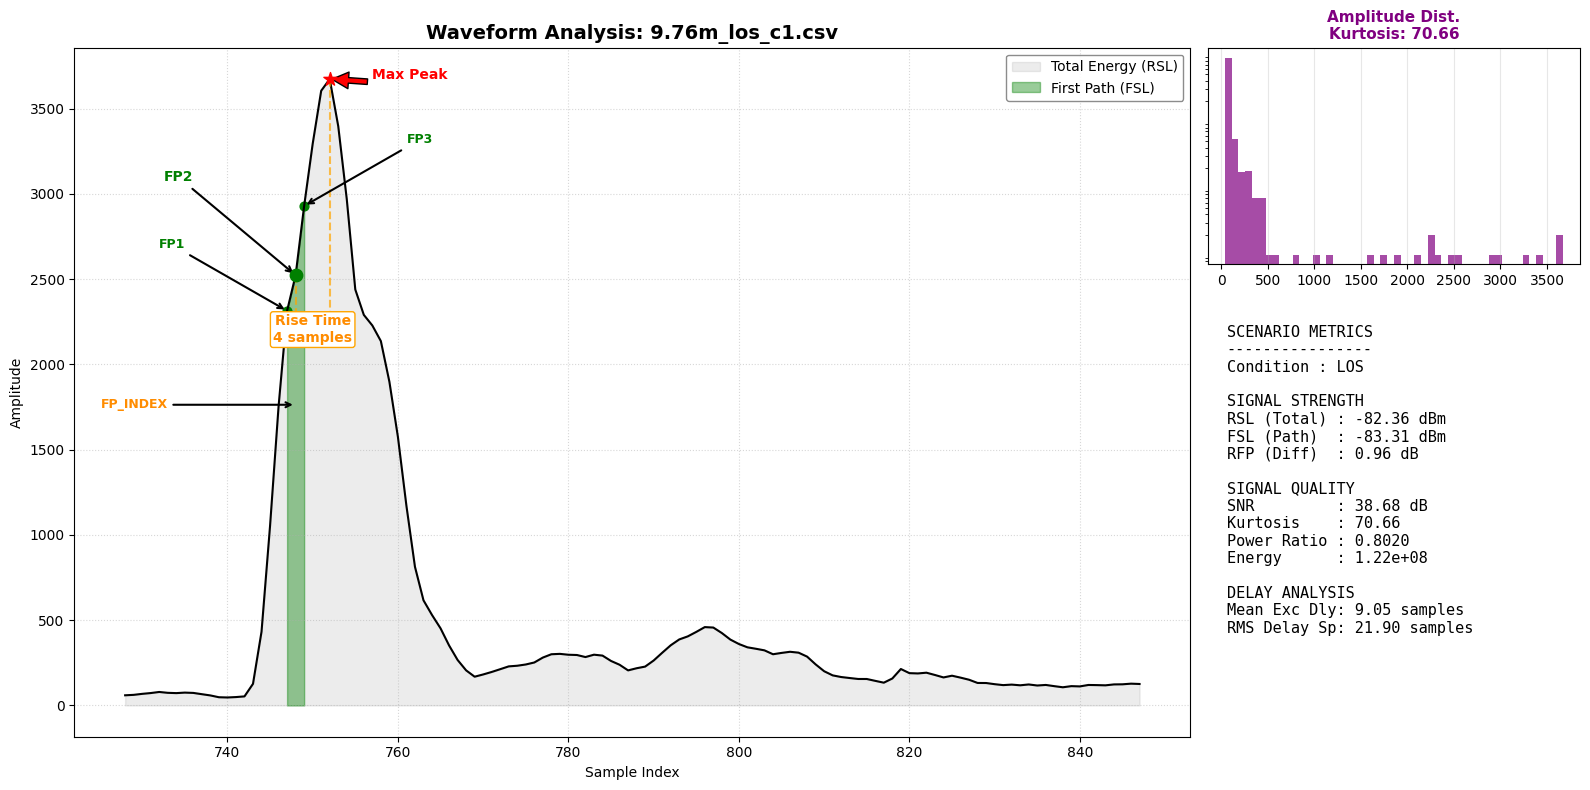

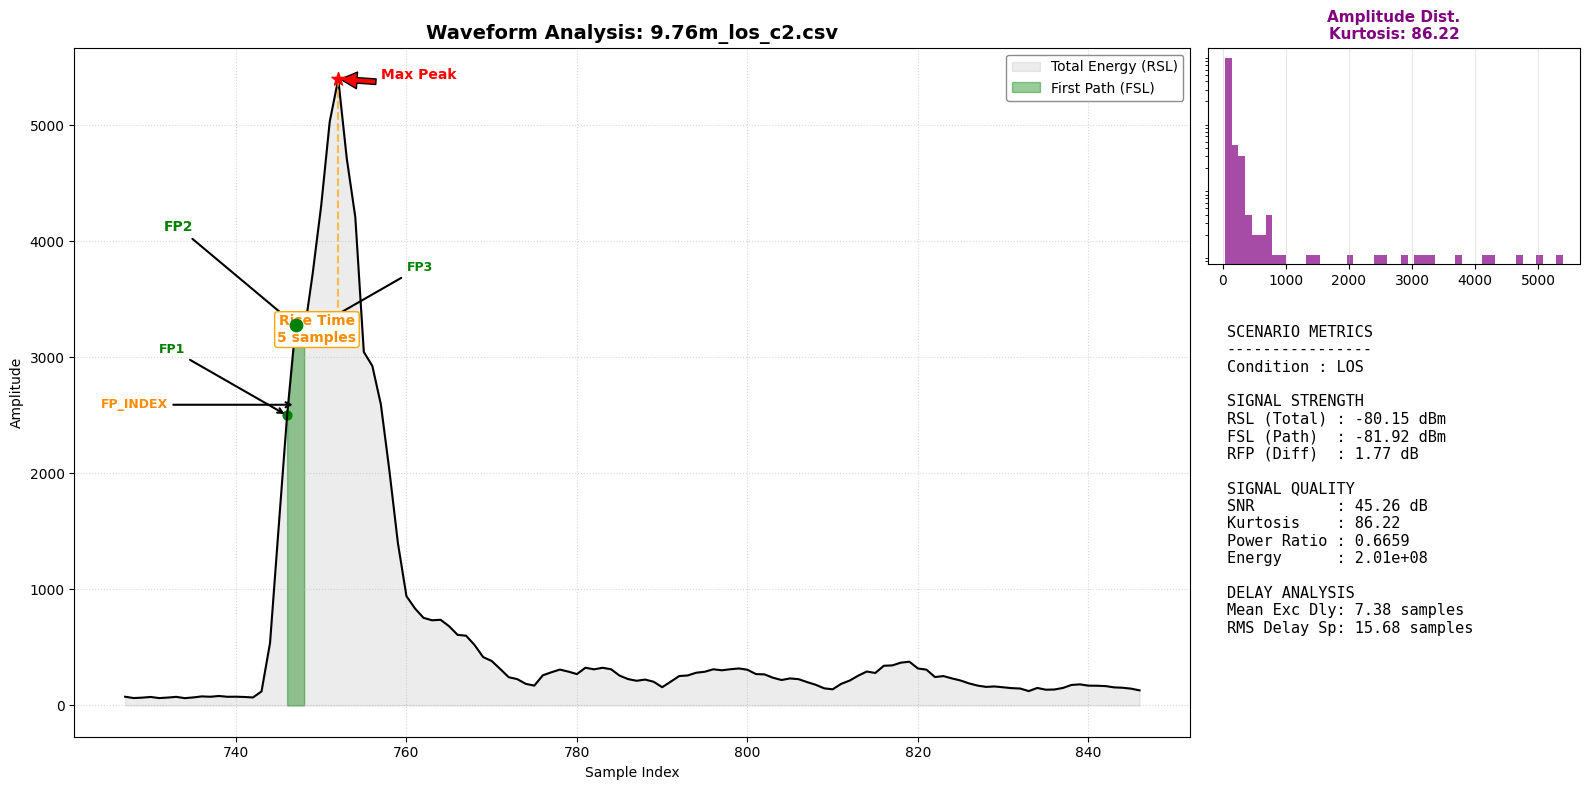

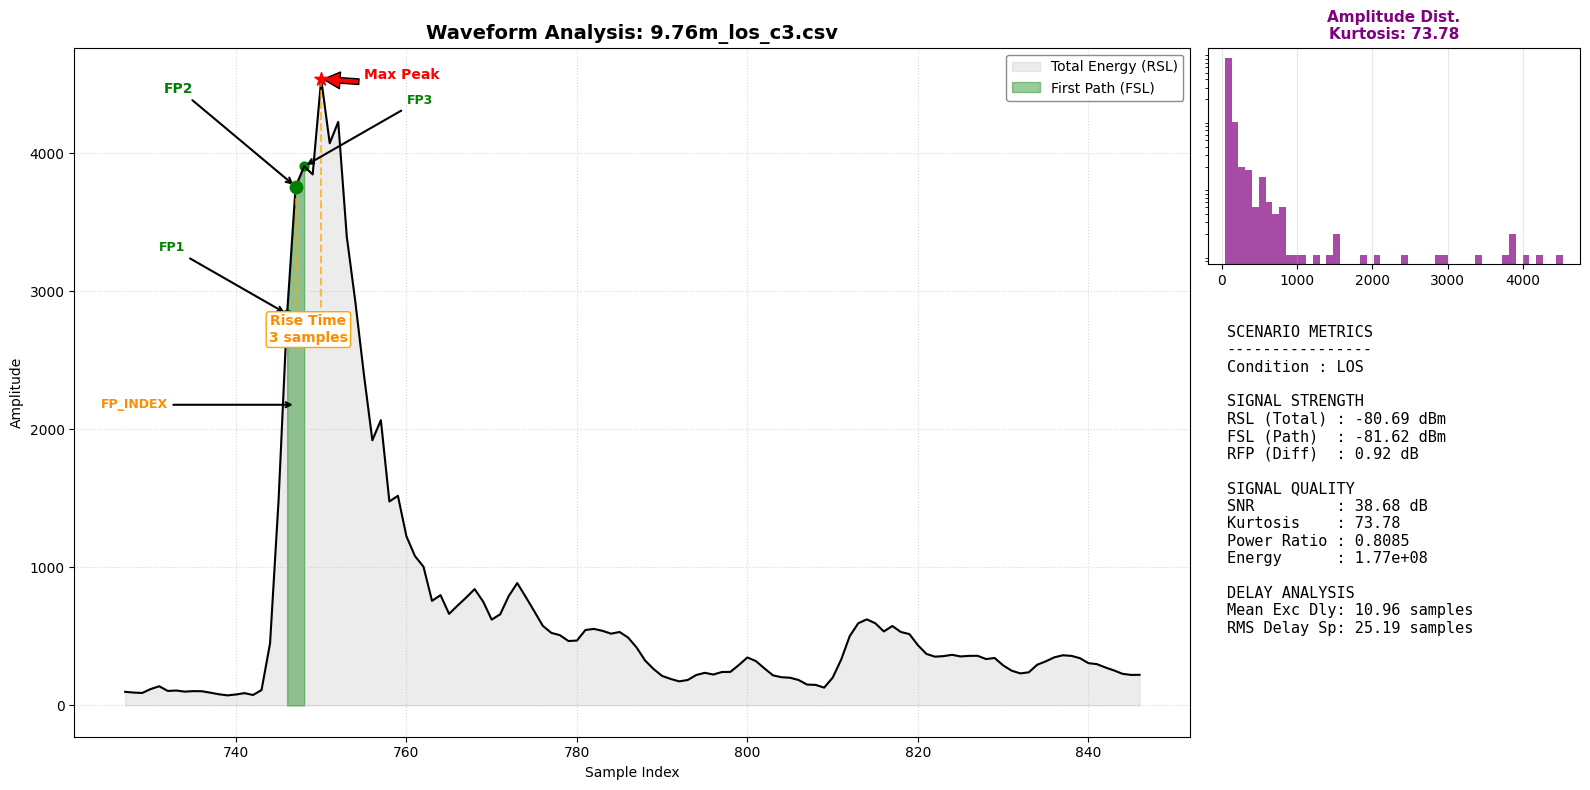

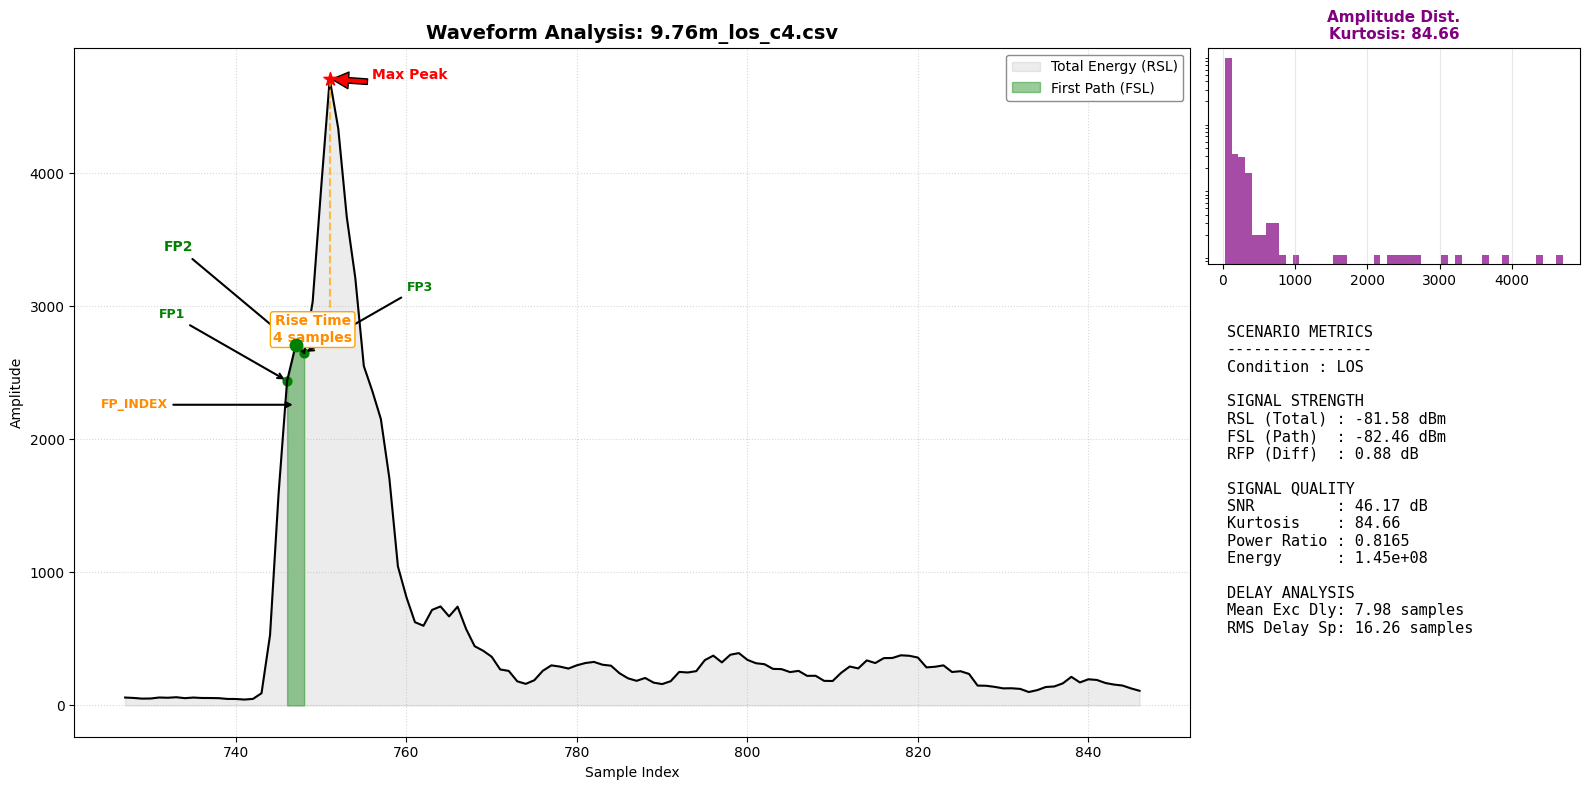

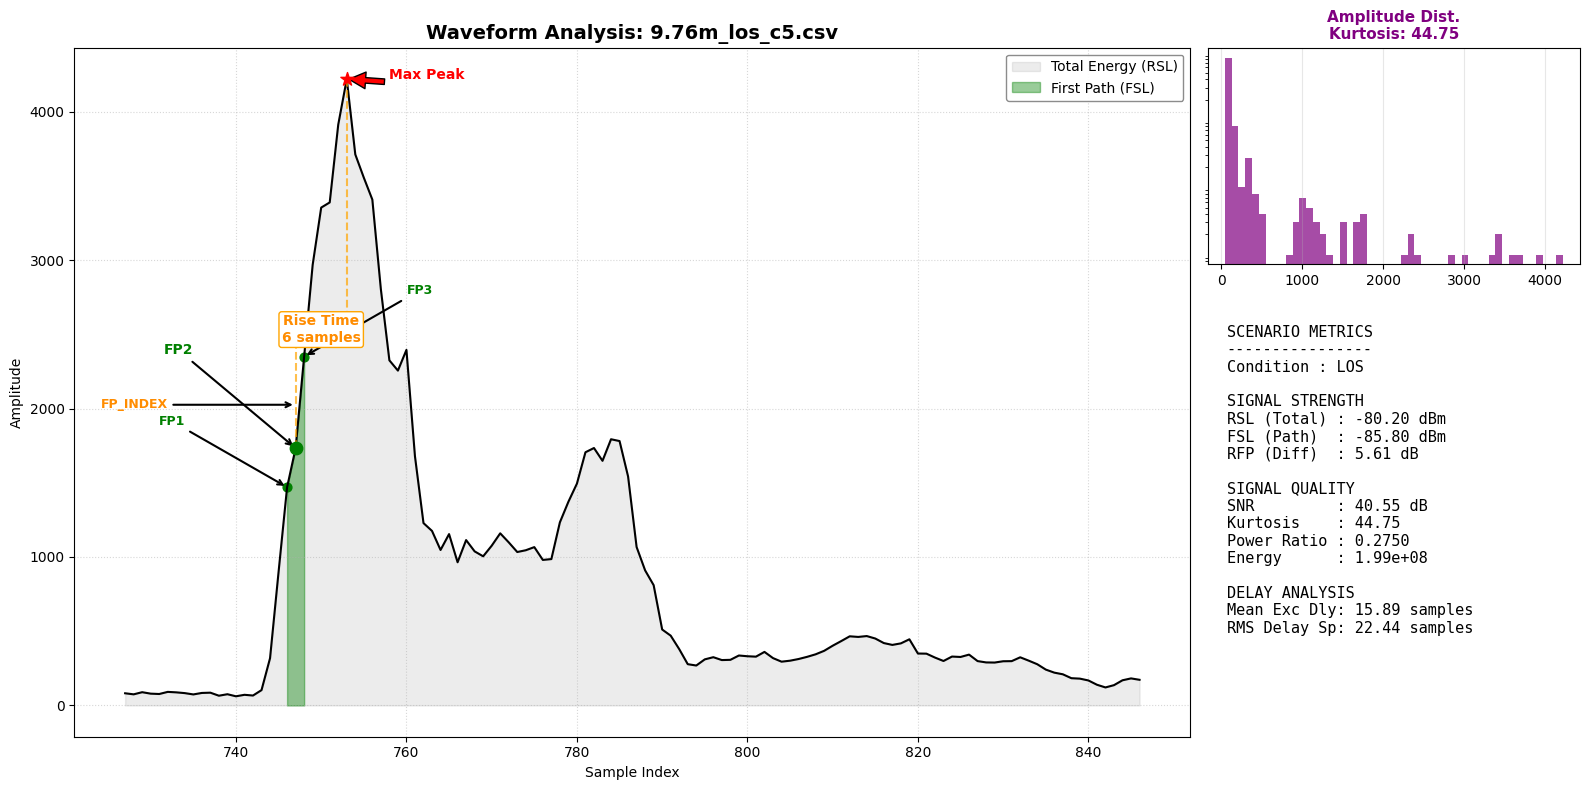

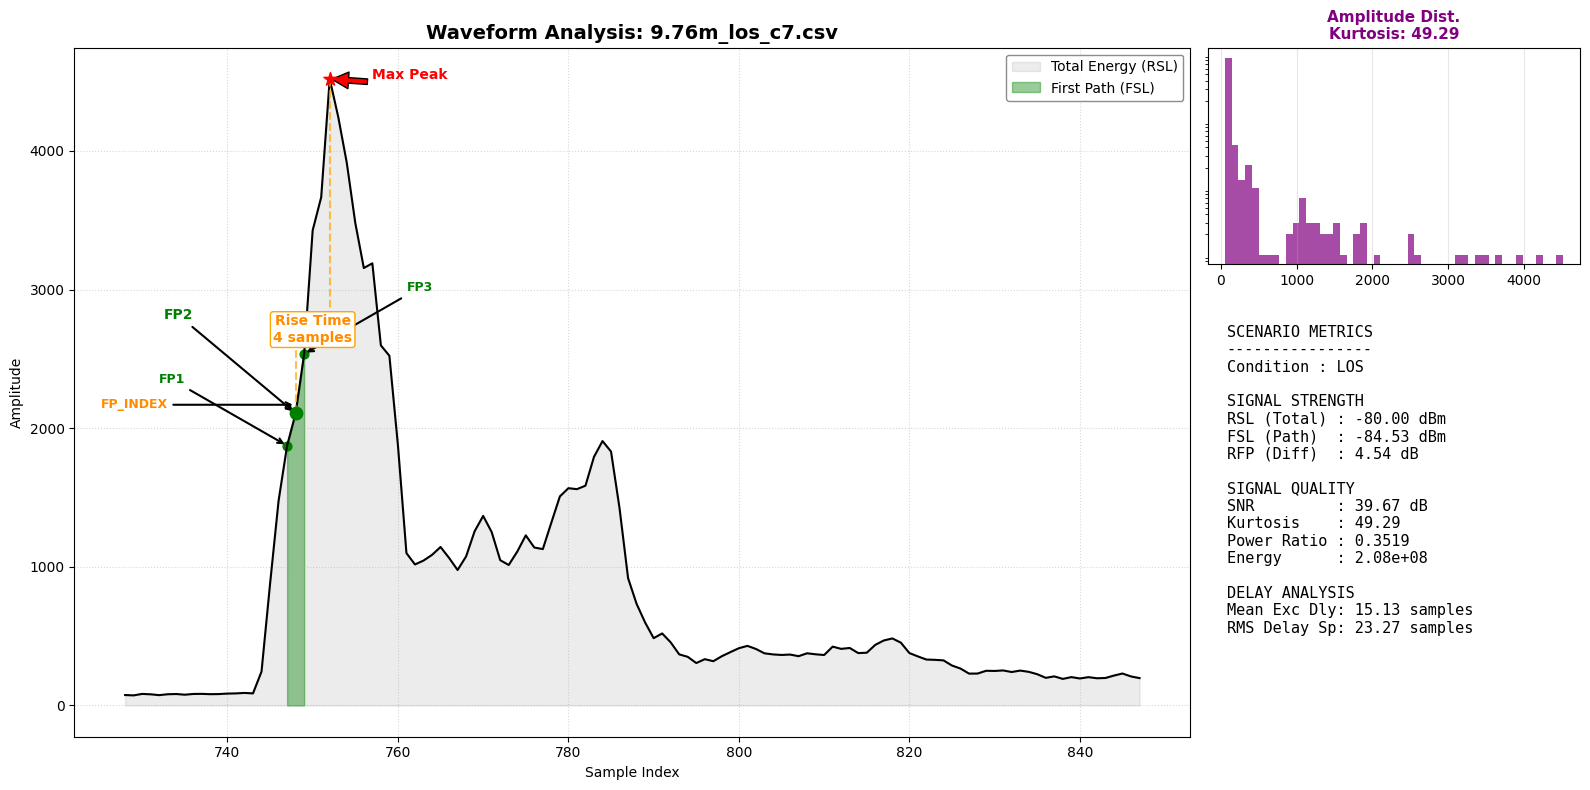

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from scipy.stats import kurtosis
import os
import glob
import re

# ==========================================
# 1. METRIC CALCULATION
# ==========================================
def analyze_hardware_dataset(filepath):
    try:
        df = pd.read_csv(filepath)
        cir_cols = sorted([c for c in df.columns if c.startswith('CIR')], key=lambda x: int(x.replace('CIR', '')))
        if not cir_cols: return None 

        raw_waves = df[cir_cols].values 
        avg_wave = np.mean(raw_waves, axis=0)
        
        # Constants
        A = 121.74 
        if 'RXPACC' in df.columns: N = df['RXPACC'].mean()
        elif 'RXP_ACC' in df.columns: N = df['RXP_ACC'].mean()
        else: N = 128.0 

        # --- ENERGY & RSL ---
        raw_sum_squares = np.sum(avg_wave**2)
        if 'CIR_PWR' in df.columns: C = df['CIR_PWR'].mean()
        else: C = raw_sum_squares / (2**17) 
        safe_C = max(C, 1e-9)
        RSL = 10 * np.log10( (safe_C * (2**17)) / (N**2) ) - A

        # --- FSL & FIRST PATH ---
        hw_fp_idx = int(df['FP_INDEX'].mean() / 64)
        idx_f1 = max(0, hw_fp_idx - 1)
        idx_f2 = hw_fp_idx
        idx_f3 = min(len(avg_wave)-1, hw_fp_idx + 1)
        
        # Plot Values
        plot_F1 = avg_wave[idx_f1]
        plot_F2 = avg_wave[idx_f2]
        plot_F3 = avg_wave[idx_f3]
        
        # Math Values
        if 'FP_AMPL1' in df.columns:
            math_F1, math_F2, math_F3 = df['FP_AMPL1'].mean(), df['FP_AMPL2'].mean(), df['FP_AMPL3'].mean()
        else:
            math_F1, math_F2, math_F3 = plot_F1, plot_F2, plot_F3

        F_sum = (math_F1**2) + (math_F2**2) + (math_F3**2)
        safe_F = max(F_sum, 1e-9)
        FSL = 10 * np.log10( safe_F / (N**2) ) - A

        # --- SNR ---
        if 'STD_NOISE' in df.columns: std_noise = df['STD_NOISE'].mean()
        else: std_noise = np.std(avg_wave[0:30])
        max_amp = np.max(avg_wave)
        SNR = 20 * np.log10(max_amp / (std_noise + 1e-9))

        # --- ADDITIONAL METRICS ---
        kurt_val = kurtosis(avg_wave)
        fp_energy_raw = math_F1**2 + math_F2**2 + math_F3**2
        total_energy_raw = np.sum(avg_wave**2)
        power_ratio = fp_energy_raw / max(total_energy_raw, 1e-9)
        
        # --- DELAY SPREAD CALCULATIONS ---
        pdp = avg_wave[hw_fp_idx:]**2
        times = np.arange(len(pdp))
        total_pdp_pwr = np.sum(pdp) + 1e-9
        mean_excess_delay = np.sum(pdp * times) / total_pdp_pwr
        second_moment = np.sum(pdp * (times**2)) / total_pdp_pwr
        rms_delay_spread = np.sqrt(max(0, second_moment - (mean_excess_delay**2)))
        
        RFP = RSL - FSL
        if RFP < 6.0: condition = "LOS"
        elif RFP <= 10.0: condition = "Soft NLOS"
        else: condition = "Hard NLOS"
        
        peak_idx = np.argmax(avg_wave)
        rise_time = peak_idx - hw_fp_idx

        return {
            "Filename": os.path.basename(filepath),
            "Avg_Wave": avg_wave,
            "HW_FP_Index": hw_fp_idx,
            "Indices": (idx_f1, idx_f2, idx_f3, peak_idx),
            "Plot_Amps": (plot_F1, plot_F2, plot_F3),
            "Max_Amp": max_amp,
            "RSL_dBm": RSL,
            "FSL_dBm": FSL,
            "RFP_Metric": RFP,
            "SNR_dB": SNR,
            "Kurtosis": kurt_val,
            "Power_Ratio": power_ratio,
            "Total_Energy": total_energy_raw,
            "Rise_Time": rise_time,
            "Mean_Excess_Delay": mean_excess_delay,
            "RMS_Delay_Spread": rms_delay_spread,
            "Condition": condition
        }
    except Exception as e: return None

# ==========================================
# 2. PLOTTER (Standard Close Labels)
# ==========================================
def plot_final_standard_labels(scenario_prefix):
    files = glob.glob(f"{scenario_prefix}_c*.csv")
    if not files: return

    for f in sorted(files):
        data = analyze_hardware_dataset(f)
        if not data: continue

        avg_wave = data['Avg_Wave']
        hw_fp = data['HW_FP_Index']
        idx_f1, idx_f2, idx_f3, peak_idx = data['Indices']
        f1, f2, f3 = data['Plot_Amps']
        max_amp = data['Max_Amp']
        
        # --- SETUP GRID ---
        fig = plt.figure(figsize=(16, 8))
        gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 2])
        
        ax_main = fig.add_subplot(gs[:, 0])      # Main Waveform
        ax_hist = fig.add_subplot(gs[0, 1])      # Histogram
        ax_text = fig.add_subplot(gs[1, 1])      # Metrics
        
        # --- 1. MAIN WAVEFORM PLOT (Left) ---
        start = max(0, hw_fp - 20)
        end = min(len(avg_wave), hw_fp + 100)
        x_zoom = np.arange(start, end)
        y_zoom = avg_wave[start:end]
        
        # Shading
        ax_main.fill_between(x_zoom, 0, y_zoom, color='gray', alpha=0.15, label='Total Energy (RSL)')
        ax_main.fill_between([idx_f1, idx_f2, idx_f3], 0, [f1, f2, f3], color='green', alpha=0.4, label='First Path (FSL)')
        ax_main.plot(x_zoom, y_zoom, color='black', linewidth=1.5)
        
        # --- POINT ANNOTATIONS ---
        ax_main.scatter(idx_f2, f2, color='green', s=80, zorder=5)
        ax_main.annotate('FP2', xy=(idx_f2, f2), xytext=(idx_f2 - 12, f2 + (max_amp*0.15)),
                    arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5),
                    fontsize=10, color='green', fontweight='bold', ha='right')

        ax_main.scatter(idx_f1, f1, color='green', s=40)
        ax_main.annotate('FP1', xy=(idx_f1, f1), xytext=(idx_f1 - 12, f1 + (max_amp*0.1)),
                    arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5), 
                    fontsize=9, color='green', fontweight='bold', ha='right')
        
        ax_main.scatter(idx_f3, f3, color='green', s=40)
        ax_main.annotate('FP3', xy=(idx_f3, f3), xytext=(idx_f3 + 12, f3 + (max_amp*0.1)),
                    arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5), 
                    fontsize=9, color='green', fontweight='bold', ha='left')

        ax_main.scatter(peak_idx, max_amp, color='red', s=100, marker='*', zorder=5)
        ax_main.annotate('Max Peak', xy=(peak_idx, max_amp), xytext=(peak_idx + 5, max_amp),
                    arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red', fontweight='bold')
        
        # --- RISE TIME & FP_INDEX ---
        dim_y = max_amp * 0.6 
        ax_main.plot([hw_fp, hw_fp], [f2, dim_y], color='orange', linestyle='--', alpha=0.7)
        ax_main.annotate('FP_INDEX', xy=(hw_fp, dim_y * 0.8), xytext=(hw_fp - 15, dim_y * 0.8),
                         arrowprops=dict(facecolor='orange', arrowstyle='->', lw=1.5),
                         color='darkorange', fontsize=9, fontweight='bold', ha='right', va='center')
        
        ax_main.plot([peak_idx, peak_idx], [max_amp, dim_y], color='orange', linestyle='--', alpha=0.7)
        ax_main.annotate('', xy=(hw_fp, dim_y), xytext=(peak_idx, dim_y), arrowprops=dict(arrowstyle='<->', color='orange', lw=2))
        mid_x = (hw_fp + peak_idx) / 2
        ax_main.text(mid_x, dim_y, f"Rise Time\n{data['Rise_Time']} samples", 
                color='darkorange', fontsize=10, ha='center', va='center', fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.2'))

        ax_main.legend(loc='upper right', framealpha=0.9, edgecolor='gray')
        ax_main.set_title(f"Waveform Analysis: {data['Filename']}", fontsize=14, fontweight='bold')
        ax_main.set_xlabel("Sample Index")
        ax_main.set_ylabel("Amplitude")
        ax_main.grid(True, linestyle=':', alpha=0.5)

        # --- 2. HISTOGRAM (Top Right) ---
        ax_hist.hist(avg_wave, bins=50, color='purple', alpha=0.7)
        ax_hist.set_title(f"Amplitude Dist.\nKurtosis: {data['Kurtosis']:.2f}", fontsize=11, fontweight='bold', color='purple')
        ax_hist.set_yscale('log')
        ax_hist.tick_params(left=False, labelleft=False)
        ax_hist.grid(axis='x', alpha=0.3)

        # --- 3. METRICS LIST (Bottom Right) ---
        ax_text.axis('off')
        info_text = (
            f"SCENARIO METRICS\n"
            f"----------------\n"
            f"Condition : {data['Condition']}\n\n"
            f"SIGNAL STRENGTH\n"
            f"RSL (Total) : {data['RSL_dBm']:.2f} dBm\n"
            f"FSL (Path)  : {data['FSL_dBm']:.2f} dBm\n"
            f"RFP (Diff)  : {data['RFP_Metric']:.2f} dB\n\n"
            f"SIGNAL QUALITY\n"
            f"SNR         : {data['SNR_dB']:.2f} dB\n"
            f"Kurtosis    : {data['Kurtosis']:.2f}\n"
            f"Power Ratio : {data['Power_Ratio']:.4f}\n"
            f"Energy      : {data['Total_Energy']:.2e}\n\n"
            f"DELAY ANALYSIS\n"
            f"Mean Exc Dly: {data['Mean_Excess_Delay']:.2f} samples\n"
            f"RMS Delay Sp: {data['RMS_Delay_Spread']:.2f} samples"
        )
        ax_text.text(0.05, 0.95, info_text, transform=ax_text.transAxes, fontsize=11, family='monospace', va='top')

        plt.tight_layout()
        plt.show()

# Run — search in dataset/channel/
all_csvs = glob.glob(os.path.join(CHANNEL_DIR, "*.csv"))
scenarios = sorted(list(set([re.sub(r'_c\d+\.csv$', '', f) for f in all_csvs if "_c" in f])))
for s in scenarios:
    plot_final_standard_labels(s)

Dataset loaded successfully.

FEATURE DISCRIMINATOR POWER TABLE
Feature              | Fisher (FDR) | ROC AUC    | Correlation 
-------------------------------------------------------------------------------------
FSL_dBm              | 8.9704       | 0.9990     | -0.9043     
Total_Energy         | 6.9380       | 0.9877     | -0.8811     
Mean_Excess_Delay    | 5.9982       | 0.9964     | 0.8661      
RMS_Delay_Spread     | 4.5515       | 0.9962     | 0.8336      
Max_Amplitude        | 3.6632       | 0.9582     | -0.8043     
RSL_dBm              | 2.7465       | 0.9877     | -0.7608     
RFP_Metric           | 1.6506       | 0.9082     | 0.6725      
Power_Ratio          | 1.6344       | 0.9082     | -0.6707     
Rise_Time            | 0.5495       | 0.7546     | 0.4644      
Kurtosis             | 0.0042       | 0.5143     | 0.0460      


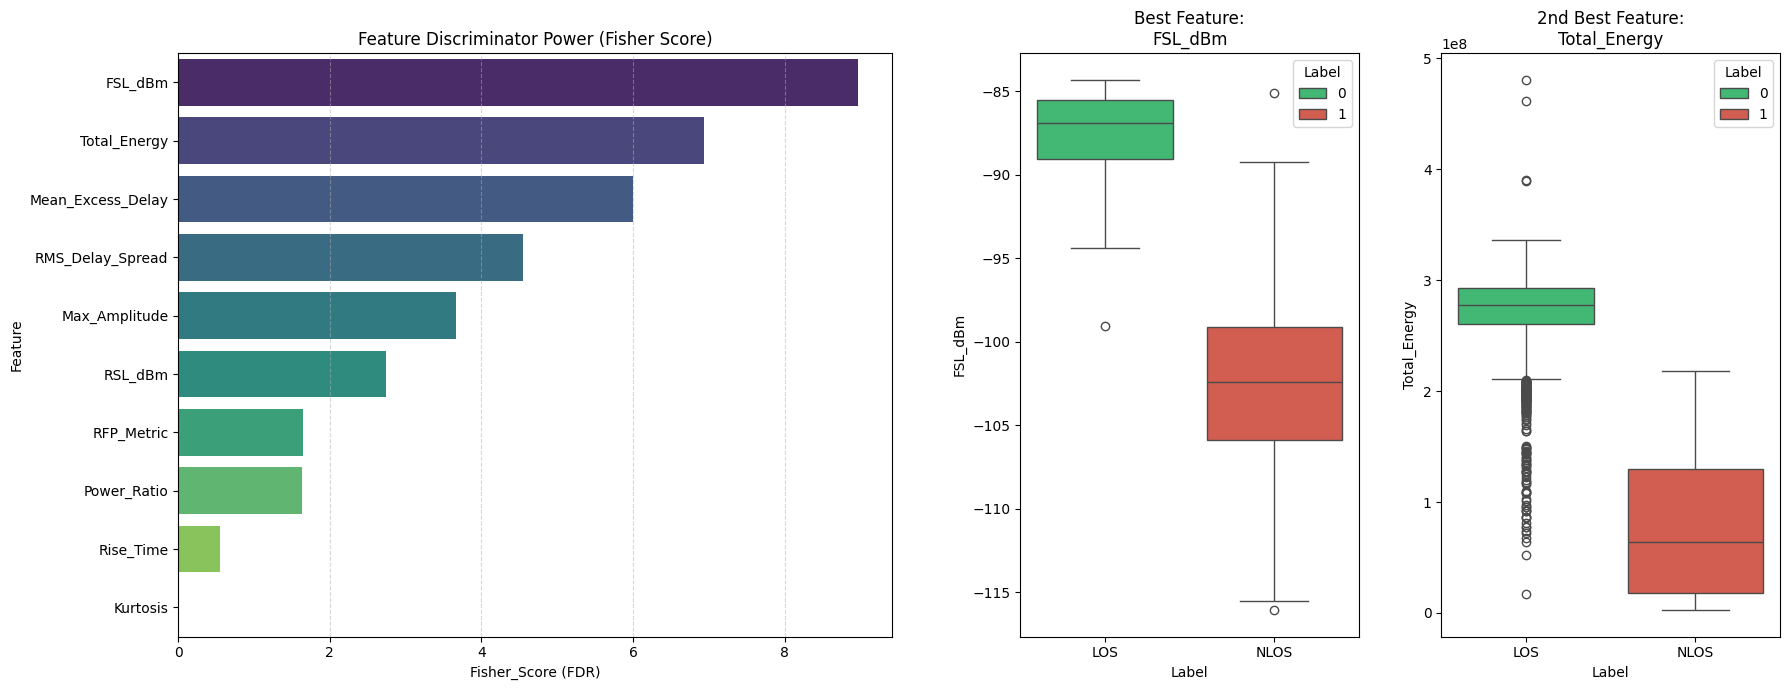

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn.metrics import roc_auc_score

# ==========================================
# 1. SETUP & LOAD DATA
# ==========================================
filepath = os.path.join(CHANNEL_DIR, "combined_uwb_dataset.csv")
A = 121.74  # PRF 64 MHz constant for DW1000

try:
    df = pd.read_csv(filepath)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {filepath}")
    df = pd.DataFrame() 

cir_cols = sorted([c for c in df.columns if c.startswith('CIR')], key=lambda x: int(x.replace('CIR', '')))

# ==========================================
# 2. FEATURE EXTRACTION
# ==========================================
data = []

if not df.empty:
    for idx, row in df.iterrows():
        # Get Preamble Accumulation Count (N)
        if 'RXPACC' in row: N = float(row['RXPACC'])
        elif 'RXP_ACC' in row: N = float(row['RXP_ACC'])
        else: N = 128.0 
            
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        if len(sig) == 0: continue
        
        peak_idx = np.argmax(sig)
        peak_val = sig[peak_idx]
        
        try:
            hw_fp_index = float(row['FP_INDEX']) / 64.0
        except (KeyError, ValueError):
            hw_fp_index = peak_idx 
        
        # --- DELAY SPREAD CALCULATIONS ---
        pdp = sig[int(hw_fp_index):]**2
        total_pdp_pwr = np.sum(pdp) + 1e-9
        times = np.arange(len(pdp))
        
        mean_excess_delay = np.sum(pdp * times) / total_pdp_pwr
        second_moment = np.sum(pdp * (times**2)) / total_pdp_pwr
        rms_delay_spread = np.sqrt(max(0, second_moment - (mean_excess_delay**2)))

        # Standard Features
        rise_time = peak_idx - hw_fp_index
        c_max = peak_val
        raw_energy = np.sum(sig**2)
        safe_energy = max(raw_energy, 1e-9)
        
        # Power Metrics
        rsl_dbm = 10 * np.log10(safe_energy / (N**2)) - A
        fp_int_idx = int(hw_fp_index)
        fp_energy_val = np.sum(sig[max(0, fp_int_idx - 1):min(len(sig), fp_int_idx + 2)]**2)
        safe_fp_energy = max(fp_energy_val, 1e-9)
        fsl_dbm = 10 * np.log10(safe_fp_energy / (N**2)) - A
        
        rfp = rsl_dbm - fsl_dbm
        c_power_ratio = safe_fp_energy / safe_energy
        
        # Kurtosis
        window = sig[max(0, peak_idx - 10):min(len(sig), peak_idx + 30)]
        c_kurt = kurtosis(window) if len(window) > 5 else 0
            
        data.append({
            "Max_Amplitude": c_max,
            "Total_Energy": raw_energy,
            "RSL_dBm": rsl_dbm,
            "FSL_dBm": fsl_dbm,
            "RFP_Metric": rfp,
            "Power_Ratio": c_power_ratio,
            "Kurtosis": c_kurt,
            "Rise_Time": rise_time,
            "Mean_Excess_Delay": mean_excess_delay,
            "RMS_Delay_Spread": rms_delay_spread,
            "Label": row['Label']
        })

    df_features = pd.DataFrame(data)

    # ==========================================
    # 3. FEATURE DISCRIMINATOR ANALYSIS
    # ==========================================
    feature_list = [
        "RFP_Metric", "Power_Ratio", "Kurtosis", 
        "Rise_Time", "RSL_dBm", "FSL_dBm", 
        "Total_Energy", "Max_Amplitude",
        "Mean_Excess_Delay", "RMS_Delay_Spread"
    ]
    
    discriminator_data = []
    los_data = df_features[df_features['Label'] == 0]
    nlos_data = df_features[df_features['Label'] == 1]
    
    for feat in feature_list:
        corr = df_features[feat].corr(df_features['Label'])
        mu0, mu1 = los_data[feat].mean(), nlos_data[feat].mean()
        var0, var1 = los_data[feat].var(), nlos_data[feat].var()
        fisher_score = ((mu0 - mu1)**2) / (var0 + var1 + 1e-9)
        try:
            auc = roc_auc_score(df_features['Label'], df_features[feat])
            auc = max(auc, 1 - auc) 
        except:
            auc = 0.5

        discriminator_data.append({
            "Feature": feat,
            "Fisher_Score (FDR)": fisher_score,
            "ROC_AUC": auc,
            "Correlation": corr
        })
    
    df_power = pd.DataFrame(discriminator_data).sort_values(by="Fisher_Score (FDR)", ascending=False)

    print("\nFEATURE DISCRIMINATOR POWER TABLE")
    print("=" * 85)
    print(f"{'Feature':<20} | {'Fisher (FDR)':<12} | {'ROC AUC':<10} | {'Correlation':<12}")
    print("-" * 85)
    for _, row in df_power.iterrows():
        print(f"{row['Feature']:<20} | {row['Fisher_Score (FDR)']:<12.4f} | {row['ROC_AUC']:<10.4f} | {row['Correlation']:<12.4f}")
    print("=" * 85)

    # ==========================================
    # 4. VISUALIZATION
    # ==========================================
    plt.figure(figsize=(18, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(x="Fisher_Score (FDR)", y="Feature", data=df_power, hue="Feature", palette="viridis")
    plt.title("Feature Discriminator Power (Fisher Score)")
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    top_2_features = df_power['Feature'].head(2).values
    plt.subplot(1, 4, 3) 
    sns.boxplot(x='Label', y=top_2_features[0], data=df_features, hue='Label', palette=['#2ecc71', '#e74c3c'])
    plt.title(f"Best Feature:\n{top_2_features[0]}")
    plt.xticks([0, 1], ['LOS', 'NLOS'])
    
    plt.subplot(1, 4, 4)
    sns.boxplot(x='Label', y=top_2_features[1], data=df_features, hue='Label', palette=['#2ecc71', '#e74c3c'])
    plt.title(f"2nd Best Feature:\n{top_2_features[1]}")
    plt.xticks([0, 1], ['LOS', 'NLOS'])

    plt.tight_layout()
    plt.show()

- Metric,LOS (4.55m),NLOS (7.79m),LNN Conclusion
- MaxAmp,High (>5000),Low (~800-1300),Blockage is present.
- Rise_ns,Fast (~3-5ns),Slow (~6-9ns),Leading edge is obstructed.
- Width,Narrow (~3-5),Broad (~8-21),Signal is reflecting/scattering.
- MED,Low (<9),High (>14),Energy is delayed by geometry.

# Chapter 3: TOA-Based Peak Analysis (NLOS)

**Goal**: Explore whether a **physics-based TOA (Time-of-Arrival)** approach can estimate NLOS bias from CIR peak separation, as an alternative to ML-based prediction.

**Approach**: In single-bounce NLOS with 2 visible CIR peaks:
- **Peak 1** (earlier): attenuated direct path through obstacle
- **Peak 2** (later): reflected path (d1 + d2)

The peak separation in CIR indices can be converted to distance via TOA:
```
bias_toa = (peak2_index - peak1_index) x distance_per_CIR_sample
```

DW1000 CIR accumulator: ~1.0016 ns per sample -> **~0.3003 m per CIR index**

We also explore converting individual CIR peaks to **absolute distances** using the hardware FP_INDEX register (16-bit value with 6-bit fractional part: actual CIR index = FP_INDEX / 64).

DW1000 CIR timing: 1.0016 ns/sample
Distance per CIR index: 0.3003 m

Peak count distribution (ALL NLOS samples — no filter):
  1-peak samples: 258 (14.3%)
  2-peak samples: 588 (32.7%)
  3-peak samples: 312 (17.3%)
  4-peak samples: 88 (4.9%)
  5-peak samples: 38 (2.1%)
  6-peak samples: 83 (4.6%)
  7-peak samples: 51 (2.8%)
  8-peak samples: 65 (3.6%)
  9-peak samples: 167 (9.3%)
  10-peak samples: 118 (6.6%)
  11-peak samples: 28 (1.6%)
  12-peak samples: 4 (0.2%)
  Total NLOS: 1800
  TOA analysis possible: 1542 samples (>= 2 peaks)

Peak Count by Distance Group
  10.77m: 366 samples with >= 2 peaks (usable for TOA)
  14m: 600 samples with >= 2 peaks (usable for TOA)
  7.79m: 576 samples with >= 2 peaks (usable for TOA)

TOA-Derived Bias vs Measured Ground Truth
Group      |    N |   TOA Mean |  TOA Std |   Measured |    Error
------------------------------------------------------------
10.77m     |  366 |     13.941 |    9.119 |       5.32 |   +8.621
14m        |  600 |      2.774 

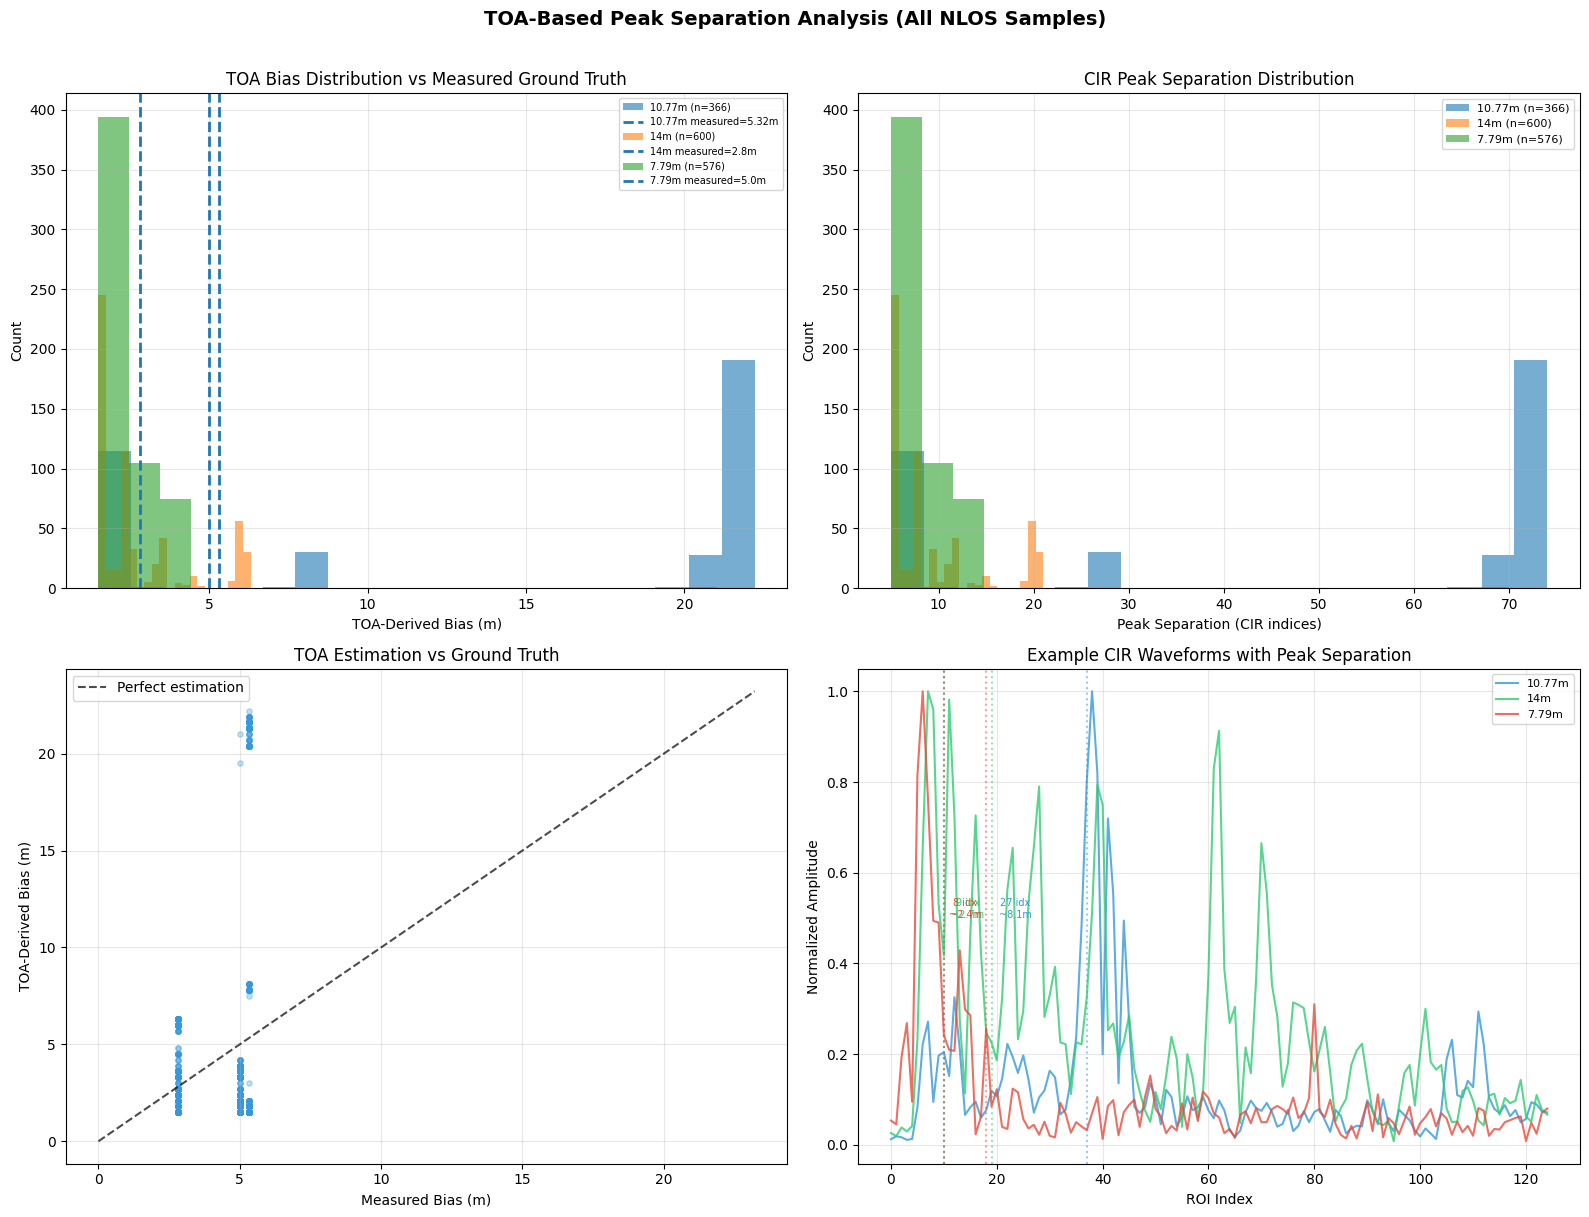

In [11]:
# ==========================================
# TOA-BASED PEAK SEPARATION ANALYSIS (Self-contained)
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.signal import find_peaks

# --- Configuration ---
PEAK_PROMINENCE = 0.20
PEAK_MIN_DISTANCE = 5
SEARCH_START = 700
SEARCH_END = 800

# DW1000 CIR timing
CIR_SAMPLE_PERIOD_NS = 1.0016   # ns per CIR accumulator sample
SPEED_OF_LIGHT = 299_792_458     # m/s
DIST_PER_INDEX = SPEED_OF_LIGHT * CIR_SAMPLE_PERIOD_NS * 1e-9  # ~0.3003 m

# Ground truth: physically measured NLOS bias per setup
MEASURED_NLOS_BIAS = {
    "7.79m":  5.00,    # bounce 12.79m - direct 7.79m
    "10.77m": 5.32,    # bounce 16.09m - direct 10.77m
    "14m":    2.80,    # bounce 16.80m - direct 14.00m
}


def get_distance_group(fname):
    """Extract distance group prefix from source filename."""
    match = re.match(r'^([\d.]+m)', fname)
    return match.group(1) if match else None


def get_roi_alignment(sig, search_start=SEARCH_START, search_end=SEARCH_END):
    """Find leading edge by backtracking from peak."""
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


# --- Load NLOS data ---
print(f"DW1000 CIR timing: {CIR_SAMPLE_PERIOD_NS} ns/sample")
print(f"Distance per CIR index: {DIST_PER_INDEX:.4f} m")
print(f"{'='*60}")

df_raw = pd.read_csv(os.path.join(CHANNEL_DIR, "combined_uwb_dataset.csv"))
nlos_raw = df_raw[df_raw["Label"] == 1].reset_index(drop=True)
cir_cols = sorted(
    [c for c in df_raw.columns if c.startswith('CIR')],
    key=lambda x: int(x.replace('CIR', ''))
)

toa_results = []
peak_count_dist = {}  # Track ALL peak counts (no filter)

for idx, row in nlos_raw.iterrows():
    fname = str(row["Source_File"])
    group = get_distance_group(fname)
    if group not in MEASURED_NLOS_BIAS:
        continue
    
    sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
    rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
    if rxpacc > 0:
        sig = sig / rxpacc
    
    le = get_roi_alignment(sig)
    
    roi_start = max(0, le - 5)
    roi_end = min(len(sig), le + 120)
    roi = sig[roi_start:roi_end]
    
    if len(roi) == 0 or np.max(roi) == 0:
        continue
    
    roi_norm = roi / np.max(roi)
    peaks, properties = find_peaks(
        roi_norm, prominence=PEAK_PROMINENCE, distance=PEAK_MIN_DISTANCE
    )
    num_peaks = len(peaks)
    
    # Track peak distribution (no filtering — EDA sees everything)
    peak_count_dist[num_peaks] = peak_count_dist.get(num_peaks, 0) + 1
    
    # TOA bias estimation requires at least 2 peaks (use first two)
    if num_peaks >= 2:
        peak1_roi = peaks[0]
        peak2_roi = peaks[1]
        separation = peak2_roi - peak1_roi
        toa_bias = separation * DIST_PER_INDEX
        
        toa_results.append({
            "group": group,
            "source_file": fname,
            "num_peaks": num_peaks,
            "peak1_abs_idx": roi_start + peak1_roi,
            "peak2_abs_idx": roi_start + peak2_roi,
            "separation_indices": separation,
            "toa_bias_m": toa_bias,
            "measured_bias_m": MEASURED_NLOS_BIAS[group],
            "peak1_height": roi_norm[peak1_roi],
            "peak2_height": roi_norm[peak2_roi],
            "peak1_prominence": properties["prominences"][0],
            "peak2_prominence": properties["prominences"][1],
        })

toa_df = pd.DataFrame(toa_results)

print(f"\nPeak count distribution (ALL NLOS samples — no filter):")
for n_peaks in sorted(peak_count_dist.keys()):
    count = peak_count_dist[n_peaks]
    total = sum(peak_count_dist.values())
    print(f"  {n_peaks}-peak samples: {count} ({100*count/total:.1f}%)")
print(f"  Total NLOS: {sum(peak_count_dist.values())}")
print(f"  TOA analysis possible: {len(toa_df)} samples (>= 2 peaks)")

# --- Per-group peak distribution ---
print(f"\n{'='*60}")
print(f"Peak Count by Distance Group")
print(f"{'='*60}")
for grp in sorted(MEASURED_NLOS_BIAS.keys()):
    grp_mask = toa_df["group"] == grp if len(toa_df) > 0 else pd.Series(dtype=bool)
    grp_in_toa = grp_mask.sum() if len(toa_df) > 0 else 0
    print(f"  {grp}: {grp_in_toa} samples with >= 2 peaks (usable for TOA)")

# --- Per-group TOA analysis ---
print(f"\n{'='*60}")
print(f"TOA-Derived Bias vs Measured Ground Truth")
print(f"{'='*60}")
print(f"{'Group':<10} | {'N':>4} | {'TOA Mean':>10} | {'TOA Std':>8} | {'Measured':>10} | {'Error':>8}")
print(f"{'-'*60}")

for grp in sorted(MEASURED_NLOS_BIAS.keys()):
    mask = toa_df["group"] == grp
    if mask.sum() == 0:
        print(f"{grp:<10} | {'N/A':>4} |       N/A  |      N/A |   {MEASURED_NLOS_BIAS[grp]:>7.2f} |      N/A")
        continue
    subset = toa_df[mask]
    toa_mean = subset["toa_bias_m"].mean()
    toa_std = subset["toa_bias_m"].std()
    measured = MEASURED_NLOS_BIAS[grp]
    error = toa_mean - measured
    print(f"{grp:<10} | {mask.sum():>4} | {toa_mean:>10.3f} | {toa_std:>8.3f} | {measured:>10.2f} | {error:>+8.3f}")

if len(toa_df) > 0:
    toa_errors = toa_df["toa_bias_m"] - toa_df["measured_bias_m"]
    print(f"\nOverall TOA estimation:")
    print(f"  MAE:  {toa_errors.abs().mean():.4f} m")
    print(f"  RMSE: {np.sqrt((toa_errors**2).mean()):.4f} m")
    print(f"  Mean error: {toa_errors.mean():+.4f} m")

# --- Visualization ---
if len(toa_df) > 0:
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # 1. TOA bias distribution by group
    ax = axs[0, 0]
    for grp in sorted(MEASURED_NLOS_BIAS.keys()):
        subset = toa_df[toa_df["group"] == grp]
        if len(subset) > 0:
            ax.hist(subset["toa_bias_m"], bins=20, alpha=0.6,
                    label=f'{grp} (n={len(subset)})')
            ax.axvline(MEASURED_NLOS_BIAS[grp], ls='--', lw=2,
                       label=f'{grp} measured={MEASURED_NLOS_BIAS[grp]}m')
    ax.set_xlabel("TOA-Derived Bias (m)")
    ax.set_ylabel("Count")
    ax.set_title("TOA Bias Distribution vs Measured Ground Truth")
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    
    # 2. Peak separation (indices) by group
    ax = axs[0, 1]
    for grp in sorted(MEASURED_NLOS_BIAS.keys()):
        subset = toa_df[toa_df["group"] == grp]
        if len(subset) > 0:
            ax.hist(subset["separation_indices"], bins=20, alpha=0.6,
                    label=f'{grp} (n={len(subset)})')
    ax.set_xlabel("Peak Separation (CIR indices)")
    ax.set_ylabel("Count")
    ax.set_title("CIR Peak Separation Distribution")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # 3. TOA bias vs measured (scatter)
    ax = axs[1, 0]
    ax.scatter(toa_df["measured_bias_m"], toa_df["toa_bias_m"],
               alpha=0.3, s=15, color='#3498db')
    lims = [0, max(toa_df["toa_bias_m"].max(), toa_df["measured_bias_m"].max()) + 1]
    ax.plot(lims, lims, 'k--', lw=1.5, alpha=0.7, label='Perfect estimation')
    ax.set_xlabel("Measured Bias (m)")
    ax.set_ylabel("TOA-Derived Bias (m)")
    ax.set_title("TOA Estimation vs Ground Truth")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Example CIR with peaks annotated (one per group)
    ax = axs[1, 1]
    colors_map = {'7.79m': '#e74c3c', '10.77m': '#3498db', '14m': '#2ecc71'}
    for grp in sorted(MEASURED_NLOS_BIAS.keys()):
        subset = toa_df[toa_df["group"] == grp]
        if len(subset) == 0:
            continue
        sample = subset.iloc[(subset["toa_bias_m"] - subset["toa_bias_m"].mean()).abs().argsort().iloc[0]]
        
        match_rows = nlos_raw[nlos_raw["Source_File"] == sample["source_file"]]
        if len(match_rows) == 0:
            continue
        row = match_rows.iloc[0]
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
        if rxpacc > 0:
            sig = sig / rxpacc
        
        le = get_roi_alignment(sig)
        roi_start = max(0, le - 5)
        roi_end = min(len(sig), le + 120)
        roi = sig[roi_start:roi_end]
        roi_norm = roi / np.max(roi) if np.max(roi) > 0 else roi
        
        x_axis = np.arange(len(roi_norm))
        color = colors_map.get(grp, 'gray')
        ax.plot(x_axis, roi_norm, color=color, alpha=0.8, lw=1.5, label=f'{grp}')
        
        p1 = int(sample["peak1_abs_idx"] - roi_start)
        p2 = int(sample["peak2_abs_idx"] - roi_start)
        ax.axvline(p1, color=color, ls=':', alpha=0.5)
        ax.axvline(p2, color=color, ls=':', alpha=0.5)
        ax.annotate(f'{int(sample["separation_indices"])} idx\n~{sample["toa_bias_m"]:.1f}m',
                    xy=((p1+p2)/2, 0.5), fontsize=7, ha='center', color=color)
    
    ax.set_xlabel("ROI Index")
    ax.set_ylabel("Normalized Amplitude")
    ax.set_title("Example CIR Waveforms with Peak Separation")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle("TOA-Based Peak Separation Analysis (All NLOS Samples)",
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()

Relative Peak Separation — Per-Channel CIR Verification
Formula: separation_m = (peak2_idx - peak1_idx) × 0.3003
This is anchor-free — no dependence on d_UWB or FP_INDEX.

Samples with >= 2 peaks (usable for relative separation): 1542

  10.77m Group — 366 samples with >=2 peaks


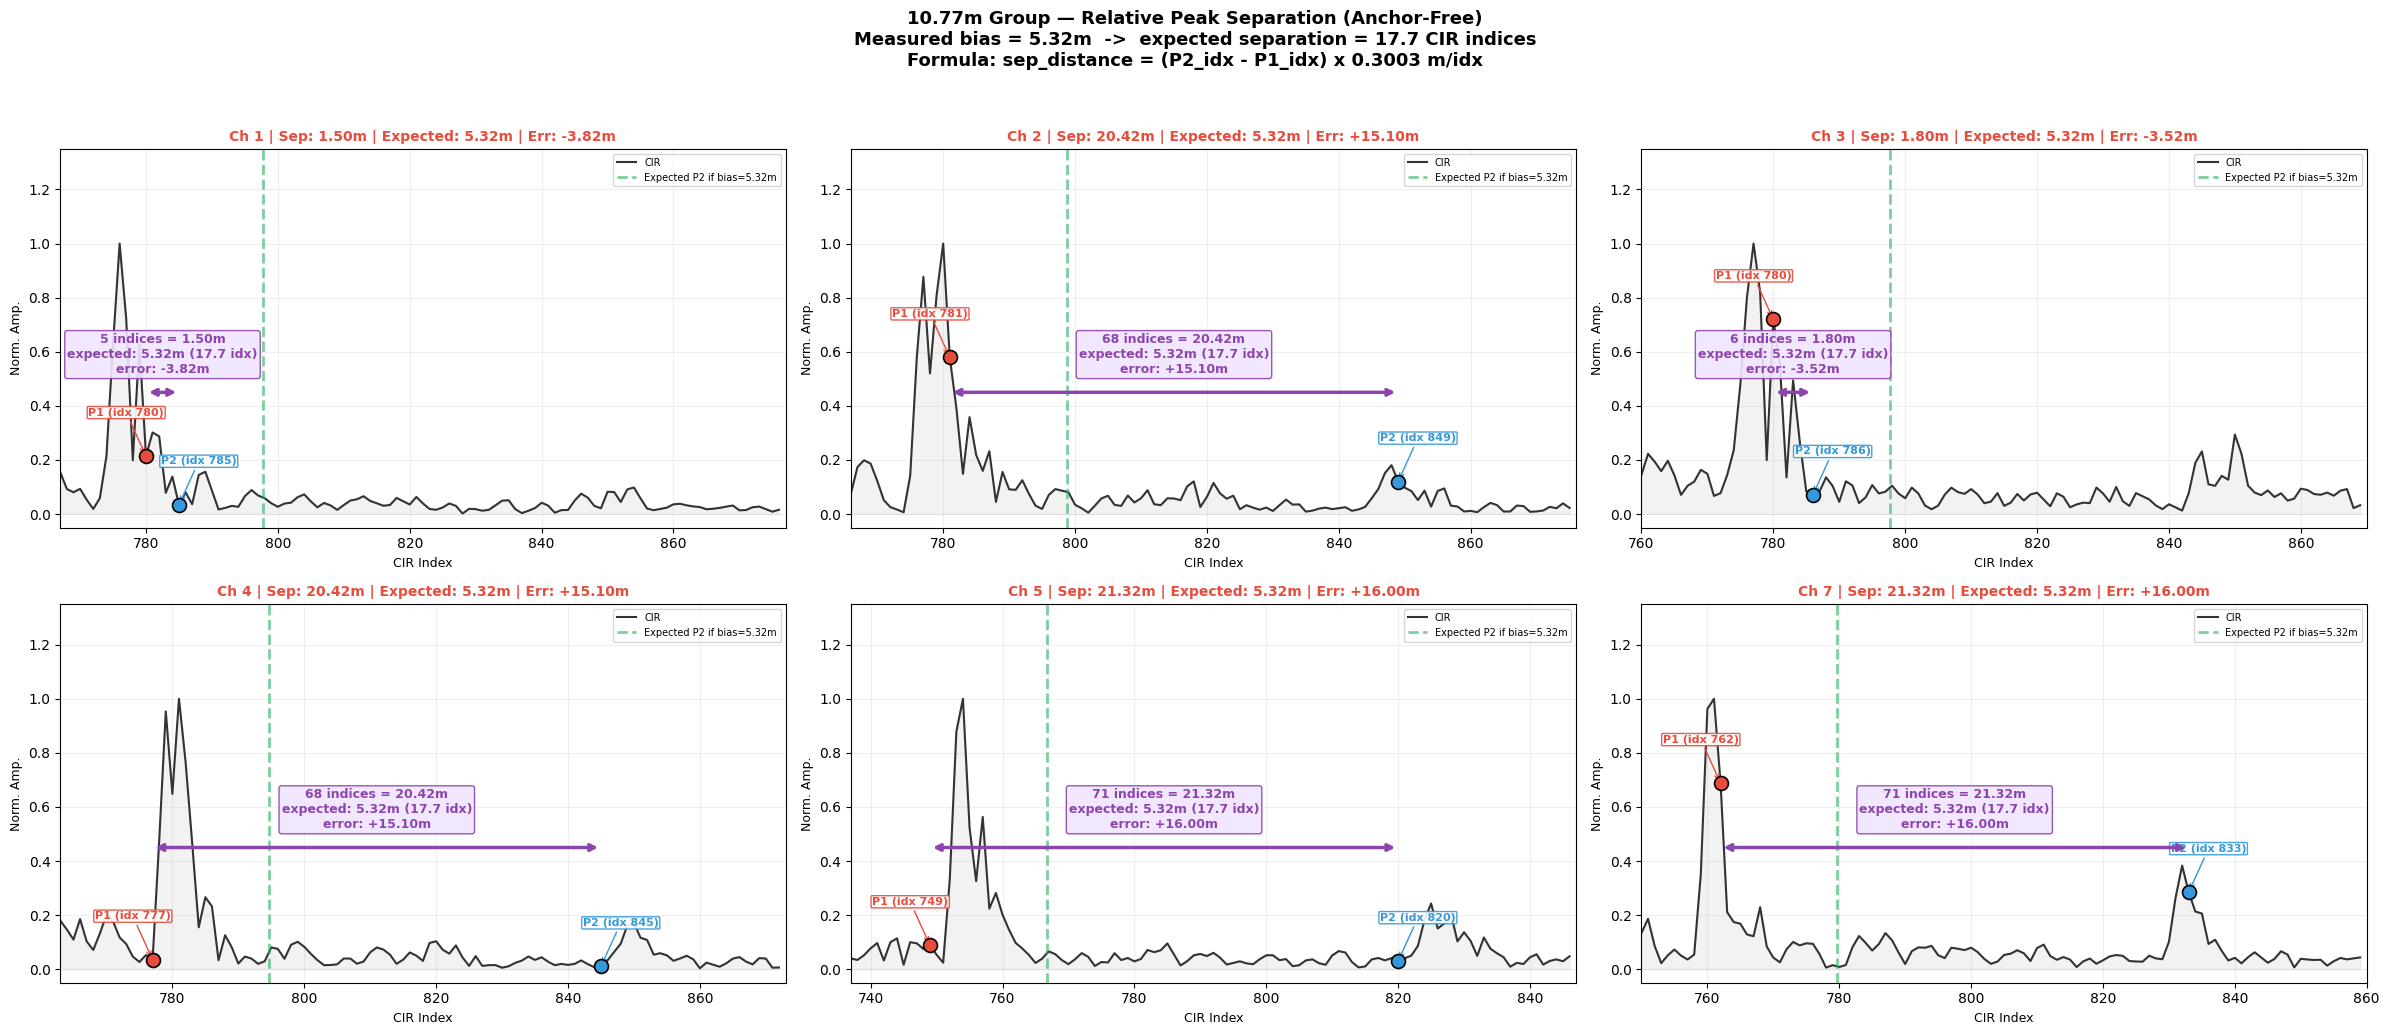


  14m Group — 600 samples with >=2 peaks


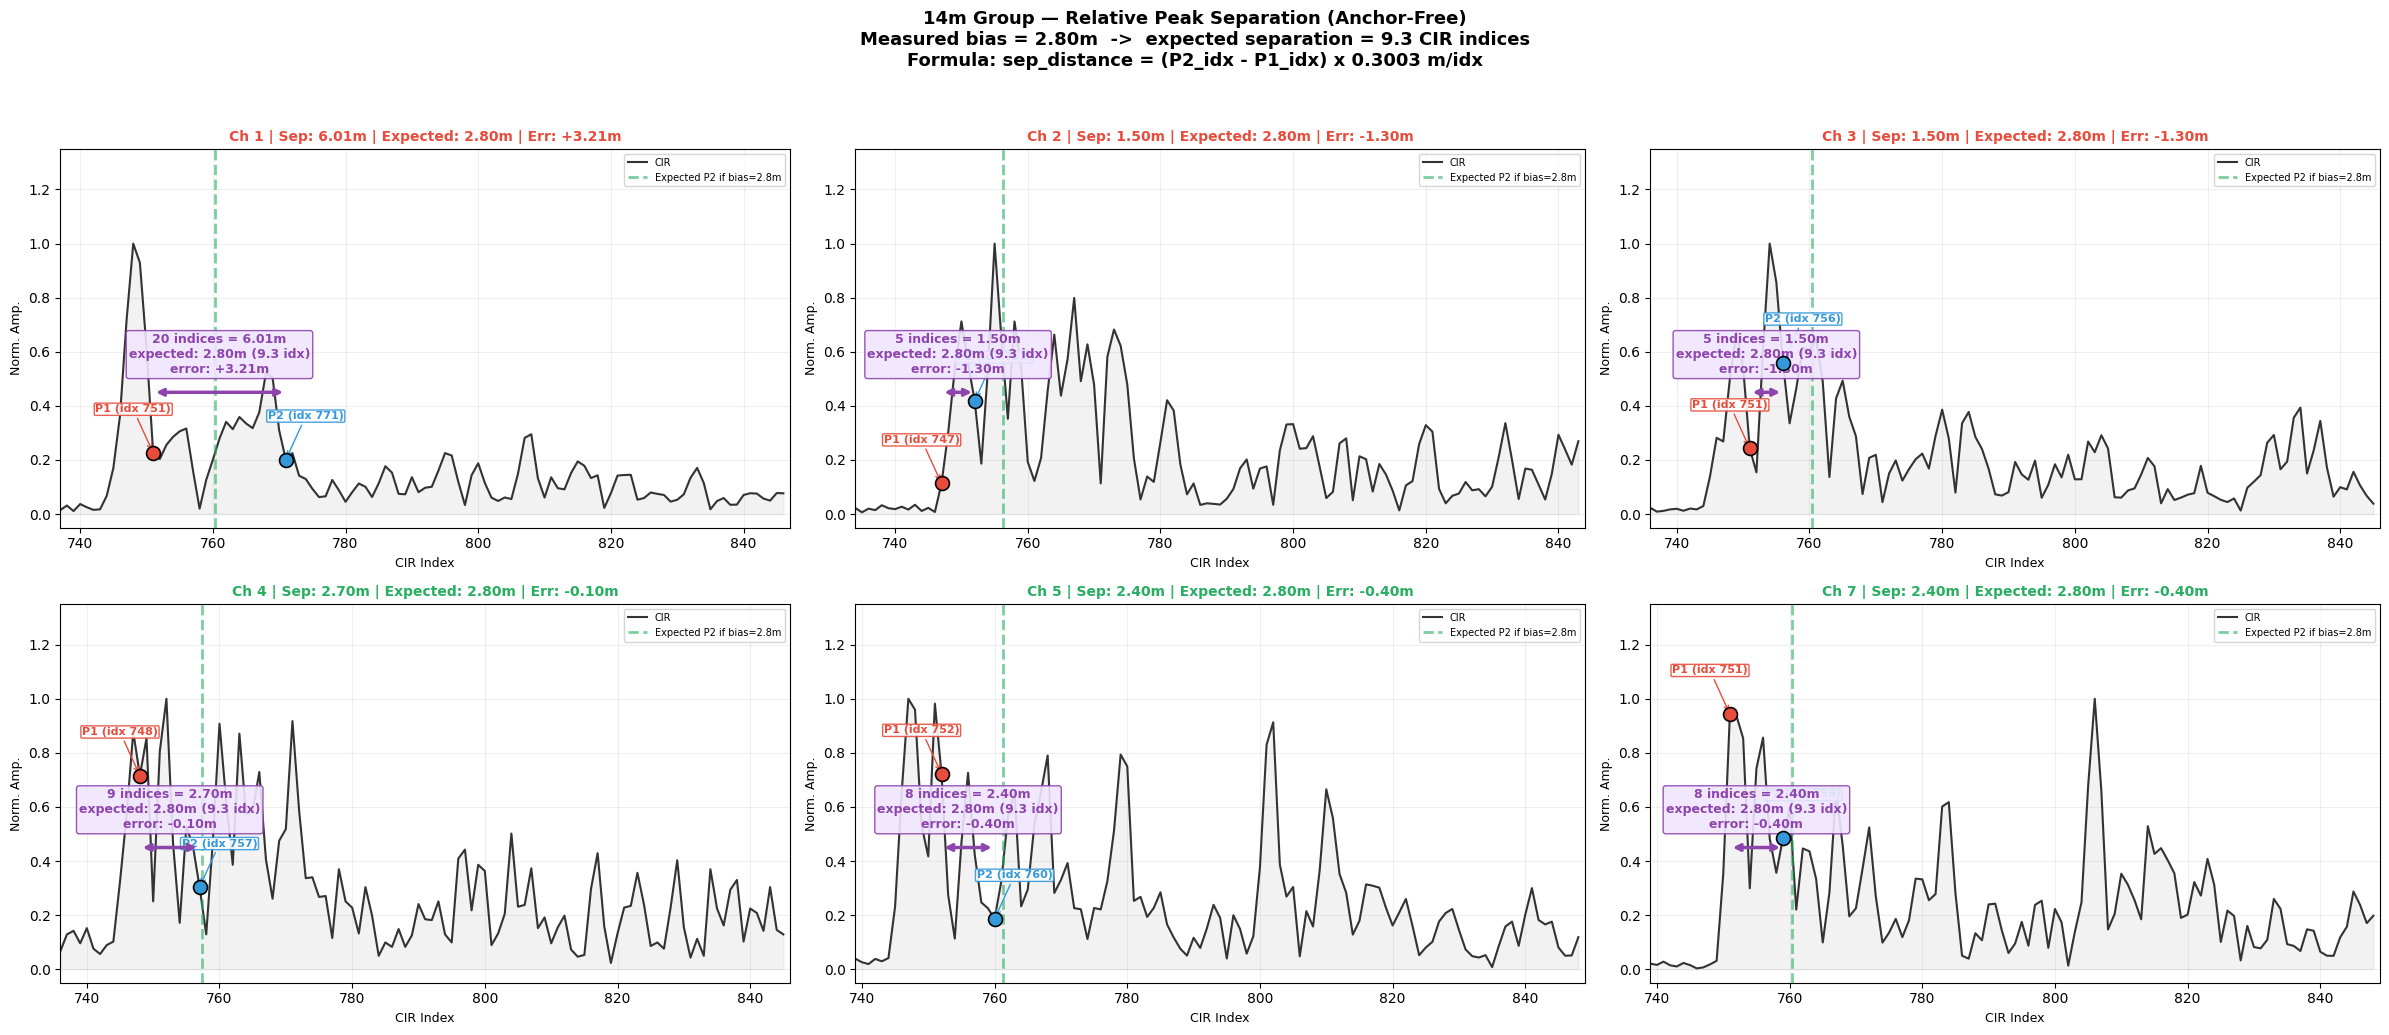


  7.79m Group — 576 samples with >=2 peaks


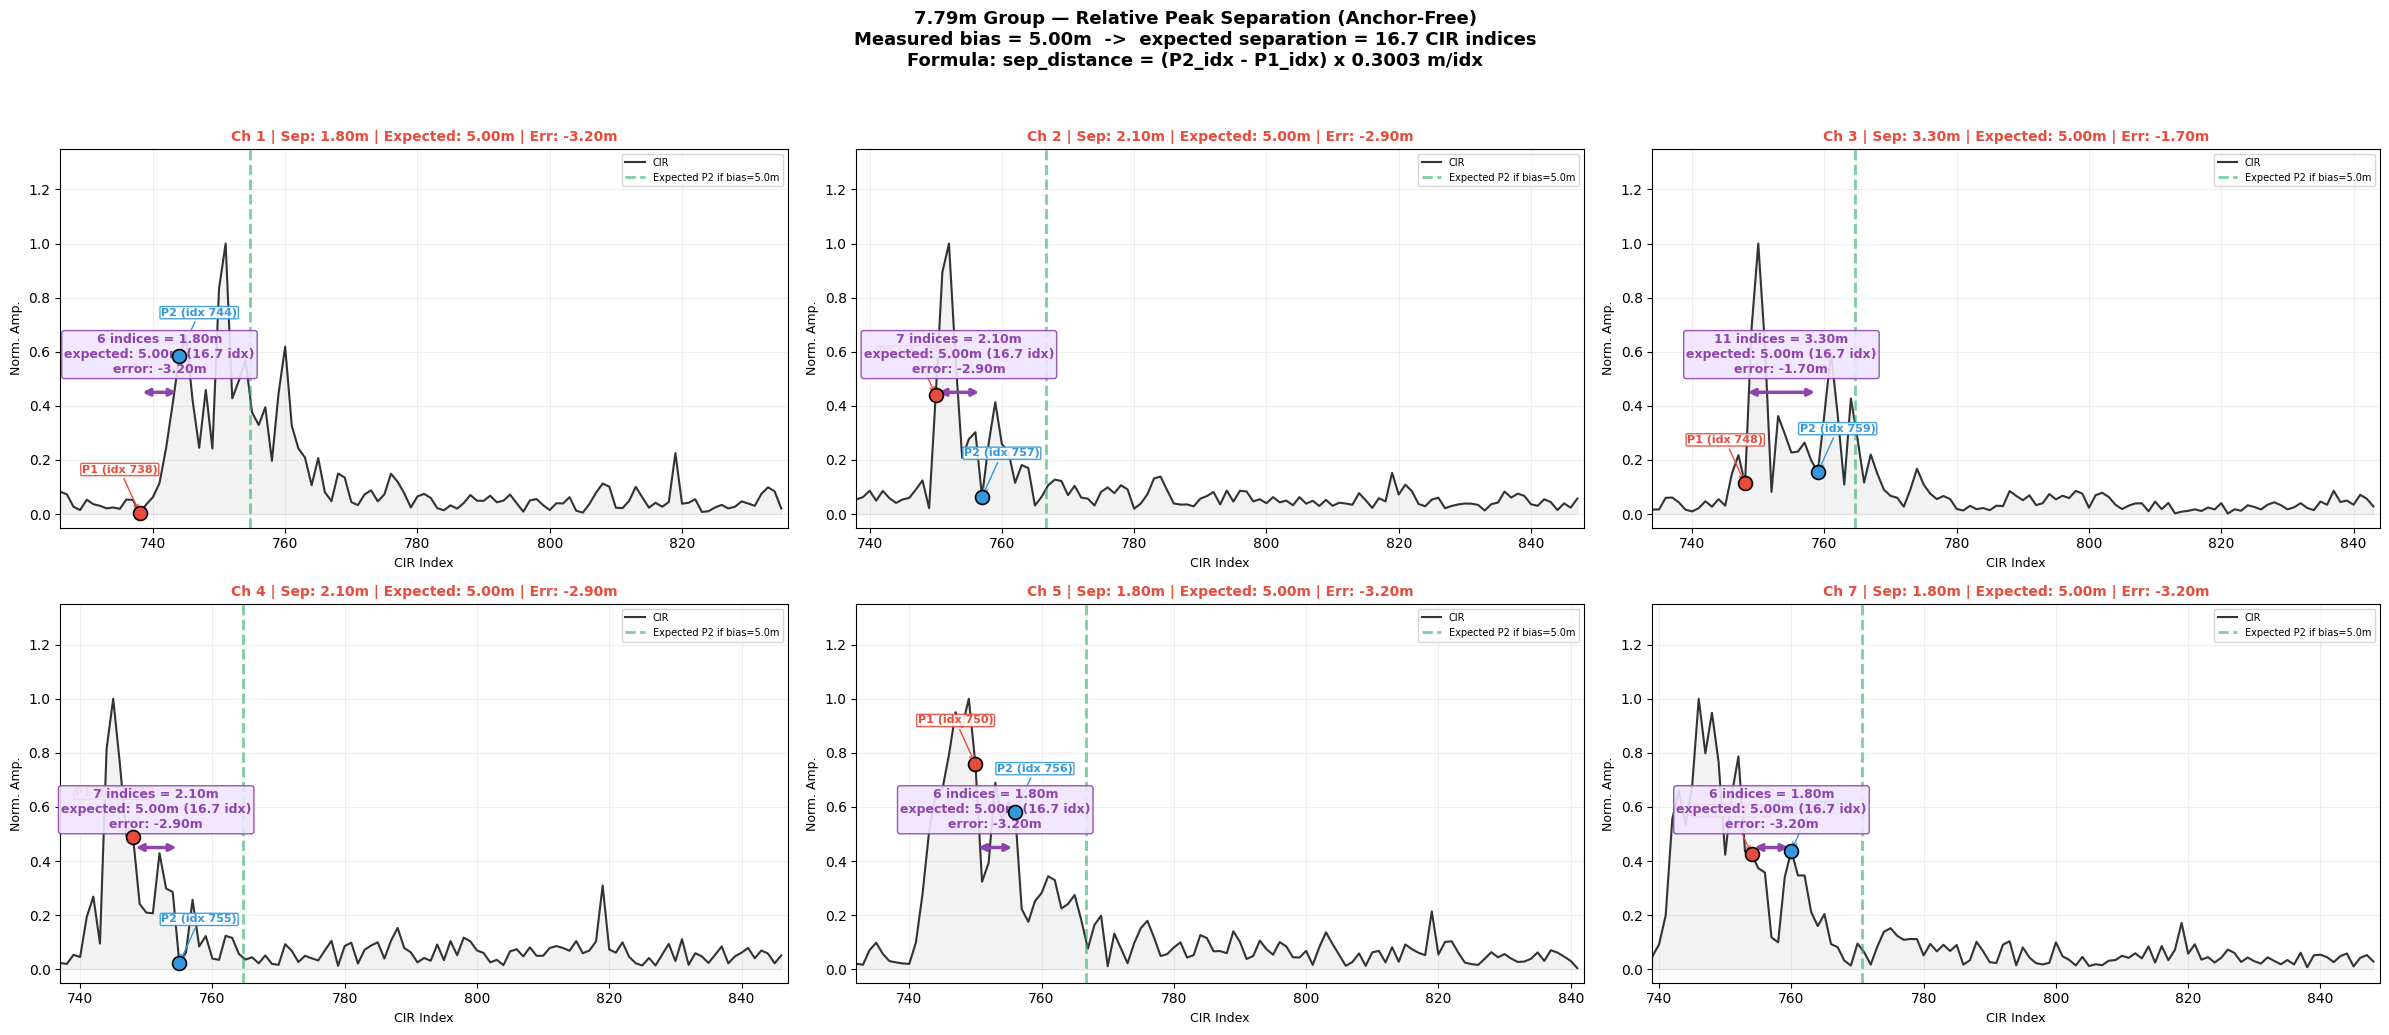

In [12]:
# ==========================================
# RELATIVE PEAK SEPARATION — PER-CHANNEL CIR VERIFICATION
# ==========================================
# The absolute formula d_peak = d_UWB + (idx - FP/64) × 0.3003 is
# ANCHOR-DEPENDENT — it inherits whatever error d_UWB has, and
# different channels give different d_UWB for the same setup.
#
# The RELATIVE approach is physically sound and anchor-free:
#   separation_distance = (peak2_idx - peak1_idx) × DIST_PER_INDEX
#
# This measures the actual path-length difference between multipath
# components, regardless of what the hardware reports as d_UWB.

import re

CHANNELS = [1, 2, 3, 4, 5, 7]

GROUND_TRUTH = {
    "7.79m":  {"d_direct": 7.79,  "d_bounce": 12.79, "bias": 5.00},
    "10.77m": {"d_direct": 10.77, "d_bounce": 16.09, "bias": 5.32},
    "14m":    {"d_direct": 14.00, "d_bounce": 16.80, "bias": 2.80},
}

def get_channel(fname):
    """Extract channel number from filename e.g. '7.79m_nlos_c1.csv' -> 1"""
    m = re.search(r'_c(\d+)\.csv', fname)
    return int(m.group(1)) if m else None

print("Relative Peak Separation — Per-Channel CIR Verification")
print(f"{'='*70}")
print(f"Formula: separation_m = (peak2_idx - peak1_idx) × {DIST_PER_INDEX:.4f}")
print(f"This is anchor-free — no dependence on d_UWB or FP_INDEX.")
print(f"{'='*70}")

# Build per-sample separation data
sep_results = []
for idx, row in nlos_raw.iterrows():
    fname = str(row["Source_File"])
    group = get_distance_group(fname)
    if group not in MEASURED_NLOS_BIAS:
        continue
    ch = get_channel(fname)

    sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
    rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
    if rxpacc > 0:
        sig = sig / rxpacc

    le = get_roi_alignment(sig)
    roi_start = max(0, le - 5)
    roi_end = min(len(sig), le + 120)
    roi = sig[roi_start:roi_end]

    if len(roi) == 0 or np.max(roi) == 0:
        continue

    roi_norm = roi / np.max(roi)
    peaks, _ = find_peaks(roi_norm, prominence=PEAK_PROMINENCE, distance=PEAK_MIN_DISTANCE)

    if len(peaks) < 2:
        continue

    p1_abs = roi_start + peaks[0]
    p2_abs = roi_start + peaks[1]
    sep_idx = peaks[1] - peaks[0]
    sep_m = sep_idx * DIST_PER_INDEX

    sep_results.append({
        "group": group, "channel": ch, "source_file": fname,
        "leading_edge": le,
        "peak1_abs": p1_abs, "peak2_abs": p2_abs,
        "peak1_height": roi_norm[peaks[0]], "peak2_height": roi_norm[peaks[1]],
        "separation_idx": sep_idx, "separation_m": sep_m,
        "expected_bias": MEASURED_NLOS_BIAS[group],
        "num_peaks": len(peaks),
    })

sep_df = pd.DataFrame(sep_results)
print(f"\nSamples with >= 2 peaks (usable for relative separation): {len(sep_df)}")

# --- Per-group, per-channel CIR waveform visualization ---
for grp in sorted(GROUND_TRUTH.keys()):
    gt = GROUND_TRUTH[grp]
    expected_sep_idx = gt["bias"] / DIST_PER_INDEX
    grp_sub = sep_df[sep_df["group"] == grp]

    ncols = 3
    nrows = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(24, 10))

    print(f"\n  {grp} Group — {len(grp_sub)} samples with >=2 peaks")

    for ch_idx, ch in enumerate(CHANNELS):
        row_i = ch_idx // ncols
        col_i = ch_idx % ncols
        ax = axs[row_i, col_i]

        ch_sub = grp_sub[grp_sub["channel"] == ch]
        if len(ch_sub) == 0:
            ax.text(0.5, 0.5, f"No 2-peak data for Ch {ch}",
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'Channel {ch} — No Data', fontsize=10)
            continue

        # Pick median-separation sample
        sorted_ch = ch_sub.sort_values("separation_m")
        pick = sorted_ch.iloc[len(sorted_ch) // 2]

        # Re-load CIR
        match_rows = nlos_raw[nlos_raw["Source_File"] == pick["source_file"]]
        if len(match_rows) == 0:
            continue
        row_data = match_rows.iloc[0]
        sig = pd.to_numeric(row_data[cir_cols], errors='coerce').fillna(0).astype(float).values
        rxpacc = float(row_data.get('RXPACC', row_data.get('RX_PACC', 128.0)))
        if rxpacc > 0:
            sig = sig / rxpacc

        le = int(pick["leading_edge"])
        plot_start = max(0, le - 10)
        plot_end = min(len(sig), le + 100)
        x_idx = np.arange(plot_start, plot_end)
        y_vals = sig[plot_start:plot_end]
        y_max = np.max(y_vals) if np.max(y_vals) > 0 else 1
        y_norm = y_vals / y_max

        # CIR waveform
        ax.plot(x_idx, y_norm, color='#333', lw=1.5, label='CIR')
        ax.fill_between(x_idx, 0, y_norm, color='gray', alpha=0.1)

        # Peak markers
        p1 = int(pick["peak1_abs"])
        p2 = int(pick["peak2_abs"])
        sep = int(pick["separation_idx"])
        sep_m = pick["separation_m"]

        if plot_start <= p1 <= plot_end:
            p1_y = sig[p1] / y_max
            ax.plot(p1, p1_y, 'o', color='#e74c3c', markersize=10, zorder=10,
                    markeredgecolor='black', markeredgewidth=1.2)
            ax.annotate(f'P1 (idx {p1})', xy=(p1, p1_y),
                        xytext=(p1 - 3, min(1.1, p1_y + 0.15)),
                        fontsize=8, fontweight='bold', color='#e74c3c', ha='center',
                        arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1),
                        bbox=dict(facecolor='white', edgecolor='#e74c3c',
                                  boxstyle='round,pad=0.1', alpha=0.9))

        if plot_start <= p2 <= plot_end:
            p2_y = sig[p2] / y_max
            ax.plot(p2, p2_y, 'o', color='#3498db', markersize=10, zorder=10,
                    markeredgecolor='black', markeredgewidth=1.2)
            ax.annotate(f'P2 (idx {p2})', xy=(p2, p2_y),
                        xytext=(p2 + 3, min(1.1, p2_y + 0.15)),
                        fontsize=8, fontweight='bold', color='#3498db', ha='center',
                        arrowprops=dict(arrowstyle='->', color='#3498db', lw=1),
                        bbox=dict(facecolor='white', edgecolor='#3498db',
                                  boxstyle='round,pad=0.1', alpha=0.9))

        # Separation arrow (P1 -> P2)
        arrow_y = 0.45
        ax.annotate('', xy=(p2, arrow_y), xytext=(p1, arrow_y),
                    arrowprops=dict(arrowstyle='<->', color='#8e44ad', lw=2.5))
        mid_x = (p1 + p2) / 2
        error_m = sep_m - gt["bias"]
        ax.text(mid_x, arrow_y + 0.06,
                f'{sep} indices = {sep_m:.2f}m\n'
                f'expected: {gt["bias"]:.2f}m ({expected_sep_idx:.1f} idx)\n'
                f'error: {error_m:+.2f}m',
                ha='center', va='bottom', fontsize=9, fontweight='bold',
                color='#8e44ad',
                bbox=dict(facecolor='#f0e6ff', edgecolor='#8e44ad',
                          boxstyle='round,pad=0.2', alpha=0.9))

        # Expected P2 position (if P1 is the direct path)
        exp_p2 = p1 + expected_sep_idx
        if plot_start <= exp_p2 <= plot_end:
            ax.axvline(exp_p2, color='#27ae60', ls='--', lw=2, alpha=0.6,
                       label=f'Expected P2 if bias={gt["bias"]}m')

        ax.set_xlim(plot_start, plot_end)
        ax.set_ylim(-0.05, 1.35)
        ax.set_xlabel("CIR Index", fontsize=9)
        ax.set_ylabel("Norm. Amp.", fontsize=9)
        ax.set_title(
            f'Ch {ch} | Sep: {sep_m:.2f}m | Expected: {gt["bias"]:.2f}m | '
            f'Err: {error_m:+.2f}m',
            fontsize=10, fontweight='bold',
            color='#27ae60' if abs(error_m) < 1.0 else '#e74c3c'
        )
        ax.legend(fontsize=7, loc='upper right')
        ax.grid(True, alpha=0.2)

    fig.suptitle(
        f'{grp} Group — Relative Peak Separation (Anchor-Free)\n'
        f'Measured bias = {gt["bias"]:.2f}m  ->  expected separation = {expected_sep_idx:.1f} CIR indices\n'
        f'Formula: sep_distance = (P2_idx - P1_idx) x {DIST_PER_INDEX:.4f} m/idx',
        fontsize=13, fontweight='bold', y=1.03
    )
    plt.tight_layout()
    plt.show()

In [13]:
# ==========================================
# PEAK SEPARATION SUMMARY & PHYSICS vs ML JUSTIFICATION
# ==========================================

print(f"{'='*90}")
print(f"PER-CHANNEL RELATIVE PEAK SEPARATION SUMMARY")
print(f"{'='*90}")
print(f"{'Group':<8} | {'Ch':>3} | {'N':>4} | {'Mean Sep(m)':>12} | {'Std':>6} | "
      f"{'Expected':>10} | {'Error':>8} | {'|Error|<1m?':>12}")
print(f"{'-'*90}")

for grp in sorted(GROUND_TRUTH.keys()):
    gt = GROUND_TRUTH[grp]
    for ch in CHANNELS:
        mask = (sep_df["group"] == grp) & (sep_df["channel"] == ch)
        sub = sep_df[mask]
        if len(sub) == 0:
            continue
        mean_sep = sub["separation_m"].mean()
        std_sep = sub["separation_m"].std()
        error = mean_sep - gt["bias"]
        within_1m = "YES" if abs(error) < 1.0 else "NO"
        print(f"{grp:<8} | c{ch:>1} | {len(sub):>4} | {mean_sep:>12.3f} | {std_sep:>6.3f} | "
              f"{gt['bias']:>10.2f} | {error:>+8.3f} | {within_1m:>12}")
    print(f"{'-'*90}")

# Overall statistics
overall_errors = sep_df["separation_m"] - sep_df["expected_bias"]
overall_abs_errors = overall_errors.abs()

print(f"\n{'='*90}")
print(f"OVERALL PHYSICS-BASED TOA PERFORMANCE")
print(f"{'='*90}")
print(f"  Samples with ≥2 peaks: {len(sep_df)}")
print(f"  MAE:  {overall_abs_errors.mean():.4f} m")
print(f"  RMSE: {np.sqrt((overall_errors**2).mean()):.4f} m")
print(f"  Mean error: {overall_errors.mean():+.4f} m")
print(f"  Std:  {overall_errors.std():.4f} m")

print(f"\n  Per-group MAE breakdown:")
for grp in sorted(GROUND_TRUTH.keys()):
    mask = sep_df["group"] == grp
    if mask.sum() == 0:
        continue
    grp_errors = (sep_df.loc[mask, "separation_m"] - sep_df.loc[mask, "expected_bias"]).abs()
    print(f"    {grp}: MAE = {grp_errors.mean():.4f} m  (n={mask.sum()})")

print(f"\n{'='*90}")
print(f"CONCLUSION: WHY PHYSICS-BASED TOA FAILS")
print(f"{'='*90}")
print(f"""
  The relative peak separation approach is mathematically sound:
    sep = (P2_idx - P1_idx) × {DIST_PER_INDEX:.4f} m

  However, it fails in practice (MAE = {overall_abs_errors.mean():.2f}m) because:

  1. PEAK IDENTITY PROBLEM: find_peaks() detects amplitude peaks, but
     cannot determine WHICH peak is the direct path vs bounce path.
     In NLOS, the direct path may be fully blocked (no peak at all),
     so P1 might be a multipath component, not the direct arrival.

  2. MULTI-PEAK AMBIGUITY: Complex NLOS environments produce 3-5+
     peaks from multiple reflections. The first two peaks are not
     necessarily the direct and single-bounce paths.

  3. CHANNEL INCONSISTENCY: Different UWB channels produce different
     CIR shapes for the same physical environment, leading to
     different peak separations across channels.

  → This justifies using ML (Stage 3 MLP) instead of physics-based
    TOA for NLOS bias prediction. The ML learns from CIR SHAPE
    features (kurtosis, rise time, delay spread, power ratio, etc.)
    rather than relying on individual peak identification.
""")

PER-CHANNEL RELATIVE PEAK SEPARATION SUMMARY
Group    |  Ch |    N |  Mean Sep(m) |    Std |   Expected |    Error |  |Error|<1m?
------------------------------------------------------------------------------------------
10.77m   | c1 |   34 |        1.563 |  0.123 |       5.32 |   -3.757 |           NO
10.77m   | c2 |    9 |       12.011 |  9.970 |       5.32 |   +6.691 |           NO
10.77m   | c3 |  100 |        5.228 |  5.703 |       5.32 |   -0.092 |          YES
10.77m   | c4 |   23 |       18.956 |  5.420 |       5.32 |  +13.636 |           NO
10.77m   | c5 |  100 |       21.349 |  0.124 |       5.32 |  +16.029 |           NO
10.77m   | c7 |  100 |       18.473 |  6.913 |       5.32 |  +13.153 |           NO
------------------------------------------------------------------------------------------
14m      | c1 |  100 |        5.906 |  0.657 |       2.80 |   +3.106 |           NO
14m      | c2 |  100 |        1.712 |  0.581 |       2.80 |   -1.088 |           NO
14m      | c3 | 